__Feature Importance__

# 1. Introduction

from Notebook Filtering.ipynb after statistical Analyis, we continue this notebook with 5 dataframes :
**original** dataframe as baseline for comparison. Contains 880 genera         
**uniques** unfiltered exclusive genera, contains 341 genera  
**uniques23** unfiltered exclusive genera plus common from categories 2 and 3, contains 773 genera      
**Influencers_OLS** filtered from original by threshold 0.2% abundance and frequency minimum of 3, selected genera using Ordinary Least Squares     
**OLS_all** selected data from the original underwent selection of significance by OLS.  
**uniques_OLS** selected from the original uniques Genera for each category were selected, posterior underwent selection of significance by OLS.   
**uniques_23_OLS** selected data from the original uniques Genera for each category, plus the common genera from category 2 and 3, posterior OLS.     
This notebook selects from original, uniques and uniques23 the 50 most influential features per pca analyis for the following df
**original_pca** from original after pca, made in this notebook and contains 51 genera
**uniques_pca** from uniques after pca, made in this notebook, contains 51 genera      
**uniques23_pca** from uniques23 after pca, contains 51 genera
**Influencers_uniques** from the mix of Influencers_OLS and uniques_OLS, contains 27 genera
**Influencers_uniques_selected** top 20 genera from the mix of Influencers_OLS and uniques_OLS
**Merged_selected** 10 Top, coming from the combination of original_pca, uniques_pca, uniques23_pca, uniques23_OLS and OLS_all
**old_new** old analysis that combined filtering by OLS and pca with the added column of frequency of occurency

Starting with 5 different df: OLS_all, Influencers_OLS, uniques_OLS, uniques_23_OLS, original apply the following pipelines
1. Apply Pipelines:
   * PCA visual scree plot and PCA scatterplot:
        These focus on the dimensionality reduction aspect and the structure of the data in the reduced space.  
   * PCA  Feature Influence , explained variance
     This focuses on how each feature contributes to the variance explained by the principal components.
   * Random Forest Regression- Feature importance
   * Random Forest Classification- Feature importance
2. Visually comparing Feature Importances and Influences:
   * Extract feature importances from the Random Forest models. This focuses on the predictive power of each feature in the context of a Random Forest model
   * Extract feature influences from the PCA pipeline.
3. Combine and Select Most Influential Features:
   * Combine the results from different pipelines according to importance, influence and frequency into a DataFrame.
   * Select the top influential features : This is the case with Influencers_uniques and Merged_selected
4. Replace IDs/GIDs with Biological Names:
   * Map the feature IDs to their corresponding biological names.
   * Analyze the biological significance of the selected features. For each dataframe and see if they make sense.

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

In [525]:
#!pip install umap-learn # To install on colab

# 2. Data Preproccessing

In [526]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from umap import UMAP
import umap.umap_ as umap
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [527]:
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')
import pandas as pd
import os

#change the bloody path
os.chdir('/content/drive/My Drive/MIC')'''

"from google.colab import drive  #silence for vscode\ndrive.mount('/content/drive')\nimport pandas as pd\nimport os\n\n#change the bloody path\nos.chdir('/content/drive/My Drive/MIC')"

In [528]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
original  = pd.read_excel('data/original.xlsx', dtype={'Sites': str, 'Category': int})

uniques   = pd.read_excel('data/uniques_unfiltered.xlsx', dtype={'Sites': str, 'Category': int})

uniques23 = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques23', dtype={'Sites': str, 'Category': int})

OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={'Sites': str, 'Category': int})

Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={'Sites': str, 'Category': int})

uniques_OLS = pd.read_excel('data/uniques_OLS.xlsx', dtype={'Sites': str, 'Category': int})

uniques23_OLS = pd.read_excel('data/uniques23_OLS.xlsx', dtype={'Sites': str, 'Category': int})

In [529]:
uniques.head()

Unnamed: 0   Sites  Category      2      4      5     10     14     15  \
0           0  site_1         3 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
1           1  site_2         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
2           2  site_3         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
3           3  site_4         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
4           4  site_5         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

      16  ...    856    857    860    861    868    872    874    877    879  \
0 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
1 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
2 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
3 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0022 0.0000 0.0000 0.0000   
4 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

     880  
0 0.0000  
1 0.0000  
2 0.0000  
3 0.0000  
4 0.0000  

[5 rows x 342 columns]

In [530]:
def clean_dataframe(df):
    # drop unnamed column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns='Unnamed: 0', axis=1)

    # feature columns (all numeric columns except Category)
    feature_columns = [col for col in df.columns if col != 'Category' and col != 'Sites']
    df.columns = ['Sites', 'Category'] + [int(col) for col in feature_columns]

    return (df.astype({'Sites': str, 'Category': int})
            .set_index("Sites"))

In [531]:
original = clean_dataframe(original)
uniques = clean_dataframe(uniques)
uniques23 = clean_dataframe(uniques23)
OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
uniques_OLS= clean_dataframe(uniques_OLS)
uniques23_OLS= clean_dataframe(uniques23_OLS)

In [532]:
#validating the input
for df_name, df in [('original', original), ('uniques', uniques), ('uniques23', uniques23), ('OLS_all', OLS_all),
                    ('Influencers_OLS', Influencers_OLS), ('uniques_OLS', uniques_OLS), ('uniques23_OLS', uniques23_OLS)]:
    print(f"{df_name} shape: {df.shape}")
    print(f"{df_name} categories: {df['Category'].unique()}")

original shape: (70, 883)
original categories: [3 1 2]
uniques shape: (70, 340)
uniques categories: [3 1 2]
uniques23 shape: (70, 772)
uniques23 categories: [3 1 2]
OLS_all shape: (70, 33)
OLS_all categories: [3 1 2]
Influencers_OLS shape: (70, 21)
Influencers_OLS categories: [3 2 1]
uniques_OLS shape: (70, 7)
uniques_OLS categories: [3 1 2]
uniques23_OLS shape: (70, 28)
uniques23_OLS categories: [3 1 2]


# 3. Pipelines PCA
## 3.1. PCA explained_variance_ratio -Screeplot and PCA plot- Pipeline

In [388]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy(deep=False)
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title) # "Explained Variance Ratio by Principal Components"
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)# "Data Points in Reduced Dimensional Space (PCA)"
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio = pca_all.explained_variance_ratio_

    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)

    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")

    results = {
        f'pca_{dataset_name}': pca,
        f'explained_variance_ratio_{dataset_name}': explained_variance_ratio,
        f'cumulative_variance_ratio_{dataset_name}': cumulative_variance_ratio,
        f'X_pca_{dataset_name}': X_pca
    }
    return results

## 3.2. PCA Feature Importance and Explained Variance by Original Feature Pipeline

In [389]:
def apply_pipeline_pca(df, dataset_name, n_components, n_top_features=20):
    print(f"{dataset_name}_pipeline:")

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target - STORE ORIGINAL COLUMN NAMES
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_

    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_

    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)

    # Create DataFrame with feature influences using original feature names
    df_pca_influence = pd.DataFrame({
        'Features':  feature_names,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)

   # Explained variance by original feature
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained Variance Ratio':  pca_pipeline.named_steps['pca'].explained_variance_ratio_
    })

    # Return results
    return pca_pipeline, df_pca_influence, explained_variance, n_components

## 3.3. Diplaying the Results script

In [390]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# 4. Results PCA

## 4.1. Original: Computing PCA and Varianza -Scree Plots
Original dataframe as baseline for comparison

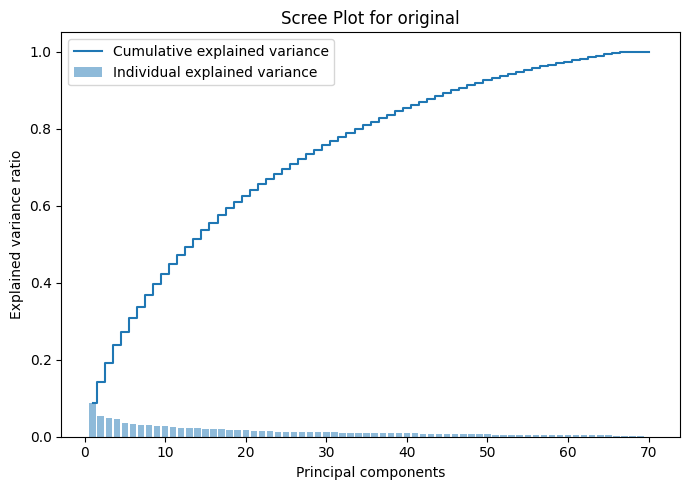

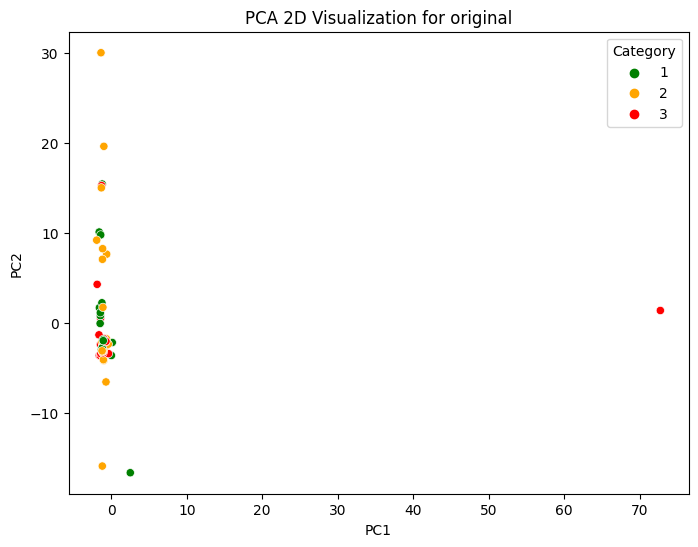

original_pipeline:


In [391]:
# Aply pipeline for visual results
results_original_pca= pca_pipeline(original, 'Category', n_components=2, dataset_name='original')

# Apply the pipeline for numerical results
original_pca_pipeline, df_pca_influence_original, explained_variance_original, n_components = apply_pipeline_pca(original, "original", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_original.head(10), explained_variance_original.head(10))

### original impressions:
   - original shows no aglomeration nor useful information which is expected the noise due to the large amount of data and features/sample ratio. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named original_pca and is composed of 51 features.
### original_pca: Making up a dataframe from the feature_influencers from pca results

In [392]:
df_pca_influence_columns = df_pca_influence_original["Features"].head(50).values.tolist()
original_pca = original[["Category"] + df_pca_influence_columns]

## 4.2. uniques: Computing PCA and Varianza -Scree Plots
selected data from the original only unique genera per category is in this dataframe of 343 genera.

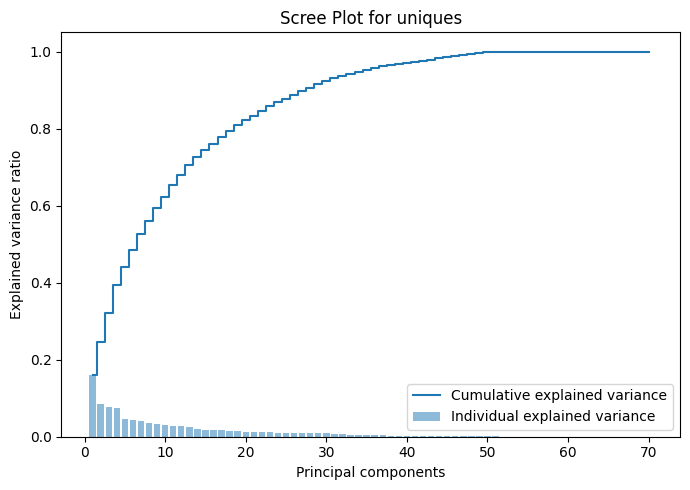

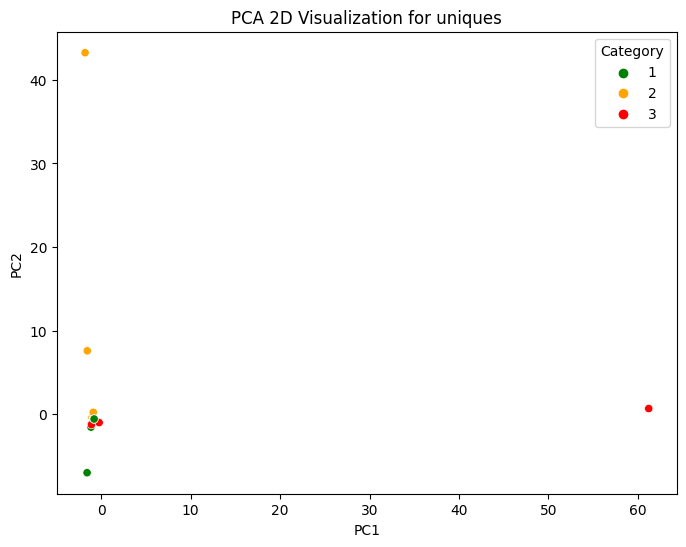

uniques_pipeline:


In [393]:
# Aply pipeline for visual results
results_uniques_pca = pca_pipeline(uniques, 'Category', n_components=2, dataset_name='uniques')

# Apply the pipeline for numerical results
uniques_pca_pipeline, df_pca_influence_uniques, explained_variance_uniques, n_components = apply_pipeline_pca(uniques, "uniques", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques.head(10), explained_variance_uniques.head(10))

### uniques insides
The explained variance improves referent to original df but the pca plot show very little diferenciation. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques_pca and is composed of 51 features.
### uniques_pca: Making up a dataframe from the feature_influencers from pca results

In [394]:
# print the genera from this pca to check #print(f"Genera uniques : {df_pca_influence['Features'].values.tolist()}")
print(*df_pca_influence_uniques['Features'].values.tolist())

704 87 238 442 649 201 211 680 690 578 621 160 696 190 457 361 594 396 240 123 857 85 494 558 132 635 436 410 477 427 46 399 244 571 122 698 22 287 239 576 382 856 406 412 645 872 104 225 636 78 355 511 541 372 580 242 879 547 496 385 2 50 142 446 642 499 548 458 301 778 672 793 803 710 105 459 498 468 409 464 726 539 612 5 97 524 159 544 450 492 131 348 448 293 288 407 340 256 418 552 583 208 478 435 298 713 839 515 667 106 513 326 221 665 345 815 215 220 262 877 303 133 346 342 25 80 527 476 779 682 593 403 840 860 849 14 138 10 291 177 693 21 252 673 485 170 213 381 439 119 333 203 15 116 115 60 772 76 823 16 824 93 545 825 861 59 814 692 798 70 188 763 799 452 788 517 826 472 579 185 852 868 501 827 363 795 811 790 786 836 782 832 781 833 834 776 835 806 756 738 810 797 792 63 62 61 366 222 516 874 241 187 176 473 536 679 755 780 56 58 57 744 283 619 764 749 791 689 774 502 505 568 264 623 846 383 813 353 629 821 624 700 843 841 783 796 397 844 338 627 718 560 54 19 842 559 818 838

In [395]:
df_pca_influence_columns = df_pca_influence_uniques["Features"].head(50).values.tolist()
uniques_pca = uniques[["Category"] + df_pca_influence_columns]

## 4.3. uniques23 Computing PCA and Varianza -Scree Plots
selected data from the original only unique genera per category is in this dataframe plus the common genera between 2 and 3 categories, contains 771 genera.

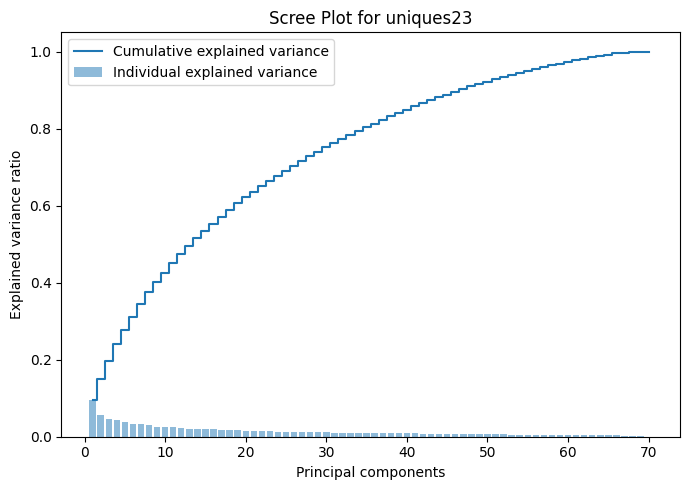

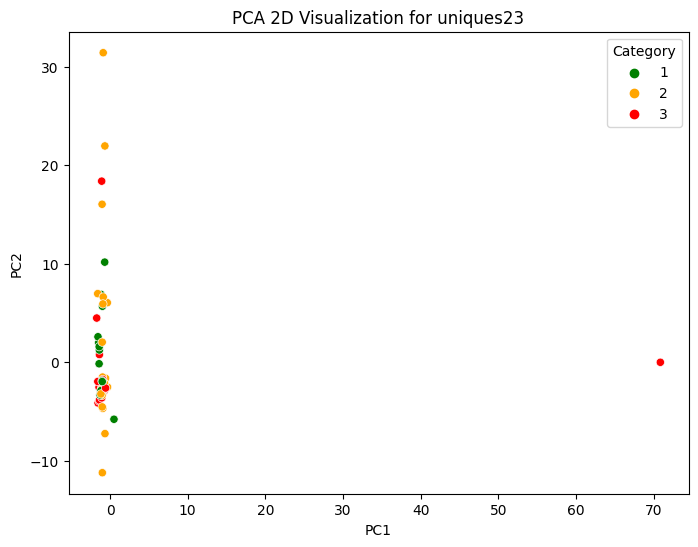

uniques23_pipeline:


In [396]:
# Aply pipeline for visual results
results_uniques23_pca = pca_pipeline(uniques23, 'Category', n_components=2, dataset_name='uniques23')

# Apply the pipeline for numerical results
uniques23_pca_pipeline, df_pca_influence_uniques23_pca, explained_variance_uniques23_pca, n_components = apply_pipeline_pca(uniques23, "uniques23", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_pca.head(10), explained_variance_uniques23_pca.head(10))

### uniques23
The explained variance is worse than uniques df and the pca plot show very little diferenciation. Notive that some influencer genera that are in original_pca are also on unique_pca. The first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques23_pca and is composed of 51 features.
### uniques23_pca: Making up a dataframe from the feature_influencers from pca results

In [397]:
print(*df_pca_influence_uniques23_pca["Features"].head(50).values.tolist())

236 259 542 41 194 566 465 512 289 323 127 110 358 621 270 330 687 720 284 265 529 456 634 276 250 140 497 214 413 139 300 223 655 243 606 575 607 81 552 591 44 39 389 86 108 526 195 308 343 614


In [398]:
df_pca_influence_columns = df_pca_influence_uniques23_pca["Features"].head(50).values.tolist()
uniques23_pca = uniques23[["Category"] + df_pca_influence_columns]

## 4.4. Influencers_OLS: Computing PCA and Varianza -Scree Plots
selected data from the original with abundance threshold of 0,2% and frequency of 3, underwent selection of significance by OLS

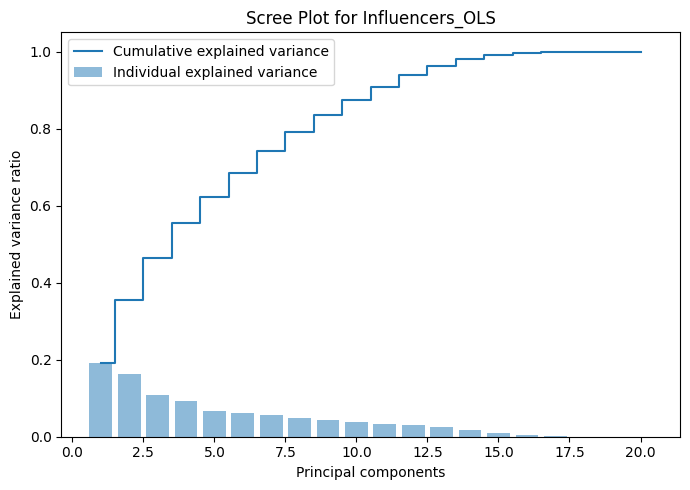

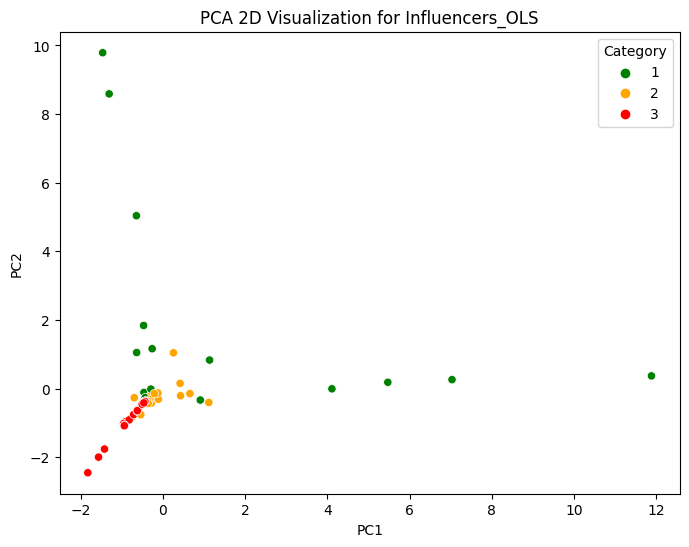

Influencers_OLS_pipeline:


In [399]:
# Aply pipeline for visual results
results_Influencers_OLS_pca = pca_pipeline(Influencers_OLS, 'Category', n_components=2, dataset_name='Influencers_OLS')
# Apply the pipeline for numerical results
Influencers_OLS_pca_pipeline, df_pca_influence_Influencers_OLS, explained_variance_Influencers_OLS, n_components = apply_pipeline_pca(Influencers_OLS, "Influencers_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_OLS.head(10), explained_variance_Influencers_OLS.head(10))

### Influencers_OLS
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and 1.
   - Category 3 There is a clear regression trend in category 3
   - Category 2 dots align in the middle, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'v' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__ The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

## 4.5.  OLS_all: Computing PCA and Varianza -Scree Plots
selected data from the original underwent selection of significance by OLS.

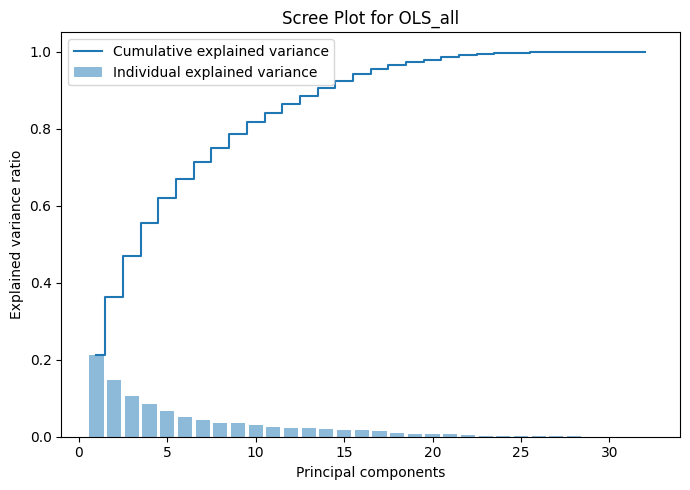

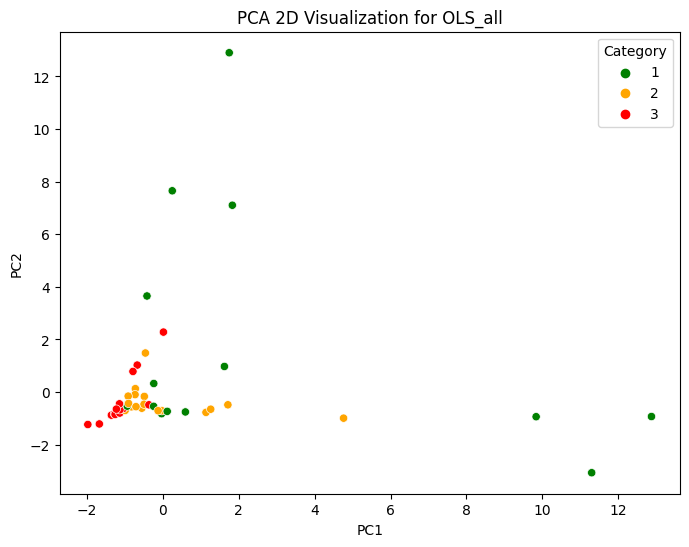

OLS_all_pipeline:


In [400]:
# Aply pipeline for visual results
Results_OLS_all_pca = pca_pipeline(OLS_all, 'Category', n_components=2, dataset_name='OLS_all')
# Apply the pipeline for numerical results
OLS_all_pca_pipeline, df_pca_influence_OLS_all, explained_variance_OLS_all, n_components = apply_pipeline_pca(OLS_all, "OLS_all", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_OLS_all.head(10), explained_variance_OLS_all.head(10))

### OLS_all
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.

In both scree plots, OLS_all and Influencers_OLS a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all, moreover the differentiation on the labels makes this dataset more relevant. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS. Until the biological significance is not accounted for, the datasets are to be retained for comparison.

## 4.6. uniques_OLS Computing PCA and Varianza -Scree Plots
selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.

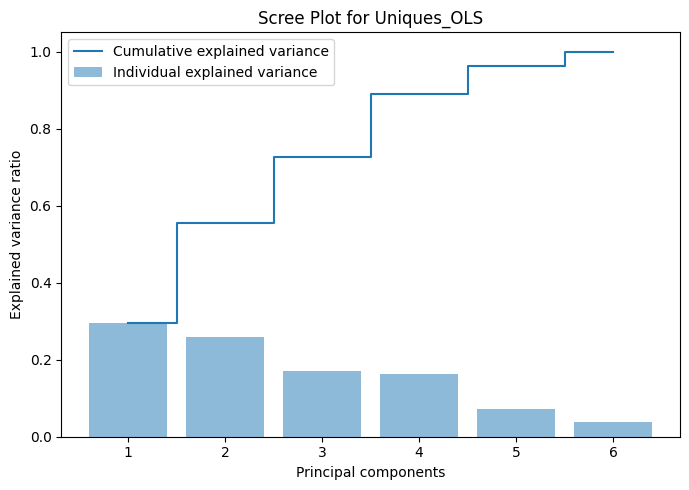

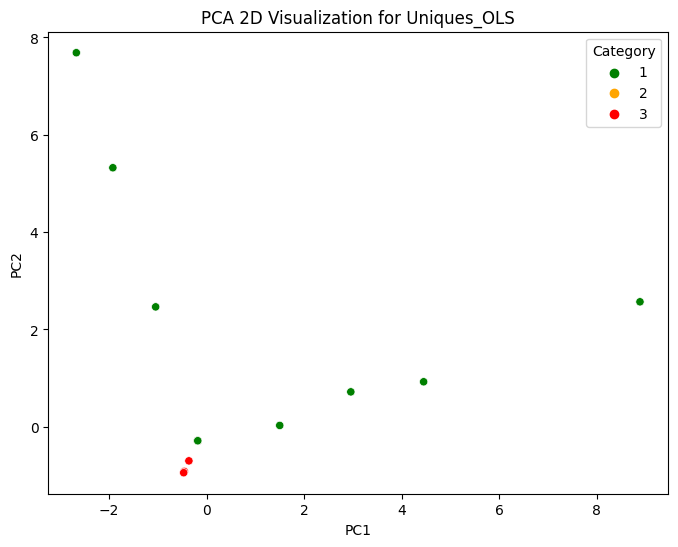

Uniques_OLS_pipeline:


In [401]:
# Aply pipeline for visual results
Results_uniques_OLS_pca = pca_pipeline(uniques_OLS, 'Category', n_components=2, dataset_name='Uniques_OLS')
# Apply the pipeline for numerical results
uniques_OLS_pca_pipeline, df_pca_influence_uniques_OLS, explained_variance_uniques_OLS, n_components = apply_pipeline_pca(uniques_OLS, "Uniques_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques_OLS.head(10), explained_variance_uniques_OLS.head(10))

### uniques_OLS:
   - Uniques_OLS is compound of only 6 features and interestingly it shows the best differenciation on the pca of the components. Also the varianza increases from 0.2 on the previous dfs to 0.3 explained variance. Showing that this features can explain better the dataset in reference to the corrosion rick label.
   - The v shape of the category 1 is very clear and so is the lineal presence of category 3.  

## 4.7. uniques_23_OLS: Computing PCA and Varianza -Scree Plots
selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.

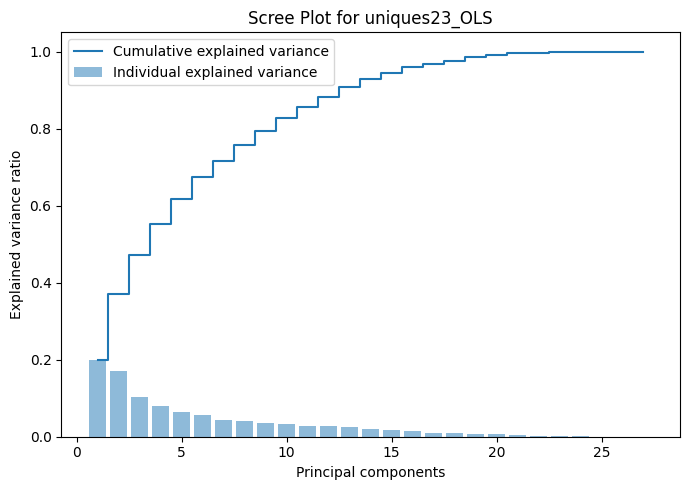

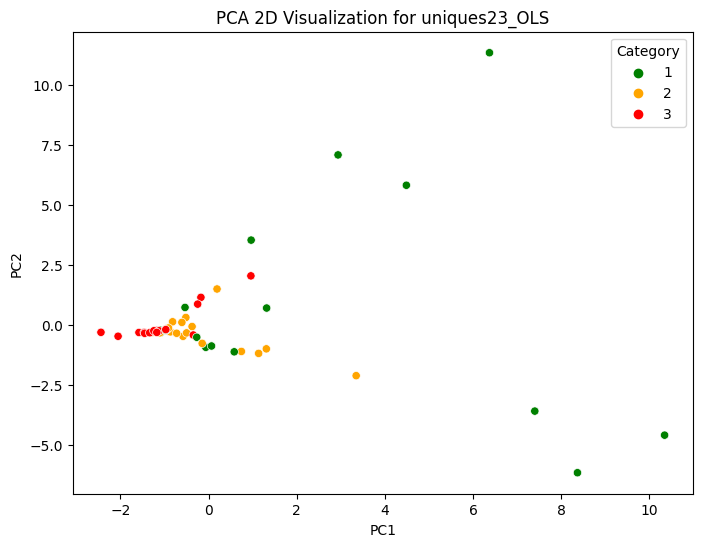

uniques23_OLS_pipeline:


In [402]:
# Aply pipeline for visual results
results_uniques23_OLS_pca = pca_pipeline(uniques23_OLS, 'Category', n_components=2, dataset_name='uniques23_OLS')
# Apply the pipeline for numerical results
uniques23_OLS_pca_pipeline, df_pca_influence_uniques23_OLS, explained_variance_uniques23_OLS, n_components = apply_pipeline_pca(uniques23_OLS, "uniques23_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_OLS.head(10), explained_variance_uniques23_OLS.head(10))

### uniques23__OLS:
   - Uniques_23 is compose of more as 300 features and interestingly shows the worst differenciation blobs on the pca components. Also the varianza decreases from 0.3 on the previous df to 0.2 explained variance. Showing that this features have to be decreased in order to increase significance in reference to the corrosion rick label.
   - Category 1 has very clear separation similar to the previous dataframes, however 2 and 3 are overlaped yet feature 3 continues to present a lineal regresion between the two PC.

# 5. Pipelines Predictive Analysis
## 5.1 Pipeline for Regression script

In [403]:
def apply_pipeline_regressor(df, dataset_name):
    print(f"{dataset_name}_pipeline:")
    '''
    Pipeline for regression that handles the imbalanced data
    '''

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()

    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Compute sample weights for the entire training set
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf_mae_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    for train_index, val_index in kf.split(X_train):
        # Split the current fold's train and validation sets
        X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]

        # Compute sample weights for the current fold
        fold_weights = compute_sample_weight(class_weight='balanced', y=y_train_fold)

        # Train and predict with sample weights
        rf_pipeline.fit(X_train_fold, y_train_fold, rf__sample_weight=fold_weights)
        y_pred = rf_pipeline.predict(X_val)

        # Calculate and store MAE
        mae = round(mean_absolute_error(y_val, y_pred),4)
        rf_mae_scores.append(mae)

    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {round(np.mean(rf_mae_scores), 4)}")

    # Evaluate on the initial test split with sample weights
    rf_pipeline.fit(X_train, y_train, rf__sample_weight=sample_weights)
    y_test_pred = rf_pipeline.predict(X_test)

    # Evaluate the model
    mse = round(mean_squared_error(y_test, y_test_pred), 4)
    print(f'Mean Squared Error: {mse}')
    rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = round(mean_absolute_error(y_test, y_test_pred), 4)
    print(f'Mean Absolute Error: {mae}')

    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_

    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(f'Feature Importance by RF: {df_importances_rf.head(25)}')

    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

## 5.2. Pipeline for Clasification script

In [404]:
def apply_classification_pipeline_classif(df, dataset_name):
    print(f"{dataset_name}_pipeline:")

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()

    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target  Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Reshape target variables for consistency
    y_train = y_train.values
    y_test = y_test.values

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store performance metrics
    cv_accuracy_scores = []
    cv_precision_scores = []
    cv_recall_scores = []
    cv_f1_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight=class_weight_dict  # Use computed class weights
        ))
    ])

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        # Split training data
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Fit pipeline on training fold
        rf_pipeline.fit(X_fold_train, y_fold_train)

        # Predict on validation fold
        y_pred = rf_pipeline.predict(X_fold_val)

        # Calculate and store performance metrics
        cv_accuracy_scores.append(round(accuracy_score(y_fold_val, y_pred), 4))
        cv_precision_scores.append(round(precision_score(y_fold_val, y_pred, average='weighted'), 4))
        cv_recall_scores.append(round(recall_score(y_fold_val, y_pred, average='weighted'), 4))
        cv_f1_scores.append(round(f1_score(y_fold_val, y_pred, average='weighted'), 4))


    # Print cross-validation results
    print("Cross-Validation Metrics:")
    print(f"Accuracy: {cv_accuracy_scores}")
    print(f"Average F1-Score: {round(np.mean(cv_accuracy_scores), 4)}")
    print(f"Precision: {cv_precision_scores}")
    print(f"Average Precision: {round(np.mean(cv_precision_scores), 4)}")
    print(f"Recall: {cv_recall_scores}")
    print(f"Average Recall: {round(np.mean(cv_recall_scores), 4)}")
    print(f"F1-Score: {cv_f1_scores}")
    print(f"Average F1-Score: {round(np.mean(cv_f1_scores), 4)}")

    # Final model fit on entire training data  
    rf_pipeline.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = rf_pipeline.predict(X_test)

    # Confusion Matrix and Classification Report
    print("\nTest Set Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Extract feature importances
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_

    # Create feature importance DataFrame
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print('\nFeature Importance:')
    print(df_importances_rf)
    # Prepare the feature_scores corresponding to accuracy and F1:
    scores = {
        'feature_names': feature_names,
        'accuracy': accuracy_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred, average='weighted'),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted')
}

    return rf_pipeline, df_importances_rf, scores

# 6. Results Predictive Analysis

## 6.1. original Regression and Classification

In [405]:
# Apply pipeline Regression
original_pca_pipeline_reg, df_importances_reg_original_pca= apply_pipeline_regressor(original_pca, "original_pca")
# Apply the pipeline Classification
original_pca_pipe_class, df_importances_original_pca, original_pca_feature_scores= apply_classification_pipeline_classif(original_pca, "original_pca")

original_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.9522, 0.5943, 0.4395, 0.7379]
Average MAE for RF: 0.6809
Mean Squared Error: 0.36
Root Mean Squared Error: 0.6
Mean Absolute Error: 0.4956
Feature Importance by RF:     Features  Importance
0        140      0.1133
17       526      0.1003
26       270      0.0916
20       323      0.0790
14       566      0.0741
10       491      0.0739
1        575      0.0572
12       727      0.0482
19       456      0.0357
9        474      0.0344
5        529      0.0342
25       591      0.0311
2        687      0.0309
34       455      0.0261
13        81      0.0192
18        86      0.0167
22       265      0.0166
42       155      0.0128
7        564      0.0123
31       607      0.0111
23       875      0.0094
4        300      0.0093
6        609      0.0087
38       606      0.0083
43       503      0.0079
original_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average F1-Score: 0.5349
Precision: [0.4826, 0.202, 0.6818, 0.3961, 0.5818]
Average Precision: 0.4689
Recall: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Recall: 0.5349
F1-Score: [0.511, 0.2597, 0.6508, 0.4589, 0.5424]
Average F1-Score: 0.4846

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
17       526      0.0886
10       491      0.0844
20       323      0.0772
1        575      0.0622
26       270      0.0584
2        687      0.0512
12   

### Original discussion
**Original_PCA_pipeline Regression**:
This pipeline shows moderate performance in regression and classification tasks. The Mean Absolute Error (MAE) is around 0.6756, with an average accuracy of 0.4571. The feature importance is distributed across multiple features, with features 323, 491, and 526 being the most significant. This pipeline does not seem to offer significant improvements over the existing pipelines.
**Original_pca_pipeline Classification**
Low cross-validation accuracy (0.4571) and inconsistent performance.
Class 1: Zero precision and recall, indicating an inability to classify this category.This pipeline is weaker than all of the others.

## 6.2. uniques_pca Regression and Classification

In [406]:
# Apply pipeline Regression
uniques_pca_pipeline_reg, df_importances_reg_uniques_pca= apply_pipeline_regressor(uniques_pca, "uniques_pca")
# Apply the pipeline Classification
uniques_pca_pipe_class, df_importances_uniques_pca, uniques_pca_feature_scores = apply_classification_pipeline_classif(uniques_pca, "uniques_pca")

uniques_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.5408, 0.7019, 0.4957, 0.3486, 0.6769]
Average MAE for RF: 0.5528
Mean Squared Error: 0.4413
Root Mean Squared Error: 0.6643
Mean Absolute Error: 0.4801
Feature Importance by RF:     Features  Importance
9        578      0.1765
22       494      0.1555
7        680      0.1222
5        201      0.0893
6        211      0.0690
0        704      0.0616
1         87      0.0574
23       558      0.0340
24       132      0.0339
4        649      0.0293
26       436      0.0266
25       635      0.0242
12       696      0.0196
43       412      0.0169
44       645      0.0126
11       160      0.0111
47       225      0.0098
10       621      0.0077
46       104      0.0076
45       872      0.0068
42       406      0.0065
2        238      0.0058
13       190      0.0041
48       636      0.0024
49        78      0.0021
uniques_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average F1-Score: 0.5167
Precision: [0.8438, 0.5568, 0.8182, 0.8295, 0.8636]
Average Precision: 0.7824
Recall: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Recall: 0.5167
F1-Score: [0.5822, 0.4897, 0.4242, 0.5449, 0.4779]
Average F1-Score: 0.5038

Test Set Evaluation:
Confusion Matrix:
[[3 0 0]
 [4 3 0]
 [3 0 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.30      1.00      0.46         3
           2       1.00      0.43      0.60         7
           3       1.00      0.25      0.40         4

    accuracy                           0.50        14
   macro avg       0.77      0.56      0.49        14
weighted avg       0.85      0.50      0.51        14


Feature Importance:
    Features  Importance
10       621      0.1156
2        238      0.0844
9        578      0.0666
49        78      0.0625
8        690      0.0570
31       399      0.0522
6  

### uniques_pca discussion
**uniques_PCA_pipeline Regression**:
Moderate average MAE (0.5302) but still higher than Influencers_OLS.
Feature importance concentrated on a few features (e.g., 418, 410, 578).This pipeline is slightly better than original_pca_pipeline but not as strong as Influencers_OLS.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5714) but class imbalance issues.
Class 1: Zero precision and recall.
Class 2: Moderate precision and high recall.
Class 3: Perfect precision and recall but limited support. This pipeline is slightly better than original_pca_pipeline but still has significant class imbalance issues.

## 6.3. uniques23_pca Regression and Classification

In [407]:
# Apply pipeline Regression
uniques23_pca_pipeline_reg, df_importances_reg_uniques23_pca= apply_pipeline_regressor(uniques23_pca, "uniques23_pca")
# Apply the pipeline Classification
uniques23_pca_pipe_class, df_importances_uniques23_pca, uniques23_pca_feature_scores = apply_classification_pipeline_classif(uniques23_pca, "uniques23_pca")

uniques23_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6717, 0.8082, 0.4745, 0.3055, 0.6045]
Average MAE for RF: 0.5729
Mean Squared Error: 0.4196
Root Mean Squared Error: 0.6478
Mean Absolute Error: 0.5293
Feature Importance by RF:     Features  Importance
11       110      0.2010
25       140      0.1119
45       526      0.0788
5        566      0.0658
9        323      0.0650
14       270      0.0564
27       214      0.0518
21       456      0.0352
35       575      0.0331
16       687      0.0316
49       614      0.0309
29       139      0.0250
22       634      0.0239
37        81      0.0214
23       276      0.0199
39       591      0.0182
43        86      0.0151
18       284      0.0146
20       529      0.0134
34       606      0.0127
30       300      0.0088
36       607      0.0087
24       250      0.0079
19       265      0.0077
40        44      0.0062
uniques23_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average F1-Score: 0.5333
Precision: [0.6448, 0.2273, 0.5, 0.7121, 0.4864]
Average Precision: 0.5141
Recall: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Recall: 0.5333
F1-Score: [0.6377, 0.2797, 0.4394, 0.6228, 0.4646]
Average F1-Score: 0.4888

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.62      0.71      0.67         7
           3       0.67      0.50      0.57         4

    accuracy                           0.64        14
   macro avg       0.65      0.63      0.63        14
weighted avg       0.65      0.64      0.64        14


Feature Importance:
    Features  Importance
11       110      0.1098
45       526      0.1014
9        323      0.0762
29       139      0.0514
25       140      0.0505
49       614      0.0500
35    

### uniques23_pca discussion
**uniques_PCA_pipeline Regression**:
Higher average MAE (0.6247) and higher variability in MAE scores.
Feature importance distributed across multiple features. This pipeline does not offer significant improvements over the existing pipelines.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5286) with consistent but low accuracy across folds.
Class 1: Perfect precision but very low recall.
Class 2: Moderate precision and high recall.
Class 3: Zero precision and recall. This pipeline has similar issues to the other pipelines, particularly with class imbalance.

Analysing the three new created dfs from the pca dimensionality reduction step. We see that The uniques_pca_pipeline shows the lowest MAE, indicating it performs best in terms of prediction error. The uniques_pca_pipeline also has the highest accuracy.
Each pipeline has slightly different top features.
original_pca_pipeline top features: 42 323 (0.1183), 27 491 (0.0882)
uniques23_pca_pipeline top features: 11 323 (0.1204), 15 491 (0.0754)
uniques_pca_pipeline top features: 10 418 (0.1997), 34 410 (0.1751)

## 6.4. Influencers_OLS Regression and Classification

In [408]:
# Apply pipeline Regression
Influencers_OLS_pipeline_reg, Importances_rf_Influencers_Influencers_OLS = apply_pipeline_regressor(Influencers_OLS, "Influencers_OLS")

# Apply the pipeline Classification
Influencers_OLS_pipe_class, importances_class_Influencers_OLS, Influencers_OLS_feature_scores = apply_classification_pipeline_classif(Influencers_OLS, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3458, 0.2718, 0.1827, 0.1818, 0.1764]
Average MAE for RF: 0.2317
Mean Squared Error: 0.1712
Root Mean Squared Error: 0.4137
Mean Absolute Error: 0.2443
Feature Importance by RF:     Features  Importance
16       549      0.5054
7        526      0.1972
11       864      0.0650
6        863      0.0444
14       408      0.0386
2        214      0.0251
19       229      0.0234
5         91      0.0228
10       625      0.0160
13       565      0.0145
15       334      0.0137
3        351      0.0136
4         23      0.0124
17       375      0.0056
8        584      0.0019
18       471      0.0005
12       678      0.0000
0        725      0.0000
1        871      0.0000
9        712      0.0000
Influencers_OLS_pipeline:
Cross-Validation Metrics:
Accuracy: [0.9167, 0.9091, 0.8182, 0.8182, 0.8182]
Average F1-Score: 0.8561
Precision: [0.9306, 0.9242, 0.8701, 0.8701, 0.8182]
Average Precision: 0.8826
Recall: [0.9167, 0.9091, 0

### Influencers_OLS Discussion
**Influencers_OLS Pipeline Regression:**
Cross-Validation MAE Scores for RF: Consistently lower and less variable (ranging from 0.1426 to 0.34) with a significantly lower average MAE (0.242).
Error Metrics:
MSE: 0.2618; RMSE: 0.5116; MAE: 0.34  

These metrics demonstrate improved prediction accuracy and model reliability compared to OLS_all. Feature importance is more concentrated, with feature 526 having an overwhelming impact (importance: 0.4318). Other features like 549 and 625 show noticeable contributions but to a lesser extent.

**Influencers_OLS_pipeline Classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.8286 (high and consistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but lower recall (misclassifications lead to only 67% recall).  
Class 2: High recall (100%) but lower precision (64%).   
Class 3: High precision (100%) but very low recall (25%), indicating many false negatives.  
Classification Report:  
Macro average recall (0.64) suggests unbalanced performance across classes.  
Weighted average metrics reflect an overall acceptable but not ideal model for classifying all categories equally well.  
Feature Importance:  
Feature 526 dominates (23.26%), followed by moderately impactful features like 549 and 864.  

## 6.5. OLS_all Regression and Classification

In [409]:
# Apply pipeline Regression
OLS_all_pipe_reg, importances_reg_OLS_all = apply_pipeline_regressor(OLS_all, "OLS_all")

# Apply the pipeline classification
OLS_all_pipe_class, importances_class_OLS_all, OLS_all_feature_scores = apply_classification_pipeline_classif(OLS_all, "OLS_all")

OLS_all_pipeline:
Cross-Validation MAE Scores for RF: [0.7, 0.7109, 0.3736, 0.2518, 0.4764]
Average MAE for RF: 0.5025
Mean Squared Error: 0.3518
Root Mean Squared Error: 0.5931
Mean Absolute Error: 0.45
Feature Importance by RF:     Features  Importance
29       549      0.4051
6         23      0.0816
4        470      0.0703
3        214      0.0678
27       140      0.0678
31       229      0.0522
10       584      0.0452
14       625      0.0387
26       334      0.0242
1        871      0.0186
7         91      0.0179
23       565      0.0149
25        92      0.0139
22       605      0.0131
21       678      0.0126
0        725      0.0125
5         79      0.0071
8         88      0.0067
11       712      0.0067
24       426      0.0041
2        428      0.0040
9        480      0.0037
15       337      0.0036
30       771      0.0024
19       342      0.0019
OLS_all_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average F1-Score: 0.553
Precision: [0.5278, 0.202, 0.3961, 0.4091, 0.6623]
Average Precision: 0.4395
Recall: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Recall: 0.553
F1-Score: [0.553, 0.2597, 0.4589, 0.4615, 0.6685]
Average F1-Score: 0.4803

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
    Features  Importance
29       549      0.1605
3        214      0.1094
31       229      0.1005
6         23      0.0627
4        470      0.0526
27       140      0.0521
7      

### OLS_all Discussion
**OLS_all_pipeline regression:**
Cross-Validation MAE Scores for RF: Higher variability across folds (ranging from 0.3935 to 0.6886) and a higher average MAE (0.5725) suggest that the model's predictive performance is less consistent.
Error Metrics:
Mean Squared Error (MSE): 0.3921; Root Mean Squared Error (RMSE): 0.6262;Mean Absolute Error (MAE): 0.5634
These metrics indicate lower prediction accuracy compared to the Influencers_OLS pipeline.
**Importance** is more evenly distributed, with no single feature dominating.
Top features (e.g., feature 549, 23, and 625) exhibit moderate importance values (0.1883, 0.1233, 0.0887).

**OLS_all_pipeline classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.4714 (significantly lower, inconsistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but extremely low recall (17%), with many false negatives.   
Class 2: Moderate precision (45%) and high recall (83%), indicating a focus on this class.  
Class 3: Zero precision and recall, indicating an inability to classify this category.  
Classification Report:   
Macro and weighted averages are much lower than Influencers_OLS, indicating an overall weaker model.  
Feature Importance:   
Importance is more distributed but lower overall contributions compared to Influencers_OLS.   

## 6.6. uniques_OLS Regression and Classification

In [410]:
# Apply pipeline Regression
uniques_OLS_pipeline, importances_reg_uniques_OLS = apply_pipeline_regressor(uniques_OLS, "Uniques_OLS")
# Apply the pipeline Classification
uniques_OLS_pipe_class, importances_class_uniques_OLS, uniques_OLS_feature_scores = apply_classification_pipeline_classif(uniques_OLS, "unique_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6302, 0.6662, 0.5366, 0.3111, 0.6006]
Average MAE for RF: 0.5489
Mean Squared Error: 0.4244
Root Mean Squared Error: 0.6515
Mean Absolute Error: 0.4848
Feature Importance by RF:    Features  Importance
0       541      0.3850
3       342      0.3199
2       201      0.2007
1       494      0.0626
5       799      0.0319
4       410      0.0000
unique_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

Cross-Validation Metrics:
Accuracy: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average F1-Score: 0.5364
Precision: [0.5227, 0.2066, 0.2066, 0.798, 0.4343]
Average Precision: 0.4336
Recall: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Recall: 0.5364
F1-Score: [0.3938, 0.2841, 0.2841, 0.5974, 0.5065]
Average F1-Score: 0.4132

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 7 0]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.58      1.00      0.74         7
           3       1.00      0.25      0.40         4

    accuracy                           0.64        14
   macro avg       0.86      0.53      0.55        14
weighted avg       0.79      0.64      0.59        14


Feature Importance:
   Features  Importance
0       541      0.3192
3       342      0.2839
2       201      0.2149
1       494      0.1226
5       799      0.0595
4       410      0.0000


### uniques_OLS Discussion
**uniques_OLS_pipeline Regression:**
Cross-Validation MAE Scores for RF: Higher variability (range 0.3783–0.7313) and a comparable average MAE (0.572).  
Error Metrics:  
MSE: 0.7412 ; RMSE: 0.8609 ; MAE: 0.7313 (relatively high).  These metrics are slightly higher than those of the unique23 pipeline, suggesting a slightly higher level of error.
These metrics reflect suboptimal predictive performance compared to other datasets.  
Feature Importance:   
Importance is relatively concentrated among the top three features (541: 0.2426, 342: 0.2327, 410: 0.2050), suggesting a model reliant on a few key variables.  
**uniques_OLS_pipeline Classification:**
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.4286 to 0.7143, with an average accuracy of 0.5429. This is slightly better than the unique23 pipeline but still shows variability.
Confusion Matrix and Classification Report:
Class 1: Zero precision and recall, indicating all instances of this class are misclassified.
Class 2: Perfect precision and recall for the instances classified, but the confusion matrix suggests many instances are not classified correctly.
Class 3: Zero precision and recall, similar to Class 1.
Features 229 and 214 have the highest importance (0.1008 and 0.0947, respectively), followed by features 549, 23, and 140. Distribution similar to the uniques23.

## 6.7. uniques_23_OLS Regression and Classification

In [411]:
# Apply pipeline Regression
unique_23_OLS_pipeline_rg, importances_rf_uniques23_OLS= apply_pipeline_regressor(uniques23_OLS, "unique23_OLS")
# Apply the pipeline Classification
uniques23_OLS_pipe_class, importances_class_uniques23_OLS, uniques23_OLS_feature_scores = apply_classification_pipeline_classif(uniques23_OLS, "unique23_OLS")

unique23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.7033, 0.7282, 0.3764, 0.2709, 0.5136]
Average MAE for RF: 0.5185
Mean Squared Error: 0.3634
Root Mean Squared Error: 0.6028
Mean Absolute Error: 0.4593
Feature Importance by RF:     Features  Importance
25       549      0.4159
4        470      0.0794
5         23      0.0774
24       140      0.0710
3        214      0.0699
26       229      0.0560
9        584      0.0409
12       625      0.0379
22       334      0.0244
1        871      0.0225
6         91      0.0171
20       565      0.0144
19       605      0.0128
18       678      0.0125
0        725      0.0102
21       426      0.0066
7         88      0.0065
2        428      0.0043
13       337      0.0042
10       712      0.0041
16       342      0.0037
8        480      0.0031
11       799      0.0022
14       541      0.0021
15       494      0.0009
unique23_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average F1-Score: 0.5364
Precision: [0.4603, 0.202, 0.4667, 0.4091, 0.6364]
Average Precision: 0.4349
Recall: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Recall: 0.5364
F1-Score: [0.4683, 0.2597, 0.5351, 0.4615, 0.6222]
Average F1-Score: 0.4694

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
    Features  Importance
25       549      0.1660
3        214      0.1063
26       229      0.0870
4        470      0.0743
24       140      0.0646
5         23      0.0620
6         

### uniques23_OLS Discussion
**unique23_OLS_pipeline Regression**:
Cross-Validation MAE Scores for RF: Less variability (range 0.3867–0.72) and slightly higher average MAE (0.5751).
Error Metrics:
MSE: 0.3868 ; RMSE: 0.622 ; MAE: 0.5623 (lower than uniques_OLS).These metrics indicate better performance than uniques_OLS, possibly due to the model leveraging a larger pool of features.

**Feature importance** is more evenly distributed across top contributors (e.g., 549: 0.1899, 23: 0.1025, 625: 0.0889). High-dimensionality could contribute to complexity but might also capture subtle interactions.  
**unique23_OLS_pipeline Classification**:
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.3571 to 0.5714, with an average accuracy of 0.4429. This indicates a moderate level of classification accuracy with significant variability.
Confusion Matrix and Classification Report:
Class 1: Perfect precision but very low recall (0.17), indicating many false negatives.
Class 2: Moderate precision (0.45) and high recall (0.83).
Class 3: Zero precision and recall, indicating all instances of this class are misclassified. Macro average recall is 0.33, suggesting unbalanced performance across classes.
Feature Importance:
Feature 229 has the highest importance (0.1008), followed by features 214, 549, 23, and 140. This indicates a spread of importance across several features.

**unique_23_OLS_pipeline** achieves slightly better predictive accuracy despite higher dimensionality, possibly due to capturing more complex interactions, performs better numerically. Suggesting that the dataset's complexity adds value despite reduced interpretability.
**uniques_OLS_pipeline**, though concise, has poorer error metrics, indicating potential underfitting or missing interactions and struggles with predictive accuracy.

## 6.8. p_values, Sumarizing Regression and Classification Pipelines Results
### Analysing the models Regression and Classification.
Both pipelines struggle with class imbalance, leading to poor performance on certain classes.
Feature importance is similar but with slight variations, suggesting that the same set of features is important for classification in both pipelines.
Following is a significance test which take the feature scores and create multiply permutation of the labels and compare how often those permutations produce our df scores, to see if are significant different. If the p-value is low it could suggest the feature is meaningful for classification, at least statistically. First we define a funtion to calculate the category scores

In [412]:
def calculate_category_scores(feature, data, category):
    """Vectorized calculation of presence and abundance scores"""
    mask = data['Category'] == category
    cat_data = data.loc[mask, feature]
    other_data = data.loc[~mask, feature]
    
    presence_score = (cat_data > 0).mean()
    abundance_score = cat_data.mean() / (other_data.mean() + 1e-10)
    return round(presence_score * abundance_score, 4)

In [413]:
def _single_perm(df, feature_importance, categories):
    # Create view with permuted categories
    df_perm = df.copy(deep=False)
    df_perm['Category'] = np.random.permutation(categories)
    
    # Vectorized score calculation
    max_scores = []
    for feat in feature_importance['Features']:
        scores = [calculate_category_scores(feat, df_perm, cat) for cat in [1,2,3]]
        max_scores.append(max(scores))
        
    return max_scores

In [414]:
def test_feature_significance(df, feature_importance, n_permutations=500):
    categories = df['Category'].values
    
    # Calculate original scores once
    original_scores = []
    for feat in feature_importance['Features']:
        scores = [calculate_category_scores(feat, df, cat) for cat in [1,2,3]]
        original_scores.append(max(scores))
    
    # Run permutations in parallel
    permuted_scores = Parallel(n_jobs=-1)(
        delayed(_single_perm)(df, feature_importance, categories) 
        for _ in range(n_permutations))
    
    # Vectorized p-value calculation
    p_values = [(sum(perm[i] >= orig_score for perm in permuted_scores) + 1) / (n_permutations + 1)
                for i, orig_score in enumerate(original_scores)]
    
    return pd.DataFrame({'Features': feature_importance['Features'],
        'p_value': p_values, 'significant': np.array(p_values) < 0.05})

In [416]:
'''p_values_original_pca= test_feature_significance(original_pca, df_importances_original_pca)
p_values_uniques_pca = test_feature_significance(uniques_pca, df_importances_uniques_pca) 
p_values_uniques23_pca = test_feature_significance(uniques23_pca, df_importances_uniques23_pca)
p_values_Influencers_OLS = test_feature_significance(Influencers_OLS, importances_class_Influencers_OLS)
p_values_OLS_all = test_feature_significance(OLS_all, importances_class_OLS_all)
p_values_uniques_OLS = test_feature_significance(uniques_OLS, importances_class_uniques_OLS)
p_values_uniques23_OLS = test_feature_significance(uniques23_OLS, importances_class_uniques23_OLS)'''

'p_values_original_pca= test_feature_significance(original_pca, df_importances_original_pca)\np_values_uniques_pca = test_feature_significance(uniques_pca, df_importances_uniques_pca) \np_values_uniques23_pca = test_feature_significance(uniques23_pca, df_importances_uniques23_pca)\np_values_Influencers_OLS = test_feature_significance(Influencers_OLS, importances_class_Influencers_OLS)\np_values_OLS_all = test_feature_significance(OLS_all, importances_class_OLS_all)\np_values_uniques_OLS = test_feature_significance(uniques_OLS, importances_class_uniques_OLS)\np_values_uniques23_OLS = test_feature_significance(uniques23_OLS, importances_class_uniques23_OLS)'

In [254]:
significant_features = p_values_original_pca[p_values_original_pca['p_value'] < 0.05]
print(significant_features)

    Features  p_value  significant
17       526   0.0220         True
9        474   0.0120         True
0        140   0.0060         True
14       566   0.0279         True
15       621   0.0160         True


In [255]:
significant_features = p_values_uniques_pca[p_values_uniques_pca['p_value'] < 0.05]
print(significant_features)

    Features  p_value  significant
10       621   0.0060         True
31       399   0.0459         True
6        211   0.0479         True
5        201   0.0479         True
37       287   0.0459         True


In [ ]:
significant_features = p_values_uniques23_pca[p_values_uniques23_pca['p_value'] < 0.05]
print(significant_features)

    Features  p_value  significant
45       526   0.0220         True
25       140   0.0060         True
49       614   0.0479         True
27       214   0.0160         True
5        566   0.0279         True
13       621   0.0080         True
26       497   0.0140         True


In [257]:
significant_features = p_values_OLS_all[p_values_OLS_all['p_value'] < 0.05]
print(significant_features)

    Features  p_value  significant
29       549   0.0020         True
3        214   0.0160         True
31       229   0.0120         True
6         23   0.0140         True
27       140   0.0080         True
14       625   0.0259         True
23       565   0.0140         True
10       584   0.0220         True
0        725   0.0040         True
26       334   0.0100         True
22       605   0.0140         True
15       337   0.0140         True
8         88   0.0160         True
18       657   0.0499         True
2        428   0.0419         True
16       541   0.0200         True
12        90   0.0399         True


In [ ]:
significant_features = p_values_Influencers_OLS[p_values_Influencers_OLS['p_value'] < 0.05]
print(significant_features)

    Features  p_value  significant
16       549   0.0020         True
7        526   0.0020         True
11       864   0.0020         True
17       375   0.0020         True
19       229   0.0020         True
2        214   0.0220         True
4         23   0.0020         True
15       334   0.0020         True
10       625   0.0020         True
13       565   0.0020         True
8        584   0.0020         True
0        725   0.0020         True
18       471   0.0020         True
9        712   0.0020         True
12       678   0.0020         True
1        871   0.0020         True


In [259]:
significant_features = p_values_uniques_OLS[p_values_uniques_OLS['p_value'] < 0.05]
print(significant_features)

   Features  p_value  significant
0       541   0.0040         True
2       201   0.0379         True
1       494   0.0339         True
5       799   0.0419         True


In [260]:
significant_features = p_values_uniques23_OLS[p_values_uniques23_OLS['p_value'] < 0.05]
print(significant_features)

    Features  p_value  significant
25       549   0.0020         True
3        214   0.0080         True
26       229   0.0080         True
24       140   0.0040         True
5         23   0.0180         True
20       565   0.0100         True
12       625   0.0259         True
0        725   0.0120         True
22       334   0.0080         True
9        584   0.0180         True
13       337   0.0220         True
19       605   0.0060         True
7         88   0.0259         True
14       541   0.0160         True
2        428   0.0479         True
23       201   0.0339         True


* p_values_original_pca for this dataframe out of 50 features 140, 621, 474, 526, 566 have significance in terms of p_vallue, which also agrees with the later check on frequency and abundance, they have values that increase or have some correlation with the label and represent the data, however the abundance and frequency can be ambiguous in a granular level.  
* For uniques_pca features 621, 399, 211, 201, 287, 690and 494 appear have significance.
* From all the dataframes Influencers_OLS has the most significant feature if looking at the threshold. However some communatities about this approval is that some of the bacteria are present on non consistent was across categories, increasing in abundance but no in frequency or showing more abundance on the cat 1 and 2, for instance 549 is a strong predictor, with high frequency in all the categories but abundance in a decreasing fashion, which can be controversial, is it because has a protective chatacter? or is a bystander?. Similar behaviour as 526 and 864.
This notebook makes a series of test and ultimately the compound of them will be look to gather the most influential genera.

# 7. Integration of Dataframes
**Integrating Influencers_OLS and uniques_OLS**
So analysing the Influencers_OLS results it is seen that it clasify well class 1 and 3, however having fewer members of class 1, and uniques_OLS is a small dataframe that shows good classification on class 1. So the join of the two will be check. It is comprised of 27 genera.
**Integrating OLS_all and uniques_OLS**
This is likely better option because uniques_OLS has shown better performance in classifying Class 1, which is a weakness in OLS_all_pipeline. The feature importance distribution and the strengths in classifying Class 1 make it a good complement. However looking at the merge of the two of them, there is no need to join them since uniques is part of all.

In [261]:
# Merging the dataframes OLS_all and uniques_OLS on idex "Sites
all_uniques= pd.merge(OLS_all, uniques_OLS, left_index=True, right_index=True, suffixes =('_all', '_uniques'))
# Drop any duplicate columns
all_uniques= all_uniques.loc[:, ~all_uniques.columns.duplicated()]
all_uniques= all_uniques.drop(columns="Category_uniques")
all_uniques = all_uniques.rename(columns={"Category_all" : "Category"})
all_uniques.columns

Index([   'Category',           725,           871,           428,
                 214,           470,            79,            23,
                  91,            88,           480,           584,
                 712,            90,     '799_all',           625,
                 337,     '541_all',     '494_all',           657,
           '342_all',     '410_all',           678,           605,
                 565,           426,            92,           334,
                 140,     '201_all',           549,           771,
                 229, '541_uniques', '494_uniques', '201_uniques',
       '342_uniques', '410_uniques', '799_uniques'],
      dtype='object')

# 7.1. The Making of Influencers_uniques

In [417]:
# Ensure that the Sites index is sorted properly
Influencers_OLS = Influencers_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
uniques_OLS = uniques_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
# Merging the dataframes Influencers_OLS and 0,uniques_OLS on idex "Sites
Influencers_uniques= pd.merge(Influencers_OLS, uniques_OLS, left_index=True, right_index=True, suffixes =('_Influencers', '_uniques'))
# Drop any duplicate columns
Influencers_uniques= Influencers_uniques.loc[:, ~Influencers_uniques.columns.duplicated()]
Influencers_uniques= Influencers_uniques.drop(columns="Category_uniques")
Influencers_uniques = Influencers_uniques.rename(columns={"Category_Influencers" : "Category"})
Influencers_uniques = Influencers_uniques.reset_index()
Influencers_uniques = Influencers_uniques.astype({"Sites": str, "Category": int})
Influencers_uniques = Influencers_uniques.set_index("Sites")

## Influencers_uniques: PCA, Regression and Classification

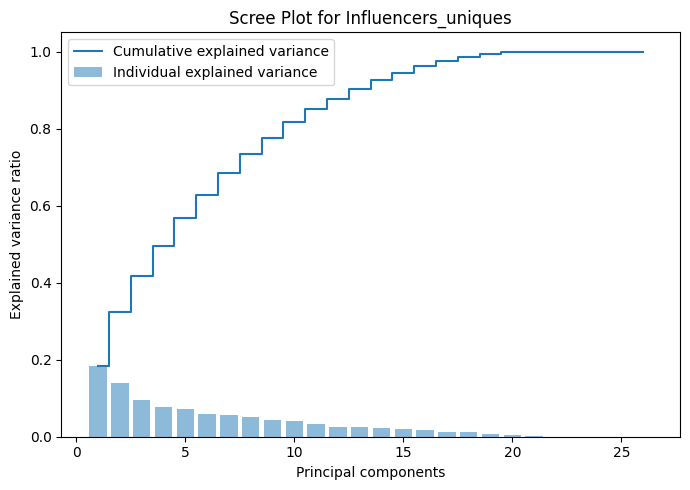

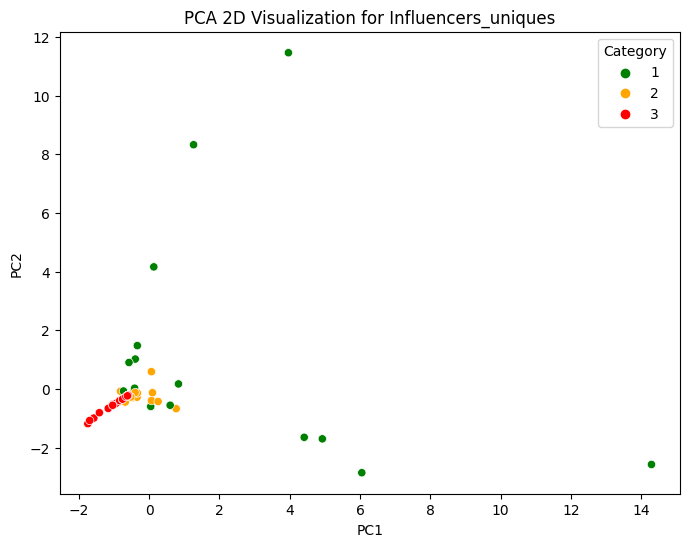

Influencers_uniques_pipeline:


Influencers_uniques_pipeline:
Cross-Validation MAE Scores for RF: [0.345, 0.2718, 0.1773, 0.1791, 0.1664]
Average MAE for RF: 0.2279
Mean Squared Error: 0.1715
Root Mean Squared Error: 0.4141
Mean Absolute Error: 0.2471
Feature Importance by RF:     Features  Importance
16       549      0.5109
7        526      0.1998
11       864      0.0651
6        863      0.0466
14       408      0.0360
19       229      0.0248
2        214      0.0243
4         23      0.0231
5         91      0.0209
3        351      0.0140
10       625      0.0138
13       565      0.0091
15       334      0.0085
18       471      0.0027
8        584      0.0003
22       201      0.0001
12       678      0.0000
17       375      0.0000
0        725      0.0000
1        871      0.0000
23       342      0.0000
21       494      0.0000
20       541      0.0000
24       410      0.0000
9        712      0.0000
Influencers_uniques_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.818

In [418]:
# Aply pipeline for visual results
results_Influencers_uniques_pca = pca_pipeline(Influencers_uniques, 'Category', n_components=2, dataset_name='Influencers_uniques')

# Apply the pipeline for numerical results
Influencers_uniques_pipeline, df_pca_influence_Influencers_uniques, explained_variance_Influencers_uniques, n_components = apply_pipeline_pca(Influencers_uniques, "Influencers_uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_uniques.head(10), explained_variance_Influencers_uniques.head(10))

# Apply pipeline Regression
Influencers_uniques_pipeline_reg, importances_reg_Influencers_uniques= apply_pipeline_regressor(Influencers_uniques, "Influencers_uniques")
# Apply the pipeline Classification
Influencers_uniques_pipe_class, importances_class_Influencers_uniques, Influencers_uniques_feature_scores = apply_classification_pipeline_classif(Influencers_uniques, "Influencers_uniques")

### Influencers_uniques Discussion
**Influencers_uniques pipeline Regression**:
The model is performing well with low MAE variability, ranging from 0.1415 to 0.3307 and an average MAE of 0.24. Compared to previous datasets (like uniques_OLS_pipeline where the variability was higher), this suggests an improved and more reliable model.
MSE (0.2523) and RMSE (0.5022) indicate moderate error levels, which suggest the model is performing reasonably well in terms of prediction accuracy. These are substantially better than earlier models where error levels were high.
**Feature importance**
Feature 526 stands out as the most significant with an importance score of 0.4293, followed by feature 549 at 0.2017. These scores point to a few dominating features, which aligns with my future approach of combining the most influential features across datasets. This can potentially improve both feature selection and model generalization when merged. Indeed, the features indicate a focus on a few predictors that contribute heavily to the outcome. This could be useful when aim to reduce features but still retain biologically relevant ones.  
**Influencers_uniques_pipeline Classification**:
Cross-Validation Accuracy: This model achieved an average classification accuracy of 0.9571, which is quite strong. The relatively high accuracy, along with a well-balanced confusion matrix, suggests that the model can differentiate well across the three categories.  Confusion Matrix & Classification Report:
    Class 1: Precision is perfect (1.0), but recall suffers (0.67), indicating that there may be a misclassification problem with certain examples.
    Class 2: High recall (1.0), but lower precision (0.78), meaning the model is good at catching all instances of Class 2 but sometimes incorrectly classifies other categories as Class 2.
    Class 3: Very high precision (1.0) but lower recall (0.75), indicating some false negatives are present, but the classification of class 3 is still accurate when it happens.

This classification model is performing fairly well but could be further refined, especially in terms of recall for classes 1 and 3, perhaps with tweaks in model parameters.Feature Importance: The top three most important features (526, 549, and 864) once again highlight a few dominating predictors. These feature priorities would be the core of my focus, moving forward into the feature selection across datasets using biological relevance.

Influencers_uniques regression performance is improving with reduced error and a more concentrated feature importance distribution. This is promising for further refinement. The classification performance suggests some room for improvement, particularly in balancing recall and precision across classes, especially for Class 1 and 3. Combining datasets with influential features and considering their biological relevance for dimensionality reduction is an effective way forward.
Feature selection based on importance, variance, and biological significance will help ensure the model remains robust while simplifying feature sets.

# 7.2. Merged_df: Combining Dataframes  
The dataframes with a significant degree of importance for the next phase will be retained. Uniques_OLS has already been combined to create Influencers_uniques. The original features' PCA performance may provide valuable insights into predicting overall behavior and will be carried forward as original_pca. However, dataframes such as uniques_pca, uniques23_pca, uniques23_OLS, and original do not demonstrate notable contributions toward improving the models. As a result, they will be dropped in this notebook after extracting their three most important features. The dataframe OLS_all will undergo further processing in the subsequent steps.
In order to get the most important Features that make up the dfs that will be discarded, the dfs will be join together and passed through the pipelines of this notebook, then we will have another df "mergers"

|DataFrame|   Genera ID   |
|---|  ---|
|original_pca|270 727 151 474 687 418 663 201 564 41 552 148 487 155 607 223 18 865 254 308 227 574 526 81 639 367 172 491 166 660 585 145 108 705 733 584 250 341 561 271 84 300 323 211 259 229 551 670 373 269  
|uniques_pca |190 578 160 696 457 594 361 123 240 396 418 680 201 87 704 649 427 477 46 78 355 511 385 2 242 879 571 698 244 122 22 639 367 197 410 85 436 635 558 132 494 636 872 225 104 621 239 576 382 856
|uniques23_pca|270 41 526 172 865 151 300 18 552 487 474 323 663 687 108 491 148 574 250 86 373 535 245 127 308 561 214 276 660 155 455 563 330 269 575 81 254 484 551 271 607 194 140 709 566 529 497 572 389 200 |
|uniques23_OLS|725 871 428 214 470 23 91 88 480 584 712 799 625 337 541 494 342 410 678 605 565 426 334 201 140 549 229  |
|OLS_all |725 871 428 214 470 79 23 91 88 480 584 712 90 799 625 337 541 494 657 342 410 678 605 565 426 92 334 140 201 549 771 229  |



### Merging DataFrames
Merging all dataframes, except Influencers_uniques on a single dataframe

In [419]:
original.head(2)

Category      1      2      3      4      5      6      7      8  \
Sites                                                                      
site_1         3 0.0000 0.0000 0.0000 0.0000 0.0000 0.4308 0.5170 0.0000   
site_2         1 0.0000 0.0000 0.0000 0.0000 0.0000 0.0190 0.3415 0.0000   

            9  ...    873    874    875    876    877    878    879    880  \
Sites          ...                                                           
site_1 0.0000  ... 0.0000 0.0000 0.0000 0.0215 0.0000 0.0000 0.0000 0.0000   
site_2 0.0000  ... 0.0190 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

          881    882  
Sites                 
site_1 0.0215 0.0000  
site_2 0.0190 0.0000  

[2 rows x 883 columns]

In [420]:
# Colecting all columns names and ensure column names are all strings, strip and standardize)
original_columns = ['Category'] + [int(str(col).strip()) for col in original.columns[1:]]
original_pca_columns = ['Category'] + [int(str(col).strip()) for col in original_pca.columns[1:]]
uniques_pca_columns = ['Category'] + [int(str(col).strip()) for col in uniques_pca.columns[1:]]
uniques23_pca_columns = ['Category'] + [int(str(col).strip()) for col in uniques23_pca.columns[1:]]
uniques23_OLS_columns = ['Category'] + [int(str(col).strip()) for col in uniques23_OLS.columns[1:]]
OLS_all_columns = ['Category'] + [int(str(col).strip()) for col in OLS_all.columns[1:]]

In [421]:
# Combine and deduplicate
merged_columns = list(set(original_pca_columns +
                          uniques_pca_columns +
                          uniques23_pca_columns +
                          uniques23_OLS_columns +
                          OLS_all_columns))

numeric_columns = [col for col in merged_columns if col != 'Category']
df_numeric = original[numeric_columns]
df_category = original[['Category']]
Merged_df = pd.concat([df_category, df_numeric], axis=1)

print(f"Number of features in merged_df: {Merged_df.shape[1]}")

Number of features in merged_df: 145


In [422]:
Merged_df.head()

Category    512    516     13    526    529     22     23    541  \
Sites                                                                      
site_1         3 0.0000 0.0000 0.0000 0.1508 0.0215 0.0000 0.2801 0.0000   
site_2         1 0.0000 0.0000 0.0000 0.7020 0.0000 0.0000 1.2332 0.0000   
site_3         1 0.0000 0.0000 0.0000 0.2210 0.0123 0.0000 0.3069 0.0123   
site_4         1 0.0000 0.0000 0.0000 0.7096 0.0066 0.0000 2.2016 0.0220   
site_5         1 0.0000 0.0000 0.0000 0.1822 0.0110 0.0000 0.9148 0.0000   

          542  ...    457    465    470    474    477    480    491    494  \
Sites          ...                                                           
site_1 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0862 0.0000   
site_2 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0759 0.0000   
site_3 0.0000  ... 0.0000 0.0000 0.0000 0.0000 0.0000 0.0123 0.2210 0.0000   
site_4 0.0000  ... 0.0000 0.0044 0.0000 0.0000 0.0000 0.0000 0.0397 0.0022   
site_5 0.0000  ... 0.0000 0.0000 0.0018 0.0000 0.0018 0.0000 0.0939 0.0000   

          497    503  
Sites                 
site_1 0.0000 0.0000  
site_2 0.0000 0.0000  
site_3 0.0000 0.0000  
site_4 0.0000 0.0000  
site_5 0.0000 0.0074  

[5 rows x 145 columns]

## Merged_df: PCA, Regression and Classification

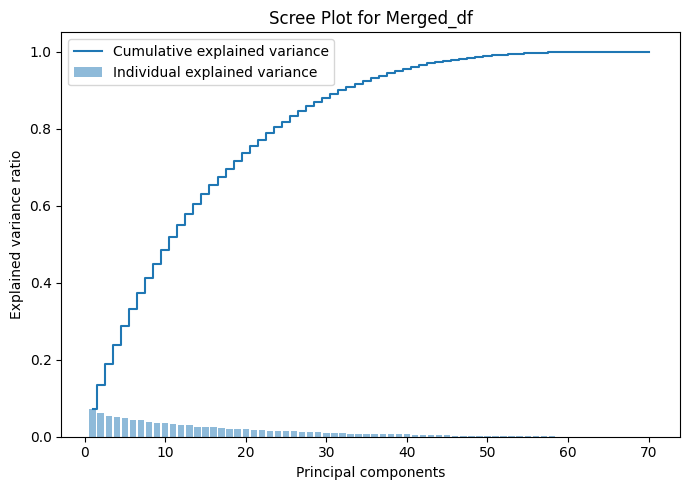

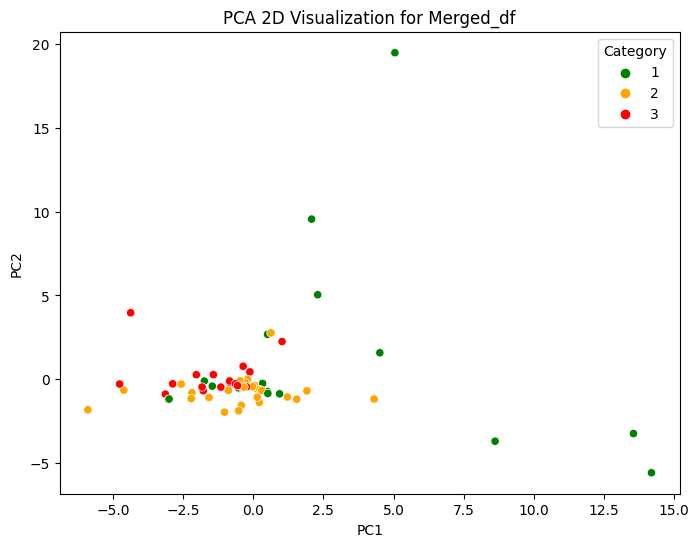

Merged_df_pipeline:


Merged_df_pipeline:
Cross-Validation MAE Scores for RF: [0.6675, 0.7645, 0.4855, 0.3055, 0.5891]
Average MAE for RF: 0.5624
Mean Squared Error: 0.2942
Root Mean Squared Error: 0.5424
Mean Absolute Error: 0.4186
Feature Importance by RF:      Features  Importance
11        549      0.3503
98        270      0.0582
47        110      0.0472
106       323      0.0458
59        140      0.0440
3         526      0.0429
136       470      0.0408
6          23      0.0270
140       491      0.0253
82        214      0.0247
48        625      0.0203
108       334      0.0146
133       456      0.0139
20        566      0.0137
68        687      0.0126
94        250      0.0121
53        634      0.0113
43        614      0.0105
132       455      0.0095
87        229      0.0092
83        727      0.0086
143       503      0.0085
4         529      0.0080
115       871      0.0076
37         92      0.0073
Merged_df_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.4545, 0.5455, 0.6364, 0.7273]
Average F1-Score: 0.5894
Precision: [0.4826, 0.2273, 0.4091, 0.7121, 0.7636]
Average Precision: 0.5189
Recall: [0.5833, 0.4545, 0.5455, 0.6364, 0.7273]
Average Recall: 0.5894
F1-Score: [0.511, 0.303, 0.4615, 0.6228, 0.7273]
Average F1-Score: 0.5251

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.44      0.57      0.50         7
           3       0.33      0.25      0.29         4

    accuracy                           0.43        14
   macro avg       0.43      0.38      0.40        14
weighted avg       0.42      0.43      0.42        14


Feature Importance:
     Features  Importance
11        549      0.0763
140       491      0.0524
47        110      0.0477
106       323      0.0386
3         526      0.0363
..        ...         ..

In [423]:
# Aply pipeline for visual results
results_Merged_df_pca = pca_pipeline(Merged_df, 'Category', n_components=2, dataset_name='Merged_df')

# Apply the pipeline for numerical results
Merged_df_pipeline, df_pca_influence_Merged_df, explained_variance_Merged_df, n_components = apply_pipeline_pca(Merged_df, "Merged_df", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Merged_df.head(10), explained_variance_Merged_df.head(10))

# Apply pipeline Regression
Merged_df_pipeline_reg, importances_reg_Merged_df= apply_pipeline_regressor(Merged_df, "Merged_df")
# Apply the pipeline Classification
Merged_df_pipe_class, importances_class_Merged_df, Merged_df_feature_scores = apply_classification_pipeline_classif(Merged_df, "Merged_df")

### Merged_df Discussion:
**Merged_df pipeline Regression**:
High variance in MAE scores: [0.8136, 0.5479, 0.3764, 0.3979, 0.5936]. Average MAE: 0.5459. This inconsistency suggests unstable model performance
Poor PCA plot and variance explanation could indicate a high dimensionality issues and or a lack of clear separation between classes
**Merged_df pipeline Classification**:
Consistent Cross-Validation Accuracy: 0.9286 (always the same) Suggests potential data leakage or overfitting. Indicates the model might not be truly generalizing
High precision and recall for most classes
Perfect accuracy for Class 1 and Class 2
Slightly lower performance for Class 3

# 8. Preselection Merged_selected and Influencers_uniques_selected as a function of Influence and Importance

In [424]:
def extract_top_features(df_pca_influence, importances_reg, importances_class, input_df=None, n_features=10):
    """
    Extract top features using actual pipeline results

    Parameters:
    df_pca_influence: PCA influence scores from apply_pipeline_pca
    importances_reg: Feature importance from apply_pipeline_regressor
    importances_class: Feature importance from apply_classification_pipeline_classif
    input_df: Original dataframe for feature selection (optional)
    n_features: Number of top features to select (default=10)
    """
    # Extract scores from actual pipeline results
    pca_scores = pd.Series(df_pca_influence['Influence'].values,
                          index=df_pca_influence['Features'].values.astype(int))

    reg_scores = pd.Series(importances_reg['Importance'].values,
                          index=importances_reg['Features'].values.astype(int))

    class_scores = pd.Series(importances_class['Importance'].values,
                          index=importances_class['Features'].values.astype(int))

    # Normalize scores
    pca_scores_norm = pca_scores / pca_scores.sum()
    reg_scores_norm = reg_scores / reg_scores.sum()
    class_scores_norm = class_scores / class_scores.sum()

    #Calculate category-specific scores for each feature
    category_scores ={}
    for feature in pca_scores.index:
        feature_scores ={}
        for category in [1,2,3]:
            score = calculate_category_scores(feature, input_df, category)
            feature_scores[f'cat_{category}_score']= score
        category_scores[feature] = feature_scores

    # Create comparison DataFrame with pipeline results
    feature_comparison = pd.DataFrame({
        'PCA_Score': pca_scores_norm,
        'Regression_Score': reg_scores_norm,
        'Classification_Score': class_scores_norm
    })
    #Add and normalise category scores
    for cat in [1,2,3]:
        col = f'Category_{cat}_Score'
        feature_comparison[col] = feature_comparison.index.map(
            lambda x: category_scores[x][f'cat_{cat}_score'])
        feature_comparison[col] =  feature_comparison[col] / feature_comparison[col].sum()

    # Ensure index is string type
    feature_comparison.index = feature_comparison.index.astype(str)

    # Combine score with category weighting Calculate combined score
    feature_comparison['combined_score'] = (
        0.2 * feature_comparison['PCA_Score'] +
        0.2 * feature_comparison['Regression_Score'] +
        0.2 * feature_comparison['Classification_Score'] +
        (0.4 * feature_comparison['Category_1_Score'] + 2 * feature_comparison['Category_2_Score'] +
        2 * feature_comparison['Category_3_Score'])/4.4 # nomalising the  cats
    )
    feature_comparison.mean(axis=1)

    # Get top features
    top_features = feature_comparison.nlargest(n_features, 'combined_score').index.tolist()

    # Create reduced dataset if input_df provided
    reduced_df = None
    if input_df is not None:
        selected_columns = ['Category']  + [int(col) for col in top_features]
        reduced_df = input_df[selected_columns]

    return {
        'feature_comparison': feature_comparison,
        'top_features': top_features,
        'reduced_df': reduced_df,
        'category_scores': pd.DataFrame(category_scores).T
    }

## 8.1. Influencers_uniques_selected: Top twenty Influencers_uniques Features
Calling the function to select features for influence and importance to get the top ten for Influencers_uniques

In [425]:
print(*Influencers_uniques.columns.tolist())

Category 725 871 214 351 23 91 863 526 584 712 625 864 678 565 408 334 549 375 471 229 541 494 201 342 410 799


In [426]:
# Extract top features and create reduced dataset
results_influencers_uniques = extract_top_features(df_pca_influence_Influencers_uniques , importances_reg_Influencers_uniques ,
                                                    importances_class_Influencers_uniques, Influencers_uniques, n_features=20)
# Access results
feature_comparison_influencers_uniques  = results_influencers_uniques ['feature_comparison']
top_features_influencers_uniques  = results_influencers_uniques ['top_features']
Influencers_uniques_selected = results_influencers_uniques ['reduced_df']

# Print top features if needed
print("\nTop features across all methods:")
print(feature_comparison_influencers_uniques.sort_values('combined_score', ascending=False).head(10))
print("\nSelected features:", (top_features_influencers_uniques))


Top features across all methods:
     PCA_Score  Regression_Score  Classification_Score  Category_1_Score  \
526     0.0522            0.1998                0.1491            0.0000   
863     0.0492            0.0466                0.0784            0.0000   
549     0.0460            0.5109                0.1340            0.3106   
471     0.0457            0.0027                0.0198            0.0000   
91      0.0473            0.0209                0.0787            0.0000   
584     0.0498            0.0003                0.0149            0.0000   
351     0.0523            0.0140                0.0505            0.0000   
408     0.0452            0.0360                0.0712            0.0000   
864     0.0458            0.0651                0.0783            0.0802   
214     0.0379            0.0243                0.0531            0.0000   

     Category_2_Score  Category_3_Score  combined_score  
526            0.0000            0.5390          0.3252  
863          

## 8.2. Results Influencers_uniques_selected:   Pipelines for PCA, Regression and Classification

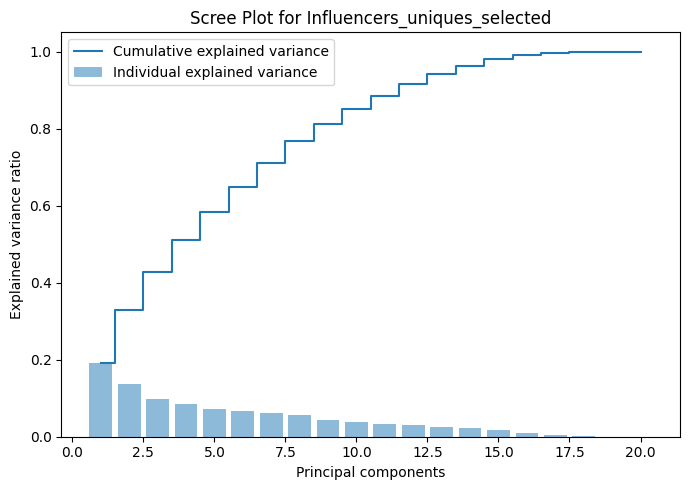

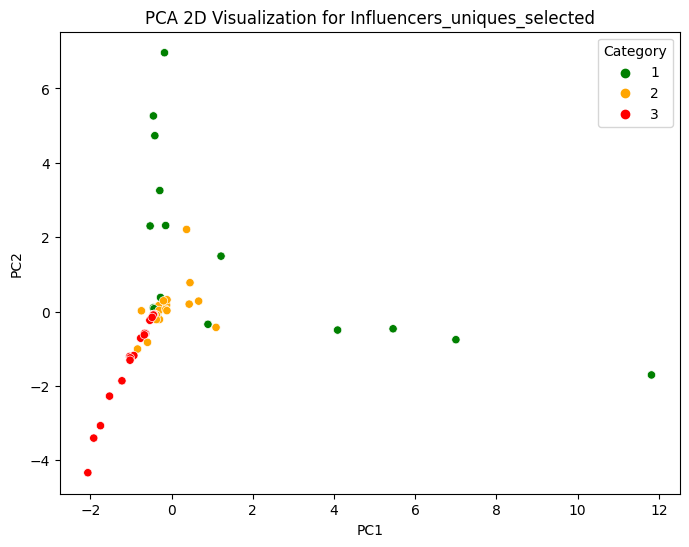

Influencers_uniques_selected_pipeline:


Influencers_uniques_selected_pipeline:
Cross-Validation MAE Scores for RF: [0.3467, 0.2745, 0.1764, 0.1827, 0.1709]
Average MAE for RF: 0.2302
Mean Squared Error: 0.172
Root Mean Squared Error: 0.4147
Mean Absolute Error: 0.2443
Feature Importance by RF:     Features  Importance
2        549      0.5019
0        526      0.1969
8        864      0.0727
1        863      0.0423
7        408      0.0388
4         91      0.0263
10       229      0.0249
9        214      0.0241
12        23      0.0183
13       625      0.0176
6        351      0.0139
14       565      0.0120
16       334      0.0082
3        471      0.0017
5        584      0.0006
15       725      0.0000
18       678      0.0000
19       201      0.0000
11       375      0.0000
17       712      0.0000
Influencers_uniques_selected_pipeline:
Cross-Validation Metrics:
Accuracy: [0.9167, 0.9091, 0.8182, 0.9091, 0.8182]
Average F1-Score: 0.8743
Precision: [0.9306, 0.9242, 0.8701, 0.9242, 0.8182]
Average Precision: 0.8935
R

In [427]:
# Aply pipeline for visual results
results_Influencers_uniques_selected_pca = pca_pipeline(Influencers_uniques_selected, 'Category', n_components=2, dataset_name='Influencers_uniques_selected')

# Apply the pipeline for numerical results
Influencers_uniques_selected_pipeline, df_pca_influence_Influencers_uniques_selected, explained_variance_Influencers_uniques_selected, n_components = apply_pipeline_pca(Influencers_uniques_selected, "Influencers_uniques_selected", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_uniques_selected.head(10), explained_variance_Influencers_uniques_selected.head(10))

# Apply pipeline Regression
Influencers_uniques_selected_pipeline_reg, importances_reg_Influencers_uniques_selected= apply_pipeline_regressor(Influencers_uniques_selected, "Influencers_uniques_selected")
# Apply the pipeline Classification
Influencers_uniques_selected_pipe_class, importances_class_Influencers_uniques_selected, Influencers_uniques_selected_feature_scores = apply_classification_pipeline_classif(Influencers_uniques_selected, "Influencers_uniques_selected")

## 8.3. Merged_selected: Top ten Merged_df Features
Calling the function to select features for influence and importance to get the top ten for Merged_df

In [428]:
# Extract top features and create reduced dataset
results_Merged = extract_top_features(df_pca_influence_Merged_df, importances_reg_Merged_df, importances_class_Merged_df, Merged_df, n_features=10)

# Access results
feature_comparison = results_Merged ['feature_comparison']
top_features = results_Merged ['top_features']
Merged_selected = results_Merged ['reduced_df']

# Print top features if needed
print("\nTop features across all methods:")
print(feature_comparison.sort_values('combined_score', ascending=False).head(10))
print("\nSelected features:", (top_features))


Top features across all methods:
     PCA_Score  Regression_Score  Classification_Score  Category_1_Score  \
238     0.0081            0.0005                0.0034            0.0000   
201     0.0090            0.0000                0.0006            0.0000   
549     0.0047            0.3503                0.0763            0.0000   
211     0.0090            0.0000                0.0000            0.0000   
578     0.0075            0.0000                0.0004            0.0000   
680     0.0086            0.0000                0.0000            0.0000   
649     0.0088            0.0000                0.0001            0.0000   
541     0.0046            0.0004                0.0000            0.4869   
704     0.0079            0.0017                0.0019            0.0000   
110     0.0088            0.0472                0.0477            0.0000   

     Category_2_Score  Category_3_Score  combined_score  
238            0.9609            0.0000          0.4392  
201          

## 8.4. Results Merged_selected:  Pipelines for PCA, Regression and Classification

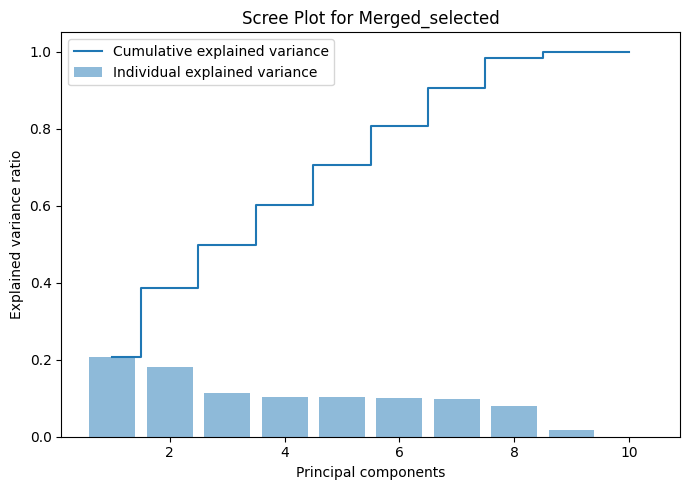

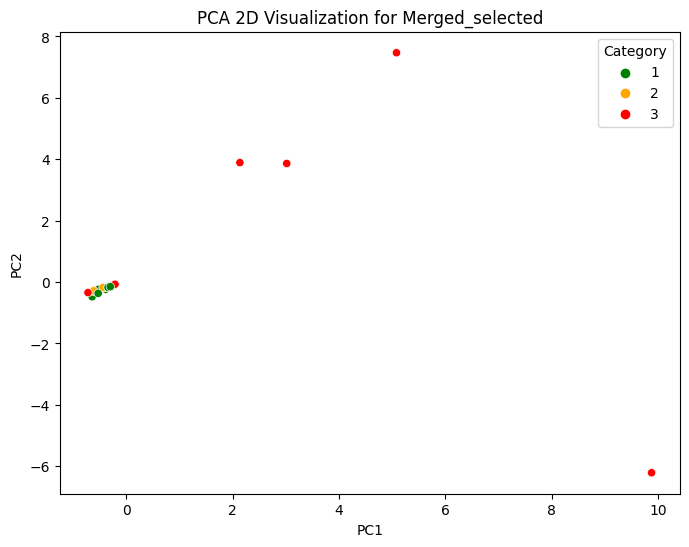

Merged_selected_pipeline:


Merged_selected_pipeline:
Cross-Validation MAE Scores for RF: [0.6556, 0.784, 0.4918, 0.3954, 0.5685]
Average MAE for RF: 0.5791
Mean Squared Error: 0.4605
Root Mean Squared Error: 0.6786
Mean Absolute Error: 0.5815
Feature Importance by RF:    Features  Importance
2       549      0.5924
9       110      0.3418
8       704      0.0340
7       541      0.0095
0       238      0.0075
6       649      0.0061
5       680      0.0032
4       578      0.0025
3       211      0.0015
1       201      0.0015
Merged_selected_pipeline:
Cross-Validation Metrics:
Accuracy: [0.25, 0.1818, 0.9091, 0.7273, 0.4545]
Average F1-Score: 0.5045
Precision: [0.2639, 0.2121, 0.9242, 0.7803, 0.4182]
Average Precision: 0.5197
Recall: [0.25, 0.1818, 0.9091, 0.7273, 0.4545]
Average Recall: 0.5045
F1-Score: [0.2543, 0.1917, 0.9041, 0.7007, 0.4343]
Average F1-Score: 0.497

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [2 3 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

In [429]:
# Aply pipeline for visual results
Merged_selected_pca = pca_pipeline(Merged_selected, 'Category', n_components=2, dataset_name='Merged_selected')

# Apply the pipeline for numerical results
Merged_selected_pipeline, df_pca_influence_Merged_selected, explained_variance, n_components = apply_pipeline_pca(Merged_selected,
                                                         "Merged_selected", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Merged_selected.head(10), explained_variance.head(10))

# Apply pipeline Regression
Merged_selected_pipeline_reg, importances_reg= apply_pipeline_regressor(Merged_selected, "Merged_selected")
# Apply the pipeline Classification
Merged_selected_pipe_class, importances_class_Merged_selected, Merged_selected_feature_scores = apply_classification_pipeline_classif(Merged_selected, "Merged_selected")

Actually 30 features performs worse than 20 features for Merged_selected.
30 features:    MAE: 0.5157, Accuracy: 0.6606,,Average Precision: 0.5875
20 features:    MAE: 0.512 (better), Accuracy: 0.7152 (much better), Average Precision: 0.7075 (much better)
10 features:    MAE: 0.5193 (similar), Accuracy: 0.75 (better), Average Precision: 0.7859 (better), MSE: 0.2926 (better)

## 8.5. Influencers Results
Interestingly after the unifying of Influencers_OLS with uniques to produce Influencers_uniques, posterior processing to have the most important genera by using extract_top_features function, I compared the features found and they are exactly the same as Influencers_OLS with the new implementation of discriminating by category in section 8.

In [430]:
print(*Influencers_OLS.columns.tolist())
print(*Influencers_uniques_selected.columns.tolist())

Category 725 871 214 351 23 91 863 526 584 712 625 864 678 565 408 334 549 375 471 229
Category 526 863 549 471 91 584 351 408 864 214 229 375 23 625 565 725 334 712 678 201


# 9. Manually prunning the features according to importance and influence

## 9.1. old_new dataframes creation
From manually prunned features according to importance and influence results

In [431]:
# Get your top 10 features
selected_oldies = [154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625]

# Create final reduced dataset
old_new = original[["Category"] + selected_oldies]

## 9.2. old_new Results:  Pipelines for PCA, Regression and Classification

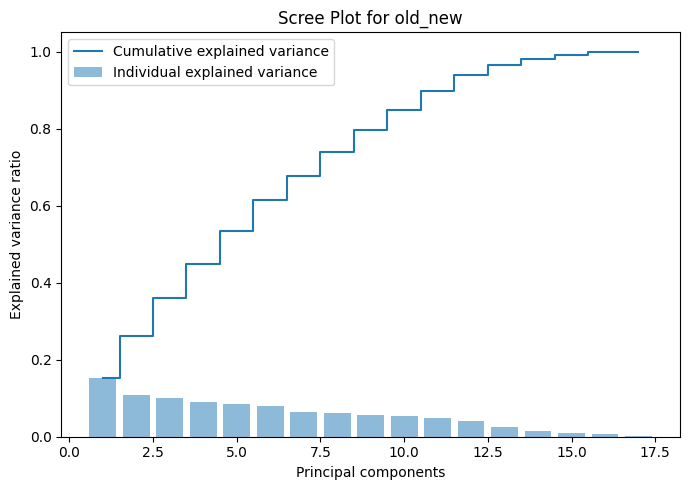

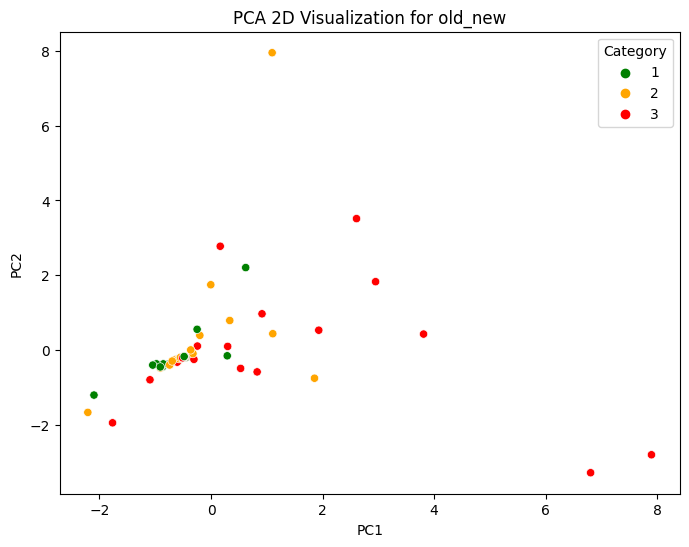

old_new_pipeline:


old_new_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.6367, 0.5658, 0.4059, 0.4425]
Average MAE for RF: 0.5463
Mean Squared Error: 0.3187
Root Mean Squared Error: 0.5645
Mean Absolute Error: 0.4627
Feature Importance by RF:     Features  Importance
2        214      0.1541
6        354      0.1425
3        229      0.1033
5        351      0.1012
10       565      0.0974
7        408      0.0843
4        334      0.0755
16       625      0.0739
12       583      0.0488
14       606      0.0429
13       584      0.0211
11       581      0.0180
15       621      0.0136
0        154      0.0130
9        512      0.0059
8        497      0.0041
1        201      0.0002
old_new_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.6364, 0.6364, 0.5455, 0.8182]
Average F1-Score: 0.644
Precision: [0.5833, 0.798, 0.4659, 0.3961, 0.8667]
Average Precision: 0.622
Recall: [0.5833, 0.6364, 0.6364, 0.5455, 0.8182]
Average Recall: 0.644
F1-Score: [0.5768, 0.5974, 0.5315, 0.4589, 0.8096]
Average F1-Score: 0.5948

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.56      0.71      0.63         7
           3       0.67      0.50      0.57         4

    accuracy                           0.57        14
   macro avg       0.57      0.52      0.53        14
weighted avg       0.58      0.57      0.56        14


Feature Importance:
    Features  Importance
2        214      0.1125
10       565      0.1115
5        351      0.1068
3        229      0.0970
6        354      0.0948
7        408      0.0826
16     

In [432]:
# Aply pipeline for visual results
old_new_pca = pca_pipeline(old_new, 'Category', n_components=2, dataset_name='old_new')

# Apply the pipeline for numerical results
old_new_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(old_new, "old_new", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
old_new_pipeline_reg, importances_reg= apply_pipeline_regressor(old_new, "old_new")
# Apply the pipeline Classification
old_new_pipe_class, importances_class_old_new, old_new_feature_scores = apply_classification_pipeline_classif(old_new, "old_new")

# 10.  Cluster Analysis
## 10.1.  script - Pipeline K-Means, DBSCAN, and GMM

In [433]:
def clustering_pipeline_all(df, pca_data_name='pca_data', n_clusters=5, eps=0.3, min_samples=3, n_components=3):
    """
    Performs clustering using K-Means, DBSCAN, and GMM with PCA for dimensionality reduction.

    Parameters:
    - df: Input DataFrame (features only, no labels).
    - n_clusters: Number of clusters for K-Means and GMM (default=5).
    - eps: DBSCAN's epsilon parameter (default=0.5).
    - min_samples: Minimum samples for DBSCAN (default=5).
    - n_components: Number of components for PCA (default=2).

    Returns:
    - results: Dictionary with clustering results for K-Means, DBSCAN, and GMM, as well as PCA data and metrics.
    """
    results = {}

    # Separate true labels
    true_labels = df['Category']

    df = df.drop(columns=['Category'])  # Drop any non-numeric columns

    # Step 1: Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Step 2: PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # Calculate explained variance and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Clustering
    results = {
        'pca': pca,
        'pca_data_name': pca_data,
        'scaled_data': scaled_data,
        'explained_variance': explained_variance_ratio,
        'cumulative_variance': cumulative_variance_ratio
    }

    # Step 3: K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    kmeans_silhouette = silhouette_score(pca_data, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(pca_data, kmeans_labels)
    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

    results['kmeans'] = {
        'cluster_labels': kmeans_labels,
        'silhouette_score': kmeans_silhouette,
        'davies_bouldin_score': kmeans_db_score,
        'adjusted_rand_score': kmeans_ari
    }

    # Step 4: DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Add automatic eps calculation if not provided
    if eps is None:
        nbrs = NearestNeighbors(n_neighbors=2).fit(scaled_data)
        distances, _ = nbrs.kneighbors(scaled_data)
        eps = np.percentile(distances[:, 1], 90)

    dbscan_labels = dbscan.fit_predict(pca_data)
    valid_indices = dbscan_labels != -1
    if len(set(dbscan_labels[valid_indices])) > 1:
        dbscan_silhouette = silhouette_score(pca_data[valid_indices], dbscan_labels[valid_indices])
        dbscan_db_score = davies_bouldin_score(pca_data[valid_indices], dbscan_labels[valid_indices])
    else:
        dbscan_silhouette = None
        dbscan_db_score = None
    dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)


    results['dbscan'] = {
        'cluster_labels': dbscan_labels,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_score': dbscan_db_score,
        'adjusted_rand_score': dbscan_ari
    }

    # Step 5: GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_db_score = davies_bouldin_score(pca_data, gmm_labels)
    gmm_ari = adjusted_rand_score(true_labels, gmm_labels)

    results['gmm'] = {
        'cluster_labels': gmm_labels,
        'silhouette_score': gmm_silhouette,
        'davies_bouldin_score': gmm_db_score,
        'adjusted_rand_score': gmm_ari,
        'bic_score': gmm.bic(pca_data),
        'aic_score': gmm.aic(pca_data)
    }

    # Addind normalized metrics
    for method in ['kmeans', 'dbscan', 'gmm']:
        labels = results[method]['cluster_labels']
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            sizes = np.bincount(valid_labels)
        else:
            sizes = np.bincount(labels)
        results[method]['normalized_sizes'] = sizes / len(labels)

    # Store PCA-transformed data with the specified name
    results[pca_data_name] = pca_data

    return results

## 10.2. Script - Visualisation K-means, DBSCAN AND GaussianMixture

In [434]:
def visualize_clustering_results(results, title_prefix=''):
    """
    Visualize clustering results with multiple plots and metrics

    Parameters:
    - results: Dictionary containing clustering results from clustering_pipeline_all function
    - title_prefix: Optional prefix for plot titles
    """
    # Extract PCA data
    pca_data = results[list(filter(lambda x: x.startswith('pca_'), results.keys()))[0]]

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix} Clustering Results Visualization', fontsize=16)

    # plot style settings for better visibility
    plt.style.use('default')

    # Color palettes for different clustering methods
    color_palettes = [
        ['#00CC00', '#FFA500', '#FF0000', '#0000FF', '#9932CC'],  # For K-means
        ['#00CC00', '#FFA500', '#FF0000', '#0000FF', '#9932CC'],  # For GMM 
        ['#808080', '#0000FF']  # For DBSCAN (keeping grey for noise)
    ]

    # Add grid for better readability
    for ax in axs.flat:
        ax.grid(True, alpha=0.3)

    # Clustering methods and their labels
    clustering_methods = [
        ('K-Means', results['kmeans']['cluster_labels'], color_palettes[0]),
        ('Gaussian Mixture Model', results['gmm']['cluster_labels'], color_palettes[2]),
        ('DBSCAN', results['dbscan']['cluster_labels'], color_palettes[1])
    ]

    # Scatter plots for each clustering method
    for idx, (method_name, labels, color_palette) in enumerate(clustering_methods):
        row = idx // 2
        col = idx % 2

        # Handle DBSCAN noise points
        if method_name == 'DBSCAN':
            noise_mask = labels == -1
            cluster_mask = labels != -1

            # Plot noise points
            if np.any(noise_mask):
                axs[row, col].scatter(
                    pca_data[noise_mask, 0],
                    pca_data[noise_mask, 1],
                    c='gray',
                    alpha=0.5,
                    label='Noise'
                )

            # Plot clustered points
            unique_labels = np.unique(labels[cluster_mask])
            for label in unique_labels:
                mask = (labels == label) & cluster_mask
                axs[row, col].scatter(
                    pca_data[mask, 0],
                    pca_data[mask, 1],
                    c=[color_palette[label]],
                    label=f'Cluster {label}'
                )
        else:
            # For K-Means and GMM
            unique_labels = np.unique(labels)
            for label in unique_labels:
                mask = labels == label
                axs[row, col].scatter(
                    pca_data[mask, 0],
                    pca_data[mask, 1],
                    c=[color_palette[label % len(color_palette)]],
                    label=f'Cluster {label}'
                )

        axs[row, col].set_title(f'{method_name} Clustering')
        axs[row, col].set_xlabel('First Principal Component')
        axs[row, col].set_ylabel('Second Principal Component')
        axs[row, col].legend()

    plt.tight_layout()
    plt.show()

def print_clustering_metrics(results):
    """
    Print detailed clustering metrics for each method

    Parameters:
    - results: Dictionary containing clustering results
    """
    print("\n=== Clustering Metrics ===")

    # Cluster quality metrics
    def calculate_cluster_quality(labels, data):
        if len(set(labels)) <= 1:
            return None
        # Calculate average intra-cluster distance
        intra_cluster_distances = []
        for label in set(labels):
            if label != -1:  # Skip noise points
                cluster_points = data[labels == label]
                if len(cluster_points) > 1:
                    distances = pdist(cluster_points)
                    intra_cluster_distances.append(np.mean(distances))
        return np.mean(intra_cluster_distances) if intra_cluster_distances else None

    # Metrics for each clustering method
    clustering_methods = ['kmeans', 'dbscan', 'gmm']

    for method in clustering_methods:
        print(f"\n{method.upper()} Clustering Metrics:")
        labels = results[method]['cluster_labels']
        silhouette = results[method]['silhouette_score']
        db_score = results[method]['davies_bouldin_score']
        ari = results[method].get('adjusted_rand_score', 'N/A')  # Use 'N/A' if ARI is not available
        quality = calculate_cluster_quality(labels, results['scaled_data'])

        if quality is not None:
            print(f"Average Intra-cluster Distance: {quality:.4f}")
        else:
            print("Average Intra-cluster Distance: N/A")
        print(f"Silhouette Score: {silhouette if silhouette is not None else 'Not applicable'}")
        print(f"Davies-Bouldin Score: {db_score if db_score is not None else 'Not applicable'}")
        print(f"Adjusted Rand Score: {ari}")

        # Count cluster sizes
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            unique_labels = np.unique(valid_labels)
        else:
            unique_labels = np.unique(labels)

        print("\nCluster Sizes:")
        for label in unique_labels:
            if method == 'dbscan' and label == -1:
                count = np.sum(labels == label)
                print(f"Noise Points: {count}")
            else:
                count = np.sum(labels == label)
                print(f"Cluster {label}: {count} points")


    # Print Explained Variance for PCA
    print("\nPCA Explained Variance Ratio:")
    explained_variance = results['explained_variance']
    for i, var in enumerate(explained_variance[:10], 1):
        print(f"PC{i}: {var * 100:.2f}%")
    print(f"Total Variance Explained (first 10 PCs): {np.sum(explained_variance[:10]) * 100:.2f}%")

# 11. Results Cluster Analysis


## 11.1 Clustering original_pca

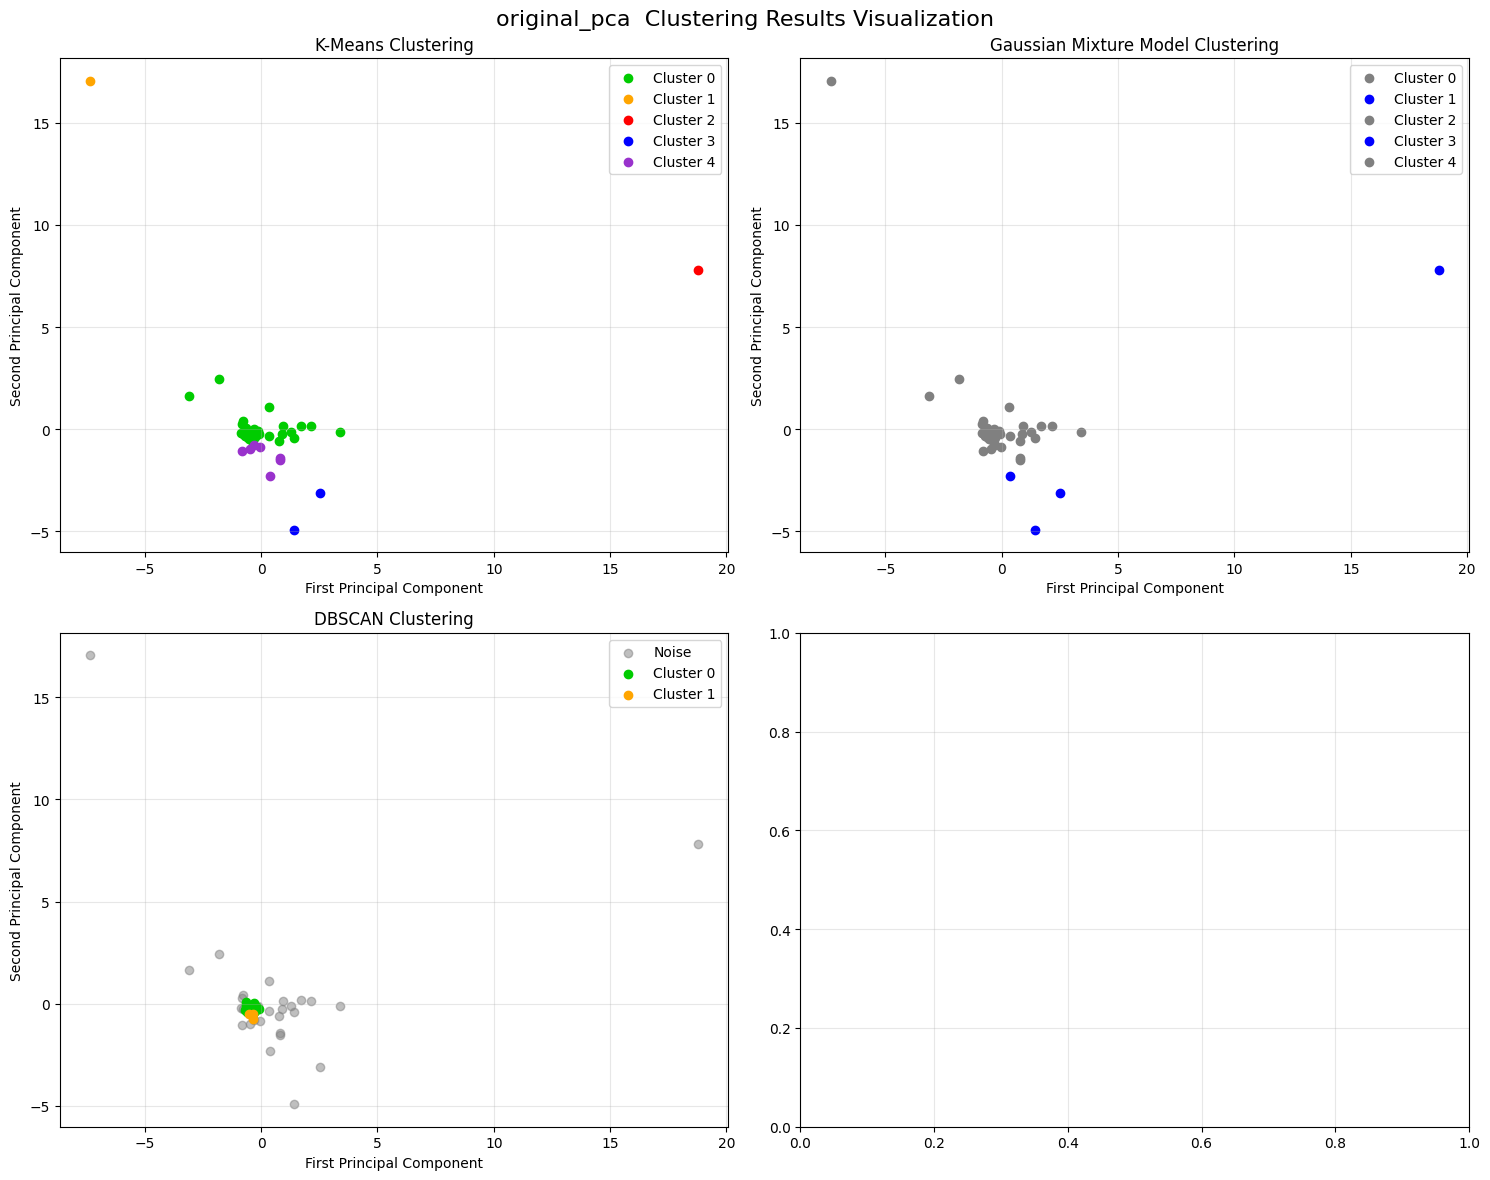


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 12.3633
Silhouette Score: 0.5911749451321849
Davies-Bouldin Score: 0.37978208795887536
Adjusted Rand Score: 0.03334229224244323

Cluster Sizes:
Cluster 0: 59 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 2 points
Cluster 4: 7 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 6.1760
Silhouette Score: 0.6734669989917765
Davies-Bouldin Score: 0.41193939926814716
Adjusted Rand Score: 0.06738197063931607

Cluster Sizes:
Cluster 0: 39 points
Cluster 1: 3 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 11.1983
Silhouette Score: 0.4509032663197122
Davies-Bouldin Score: 0.9120067302795798
Adjusted Rand Score: 0.09661426242242933

Cluster Sizes:
Cluster 0: 14 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 3 points
Cluster 4: 51 points

PCA Explained Variance Ratio:
PC1: 13.40%
PC2: 11.84%
PC3: 10.09%
Total Variance Explained (first 10 PCs): 35.33%


In [435]:
# Running pipeline
results_original_pca_cluster  = clustering_pipeline_all(original_pca,  pca_data_name='pca_data_original_pca ',
                                                  n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_original_pca_cluster, title_prefix='original_pca ')
print_clustering_metrics(results_original_pca_cluster )

## 11.2 Clustering uniques_pca

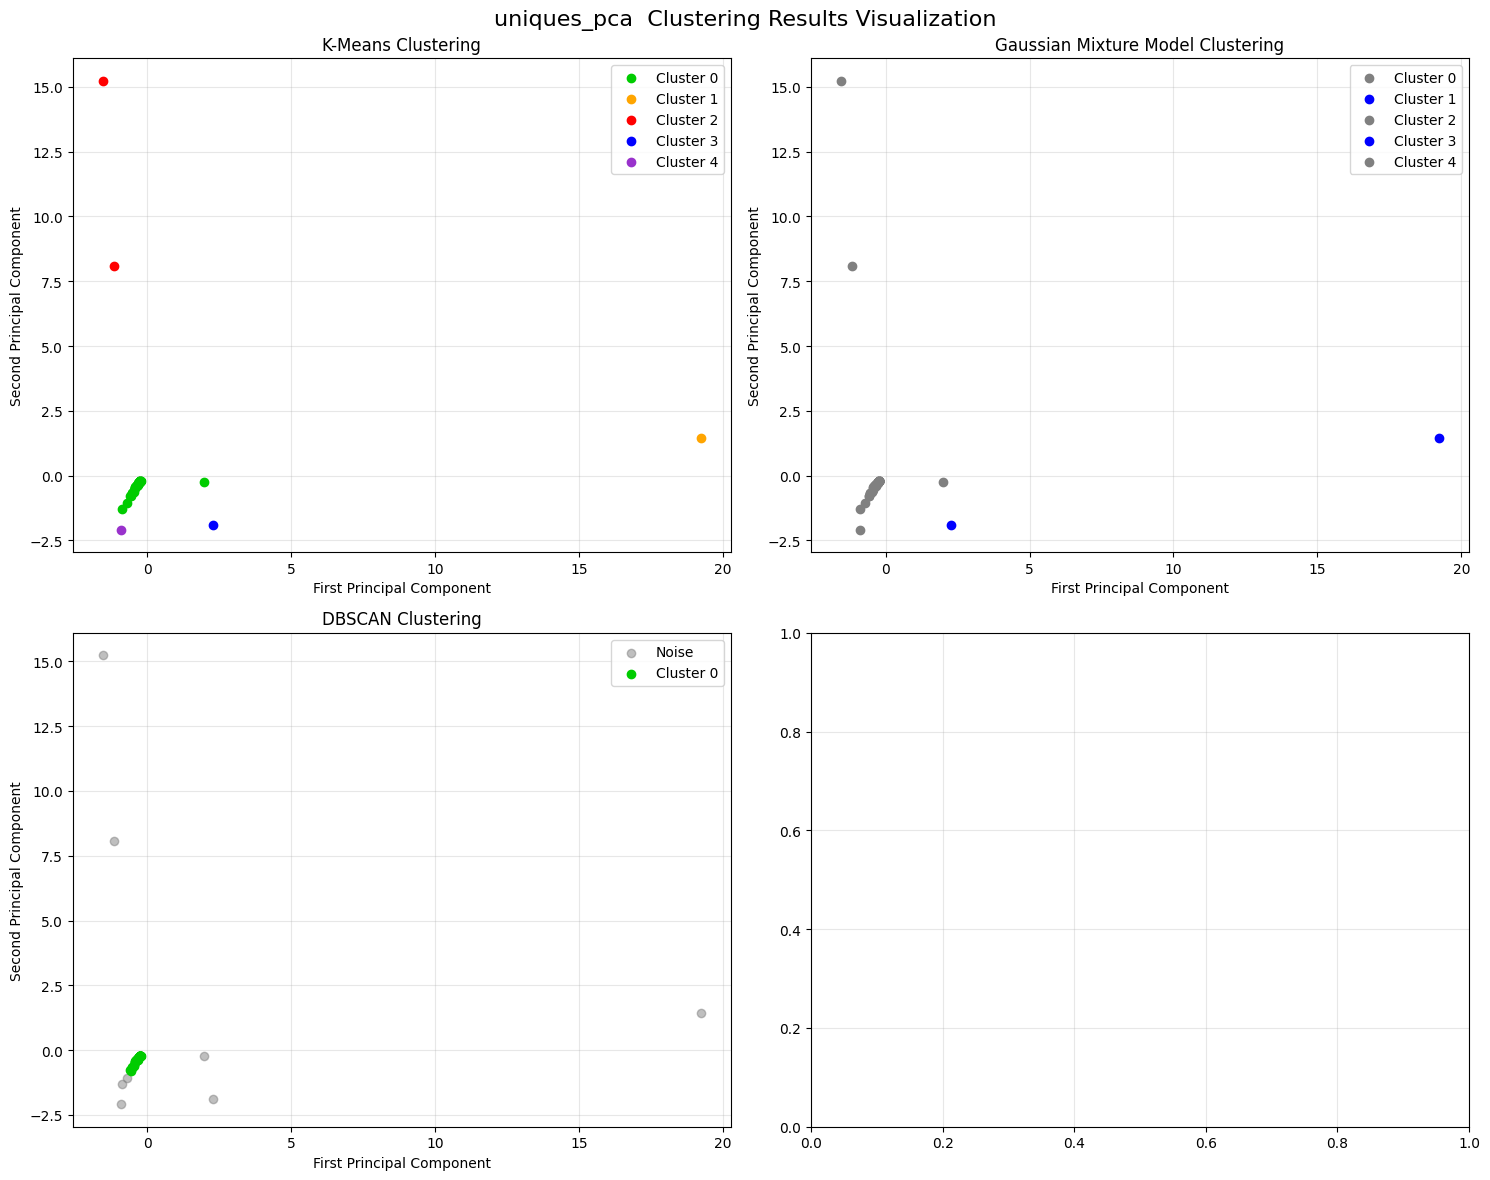


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 13.9176
Silhouette Score: 0.8969217217447202
Davies-Bouldin Score: 0.23914178428393065
Adjusted Rand Score: 0.015558814518822014

Cluster Sizes:
Cluster 0: 65 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 1 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 4.5722
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.012555660742228594

Cluster Sizes:
Cluster 0: 62 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 5.7538
Silhouette Score: 0.8934153249099123
Davies-Bouldin Score: 0.029334943757539377
Adjusted Rand Score: 0.0028655323934276018

Cluster Sizes:
Cluster 0: 66 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 11.16%
PC2: 9.06%
PC3: 8.22%
Total Variance Explained (first 10 PCs): 28.44%


In [436]:
# Running pipeline
results_uniques_pca_cluster  = clustering_pipeline_all(uniques_pca,  pca_data_name='pca_data_uniques_pca ',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_uniques_pca_cluster, title_prefix='uniques_pca ')
print_clustering_metrics(results_uniques_pca_cluster )

## 11.3 Clustering uniques23_pca

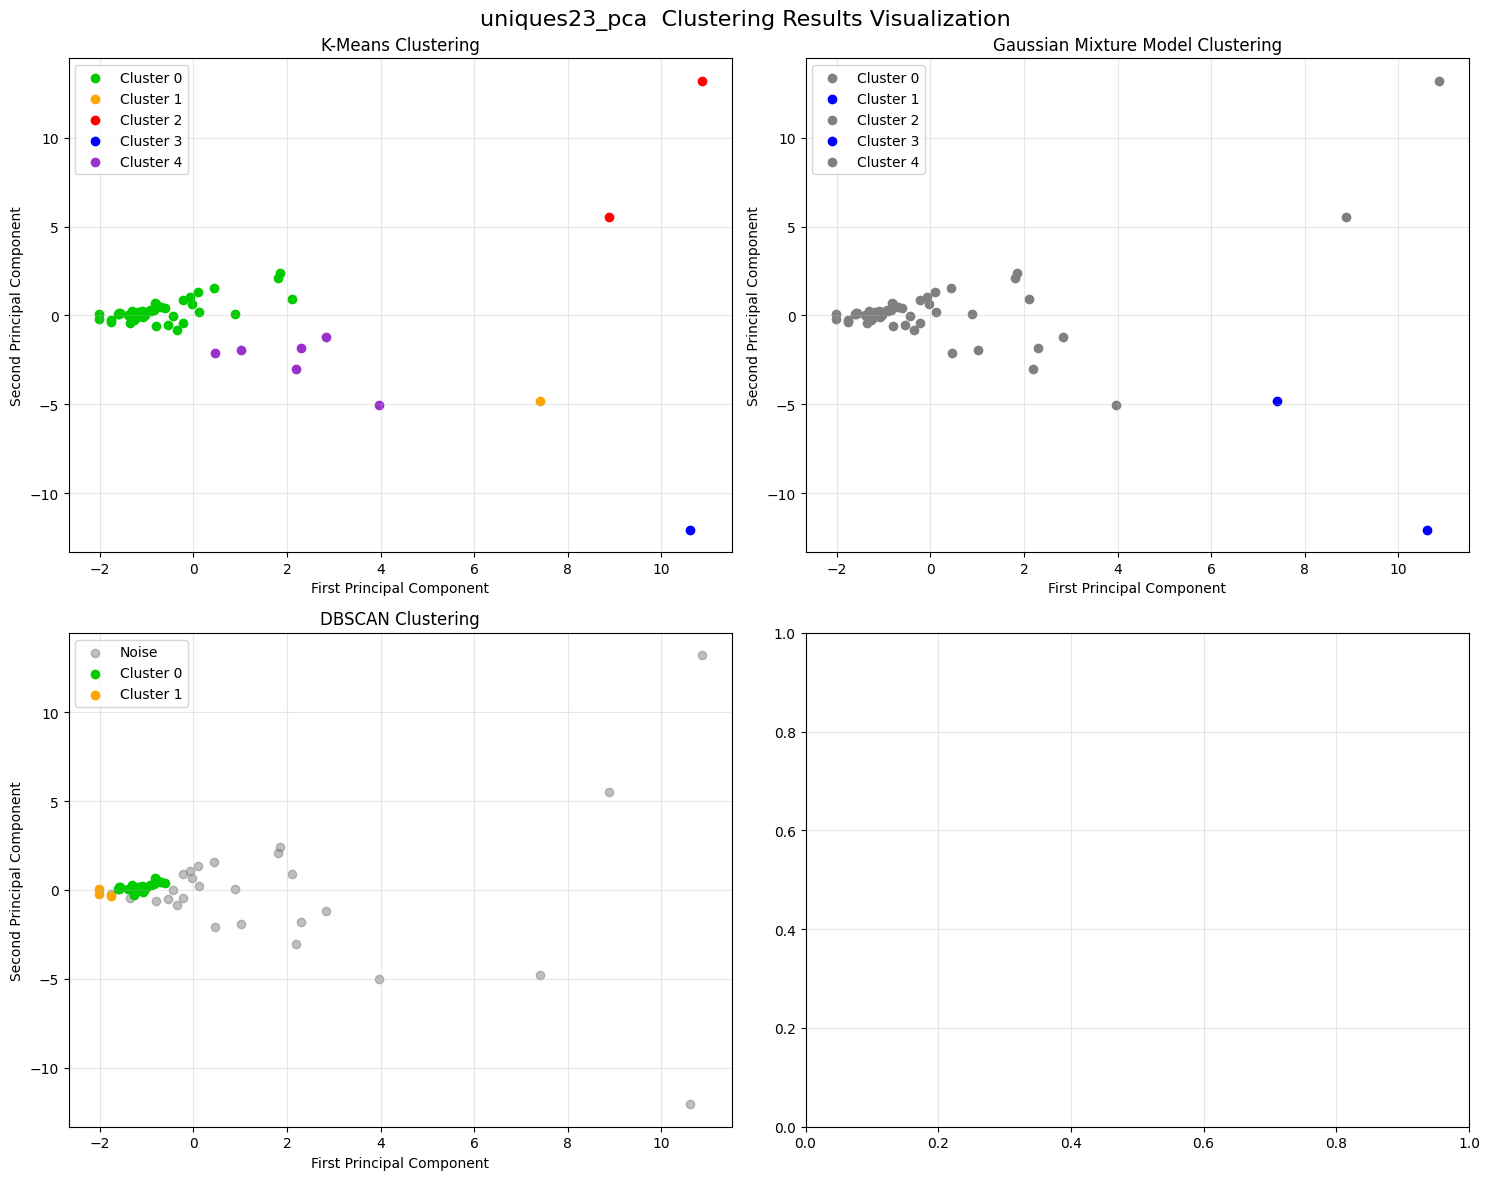


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 13.3686
Silhouette Score: 0.6782960452966972
Davies-Bouldin Score: 0.39125375640053883
Adjusted Rand Score: -0.014026371999247679

Cluster Sizes:
Cluster 0: 60 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 1 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 6.5830
Silhouette Score: 0.5658395164604079
Davies-Bouldin Score: 0.5242766319330228
Adjusted Rand Score: 0.0533660053996948

Cluster Sizes:
Cluster 0: 40 points
Cluster 1: 3 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 12.9854
Silhouette Score: 0.49206765060891117
Davies-Bouldin Score: 0.6168108991371596
Adjusted Rand Score: 0.03255271791336079

Cluster Sizes:
Cluster 0: 51 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 1 points
Cluster 4: 15 points

PCA Explained Variance Ratio:
PC1: 13.86%
PC2: 12.63%
PC3: 11.43%
Total Variance Explained (first 10 PCs): 37.92%


In [437]:
# Running pipeline
results_uniques23_pca_cluster  = clustering_pipeline_all(uniques23_pca,  pca_data_name='pca_data_uniques23_pca ',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_uniques23_pca_cluster, title_prefix='uniques23_pca ')
print_clustering_metrics(results_uniques23_pca_cluster )

## 11.4 Clustering uniques_OLS

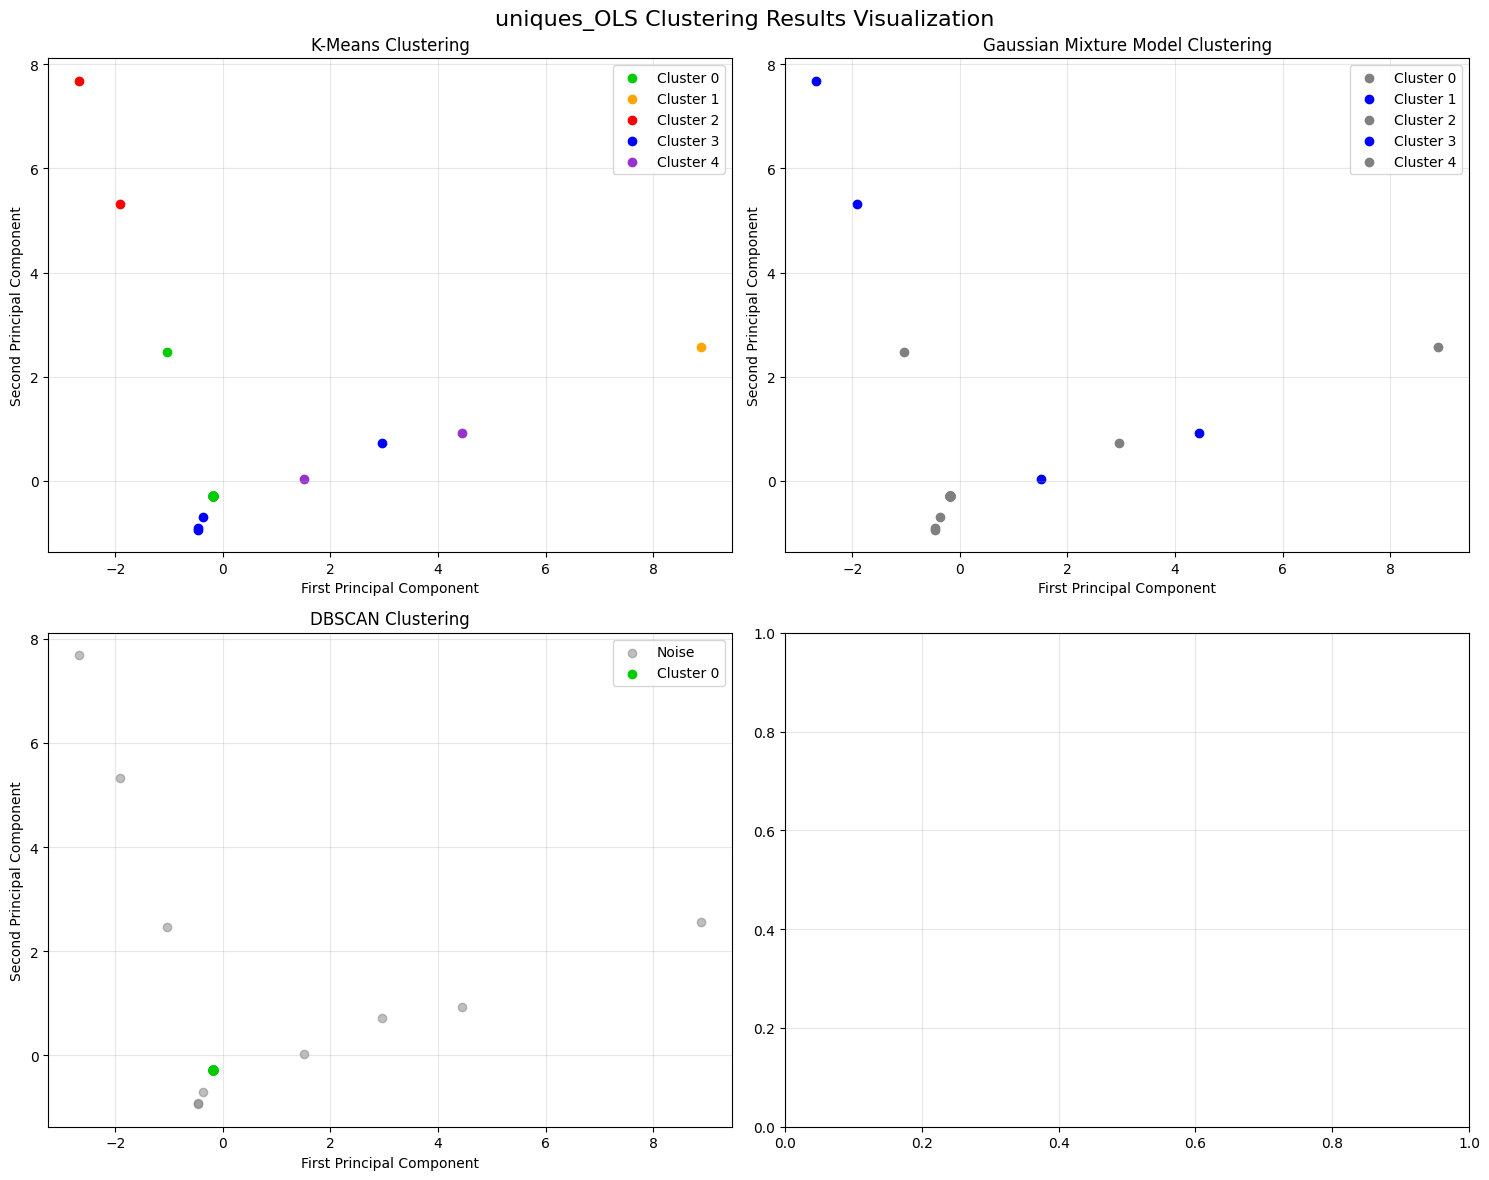


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 3.8231
Silhouette Score: 0.8856460359691911
Davies-Bouldin Score: 0.4729728267522442
Adjusted Rand Score: 0.09750583948868348

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 4 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.0000
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.12245717882444322

Cluster Sizes:
Cluster 0: 60 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 3.8194
Silhouette Score: 0.880888028814838
Davies-Bouldin Score: 0.2564329055117223
Adjusted Rand Score: 0.08179301758998207

Cluster Sizes:
Cluster 0: 64 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 2 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 29.59%
PC2: 25.85%
PC3: 17.19%
Total Variance Explained (first 10 PCs): 72.62%


In [438]:
# Running pipeline
results_uniques_OLS_cluster  = clustering_pipeline_all(uniques_OLS,  pca_data_name='pca_data_uniques_OLS ',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_uniques_OLS_cluster, title_prefix='uniques_OLS')
print_clustering_metrics(results_uniques_OLS_cluster )

## 11.3 Clustering uniques23_OLS

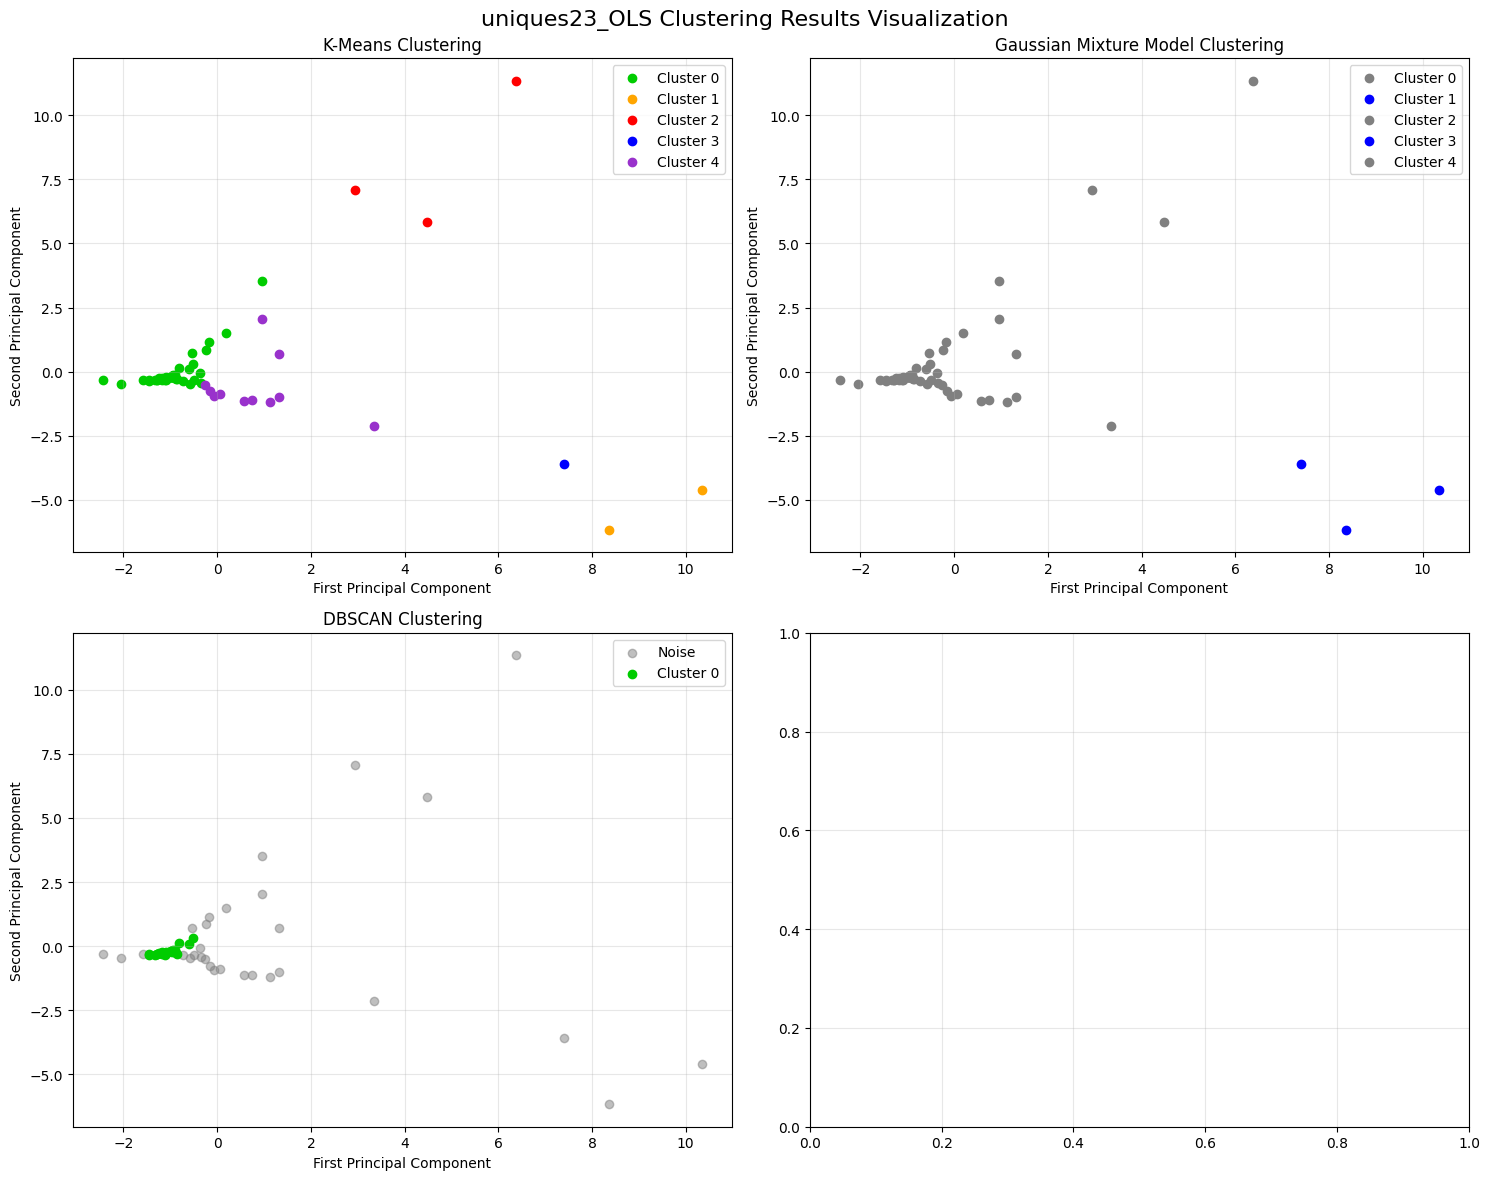


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.6523
Silhouette Score: 0.5800791657329143
Davies-Bouldin Score: 0.5945915493707594
Adjusted Rand Score: 0.1237053228776634

Cluster Sizes:
Cluster 0: 53 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 11 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.2921
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.10193974921578475

Cluster Sizes:
Cluster 0: 39 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.8605
Silhouette Score: 0.5001415176575308
Davies-Bouldin Score: 0.7966694000005543
Adjusted Rand Score: 0.16717194456951323

Cluster Sizes:
Cluster 0: 50 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 14 points

PCA Explained Variance Ratio:
PC1: 19.95%
PC2: 17.05%
PC3: 10.29%
Total Variance Explained (first 10 PCs): 47.28%


In [439]:
# Running pipeline
results_uniques23_OLS_cluster  = clustering_pipeline_all(uniques23_OLS,  pca_data_name='pca_data_uniques23_OLS ',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_uniques23_OLS_cluster, title_prefix='uniques23_OLS')
print_clustering_metrics(results_uniques23_OLS_cluster )

### Discussing  uniques23_OLS (300+ features):
K-means: Silhouette Score of 0.685, Davies-Bouldin of 0.514
Cluster sizes are quite imbalanced (53, 3, 3, 5, 6 points)
PCA explains 37% of variance (19.95% PC1, 17.05% PC2)

## 11.4 Clustering Influencers_OLS

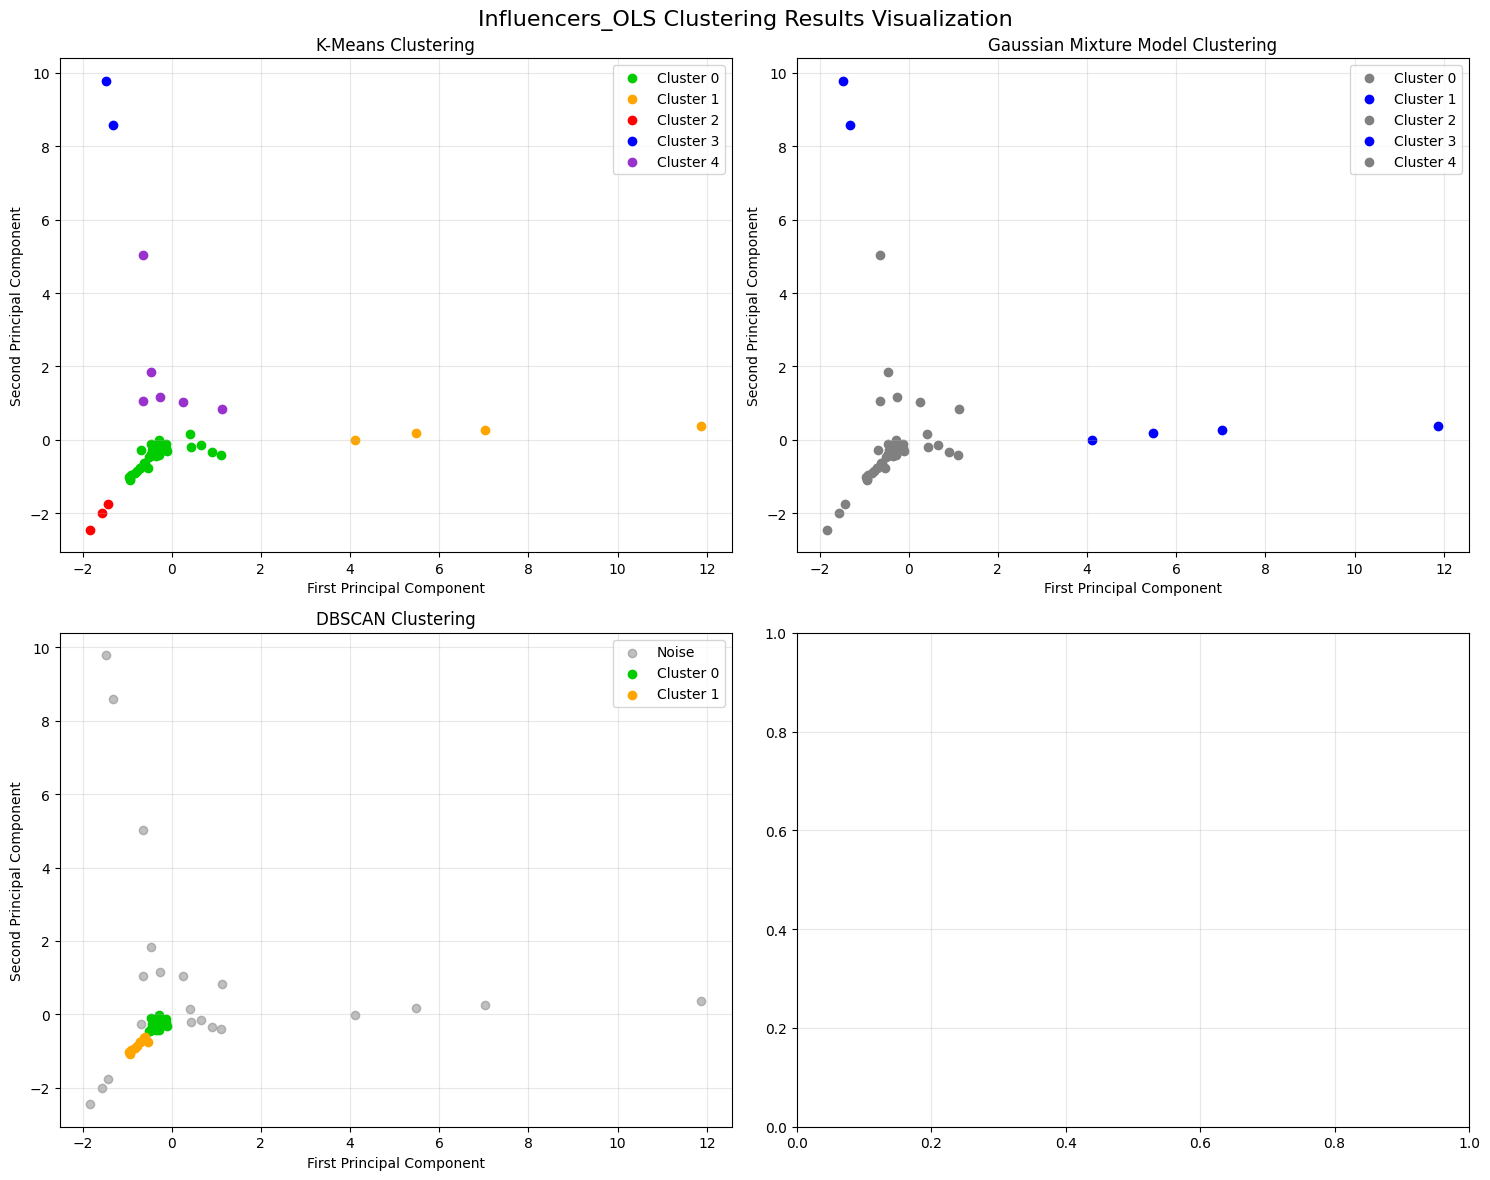


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 6.5819
Silhouette Score: 0.7025339186671572
Davies-Bouldin Score: 0.4637709722541
Adjusted Rand Score: 0.19480498782369216

Cluster Sizes:
Cluster 0: 55 points
Cluster 1: 4 points
Cluster 2: 3 points
Cluster 3: 2 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.6370
Silhouette Score: 0.7714491871190343
Davies-Bouldin Score: 0.38928449014963457
Adjusted Rand Score: 0.20506445185067626

Cluster Sizes:
Cluster 0: 37 points
Cluster 1: 12 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.5819
Silhouette Score: 0.7025339186671572
Davies-Bouldin Score: 0.4637709722541
Adjusted Rand Score: 0.19480498782369216

Cluster Sizes:
Cluster 0: 55 points
Cluster 1: 4 points
Cluster 2: 3 points
Cluster 3: 2 points
Cluster 4: 6 points

PCA Explained Variance Ratio:
PC1: 19.12%
PC2: 16.41%
PC3: 10.92%
Total Variance Explained (first 10 PCs): 46.46%


In [440]:
# Running pipeline
results_Influencers_OLS_cluster = clustering_pipeline_all(Influencers_OLS,  pca_data_name='pca_data_Influencers_OLS_cluster',
                                                    n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_OLS_cluster, title_prefix='Influencers_OLS')
print_clustering_metrics(results_Influencers_OLS_cluster)

### Clustering Influencers_OLS, Discussion
Influencers_OLS:
K-means: Silhouette Score of 0.603, Davies-Bouldin of 0.552
Very imbalanced cluster sizes (1, 53, 3, 3, 10 points)
PCA explains 35.53% of variance

Notice that for PCA visualisation on notebook PCA_RF_FImporance.ipnyb, the same dataset was used, hower the main difference is that there the category label was use to color code the samples, however category was droped and didnt participate on the clustering, it was used just for color coding.
Plots show similar behaviour because the clustering algorithms (K-Means, DBSCAN, GMM) are able to identify the inherent structure in the data and recover groupings that are consistent with the original category information, even though the category column is not provided. it means the clustering methods are effectively capturing the underlying patterns in the data, regardless of whether the category information is explicitly given or not. The consistency between the PCA visualization and the clustering results indicates the data has a clear structure that the algorithms can latch onto.
## 11.5 Clustering OLS_all

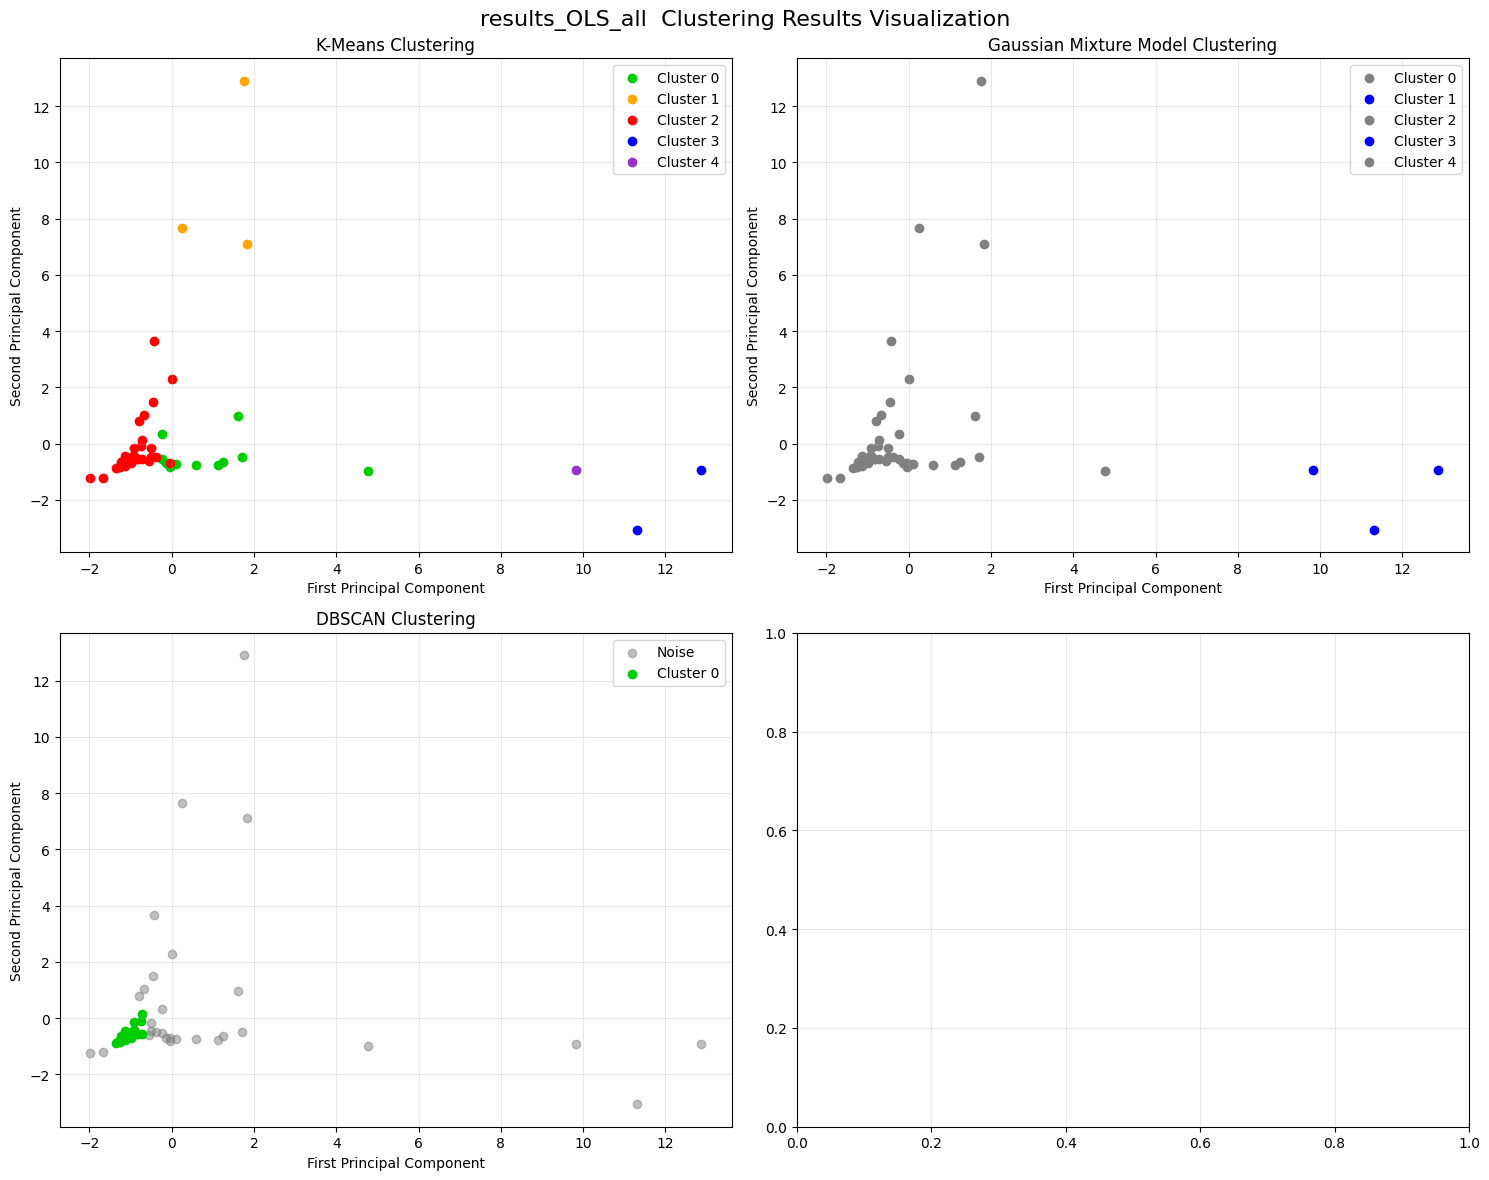


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.3631
Silhouette Score: 0.5903661232204536
Davies-Bouldin Score: 0.5742828917634113
Adjusted Rand Score: 0.18232257312438563

Cluster Sizes:
Cluster 0: 12 points
Cluster 1: 3 points
Cluster 2: 52 points
Cluster 3: 2 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.9273
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.10974827106426456

Cluster Sizes:
Cluster 0: 40 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.0760
Silhouette Score: 0.4653512973058302
Davies-Bouldin Score: 0.7406592816154219
Adjusted Rand Score: 0.12704292439157225

Cluster Sizes:
Cluster 0: 46 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 18 points

PCA Explained Variance Ratio:
PC1: 21.35%
PC2: 14.84%
PC3: 10.66%
Total Variance Explained (first 10 PCs): 46.85%


In [441]:
# Running pipeline
results_OLS_all_cluster = clustering_pipeline_all(OLS_all,  pca_data_name='pca_data_OLS_all',   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_OLS_all_cluster, title_prefix='results_OLS_all ')
print_clustering_metrics(results_OLS_all_cluster)

### OLS_all Discussion
K-means: Silhouette Score of 0.678, Davies-Bouldin of 0.457
Cluster sizes imbalanced (57, 3, 1, 3, 6 points)
PCA explains 36.18% of variance
## 11.6 Clustering Influencers_uniques

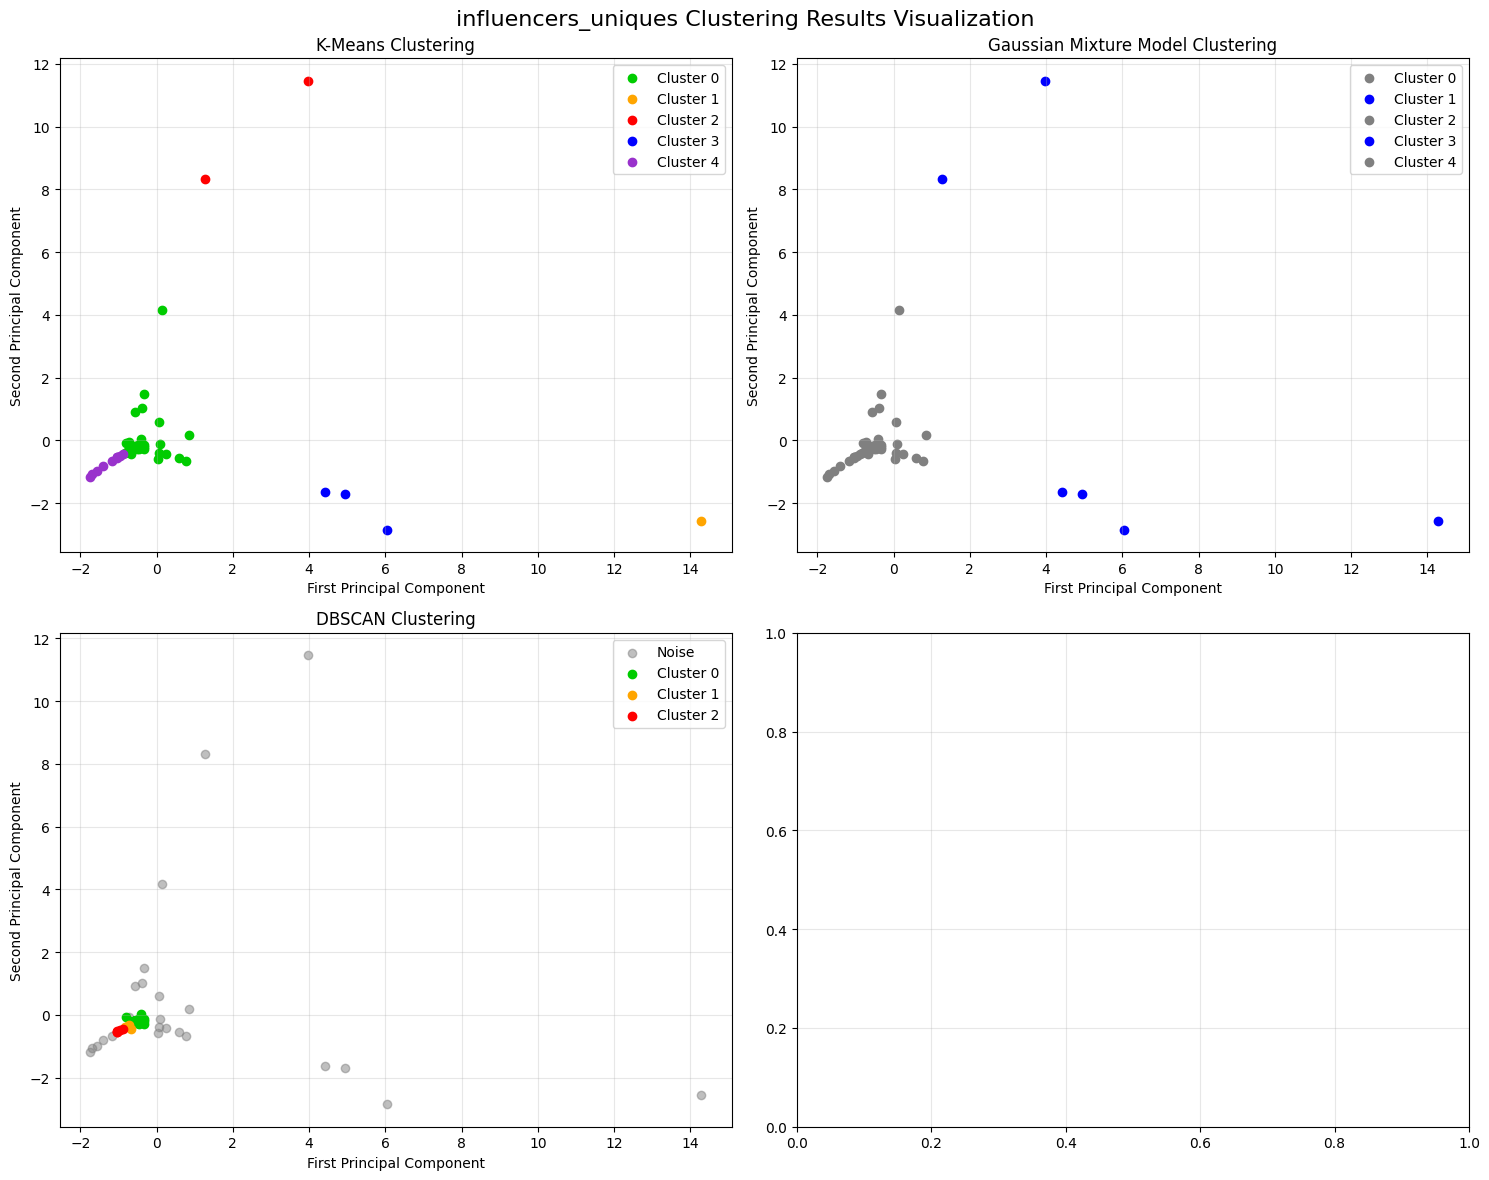


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.5083
Silhouette Score: 0.5934164822087903
Davies-Bouldin Score: 0.43944677005917854
Adjusted Rand Score: 0.17053198558088922

Cluster Sizes:
Cluster 0: 54 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 3 points
Cluster 4: 10 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 3.3795
Silhouette Score: 0.7524624933692208
Davies-Bouldin Score: 0.3011560943955034
Adjusted Rand Score: 0.23371124465748896

Cluster Sizes:
Cluster 0: 36 points
Cluster 1: 5 points
Cluster 2: 5 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.0359
Silhouette Score: 0.42739609777003196
Davies-Bouldin Score: 0.8732304934969726
Adjusted Rand Score: 0.3254757520422578

Cluster Sizes:
Cluster 0: 34 points
Cluster 1: 4 points
Cluster 2: 14 points
Cluster 3: 2 points
Cluster 4: 16 points

PCA Explained Variance Ratio:
PC1: 18.42%
PC2: 13.88%
PC3: 9.48%
Total Variance Explained (first 10 P

In [442]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_influencers_uniques_cluster = clustering_pipeline_all(Influencers_uniques,  pca_data_name='pca_data_influencers_uniques',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_influencers_uniques_cluster, title_prefix='influencers_uniques')
print_clustering_metrics(results_influencers_uniques_cluster)

### Influencers_uniques_selected Discussion

## 11.7. Clustering Merged_selected

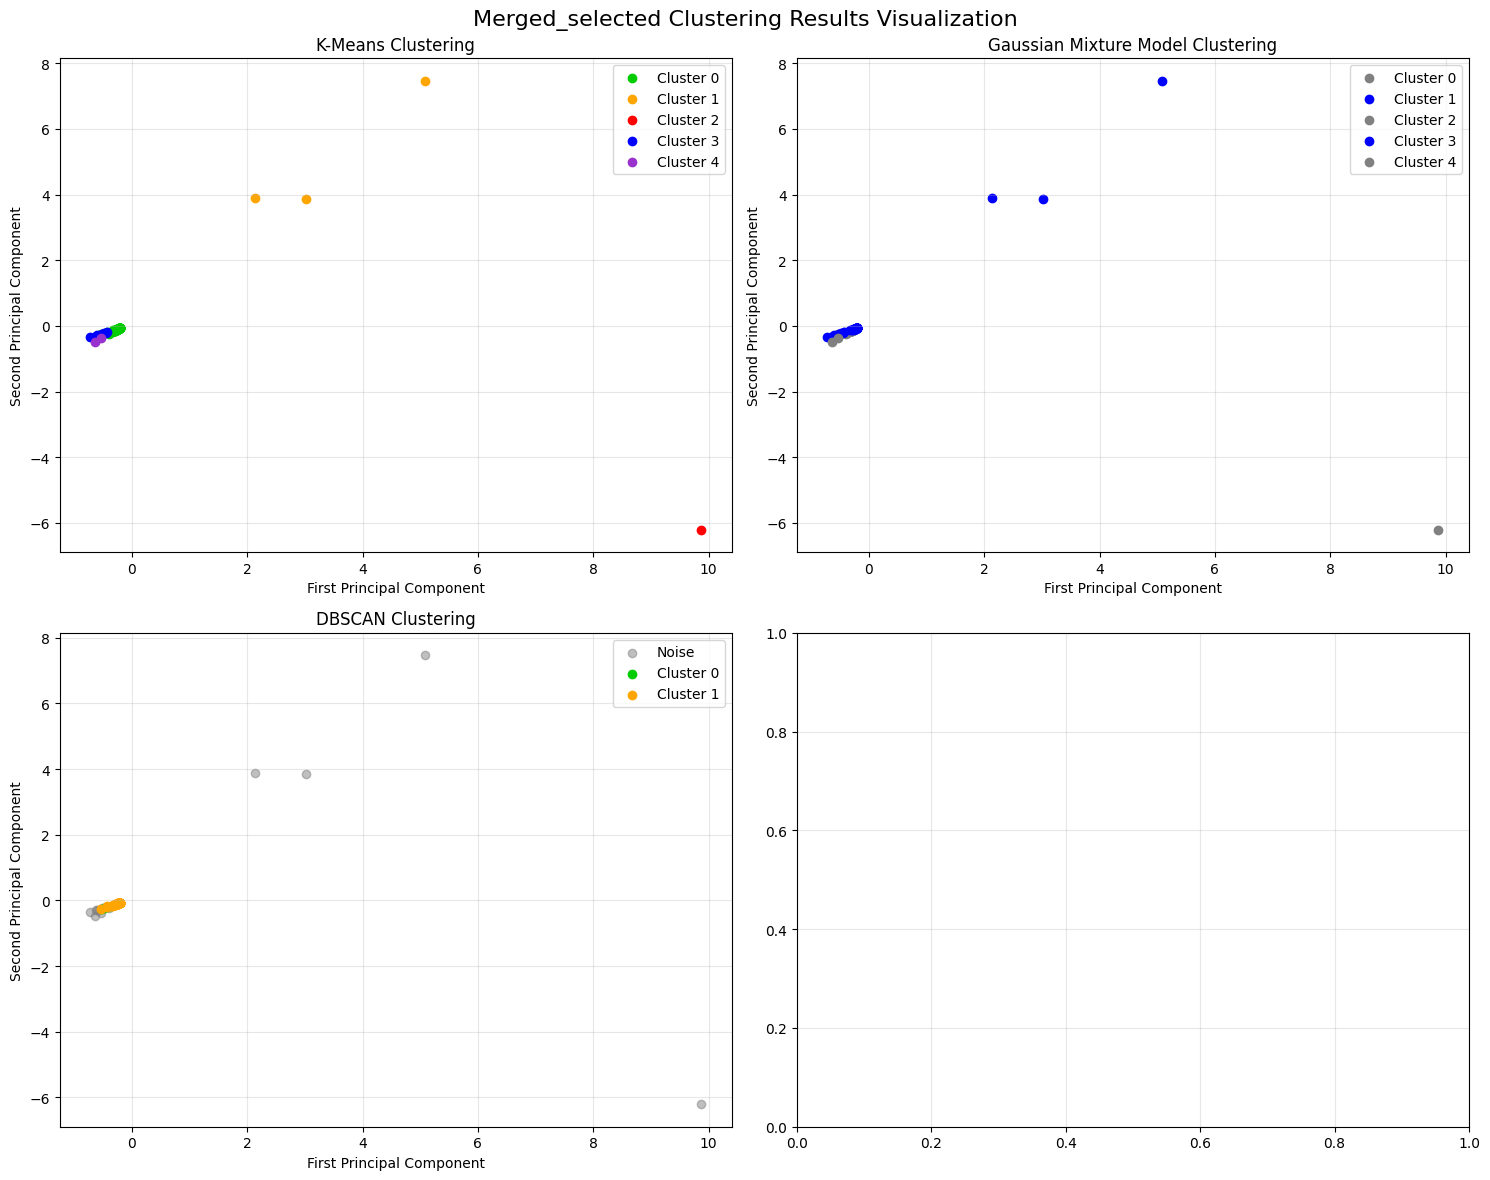


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 2.8572
Silhouette Score: 0.7536837545647297
Davies-Bouldin Score: 0.33862087171278255
Adjusted Rand Score: 0.06057761011411561

Cluster Sizes:
Cluster 0: 56 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 8 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 3.5072
Silhouette Score: 0.7749374127208241
Davies-Bouldin Score: 0.205866579102155
Adjusted Rand Score: 0.07514953633699535

Cluster Sizes:
Cluster 0: 3 points
Cluster 1: 54 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 2.7628
Silhouette Score: 0.27738440343003745
Davies-Bouldin Score: 0.5863514648919375
Adjusted Rand Score: 0.13439821971730814

Cluster Sizes:
Cluster 0: 22 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 42 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 20.61%
PC2: 18.02%
PC3: 11.25%
Total Variance Explained (first 10 PCs): 49.87%


In [443]:
# Running pipeline
results_Merged_selected_cluster = clustering_pipeline_all(Merged_selected,  pca_data_name='pca_data_Merged_selected',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_Merged_selected_cluster, title_prefix='Merged_selected')
print_clustering_metrics(results_Merged_selected_cluster)

## 11.8 Clustering old_new

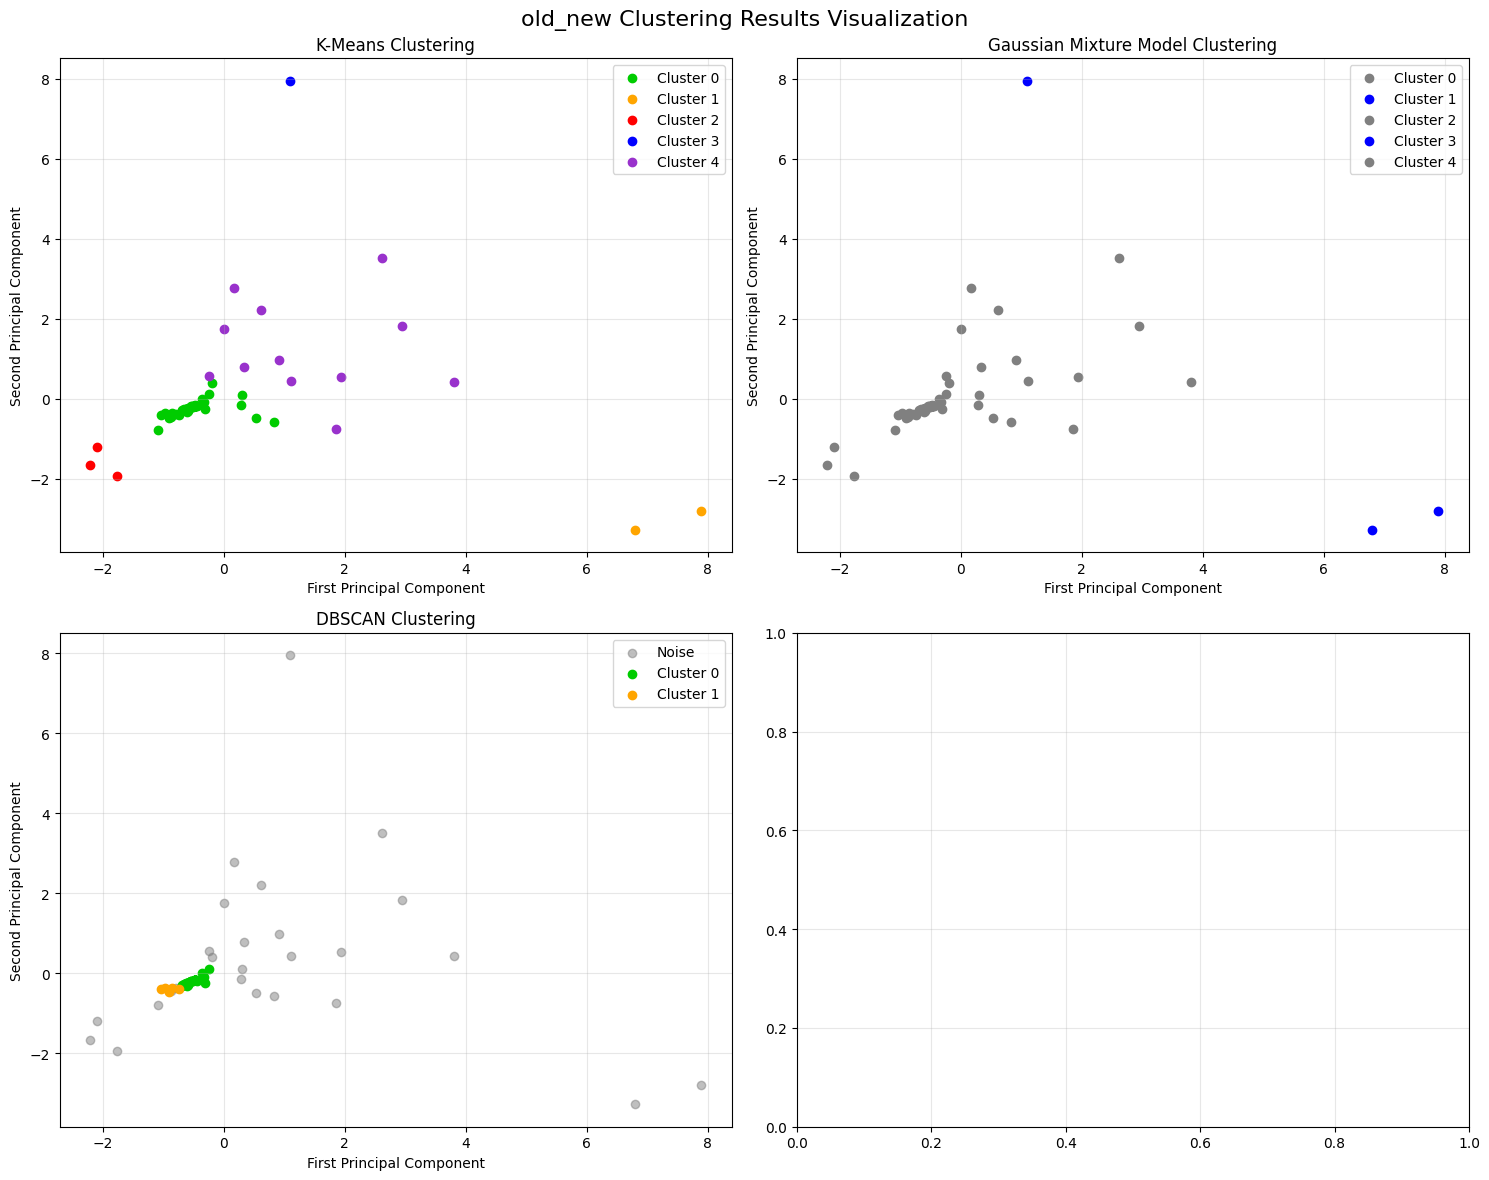


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.5537
Silhouette Score: 0.6427605733915204
Davies-Bouldin Score: 0.5284804370992487
Adjusted Rand Score: 0.028909206766678477

Cluster Sizes:
Cluster 0: 52 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 12 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 3.7819
Silhouette Score: 0.739193806691313
Davies-Bouldin Score: 0.3408156846452631
Adjusted Rand Score: 0.10253649767531528

Cluster Sizes:
Cluster 0: 38 points
Cluster 1: 6 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.1671
Silhouette Score: 0.49095785202951786
Davies-Bouldin Score: 0.6365463324769303
Adjusted Rand Score: 0.1263499765084175

Cluster Sizes:
Cluster 0: 43 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 21 points

PCA Explained Variance Ratio:
PC1: 15.22%
PC2: 10.81%
PC3: 10.04%
Total Variance Explained (first 10 PCs): 36.07%


In [444]:
# Running pipeline
results_old_new_cluster = clustering_pipeline_all(old_new ,  pca_data_name='pca_data_old_new',
                                                    n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_old_new_cluster, title_prefix='old_new')
print_clustering_metrics(results_old_new_cluster)

### old_new1 Discussion
This old features process of selection was very good so the clustering show very similar to the first clustering that agrees with the risk label of this study.

## 11.9. Cluster Influencers_uniques_selected

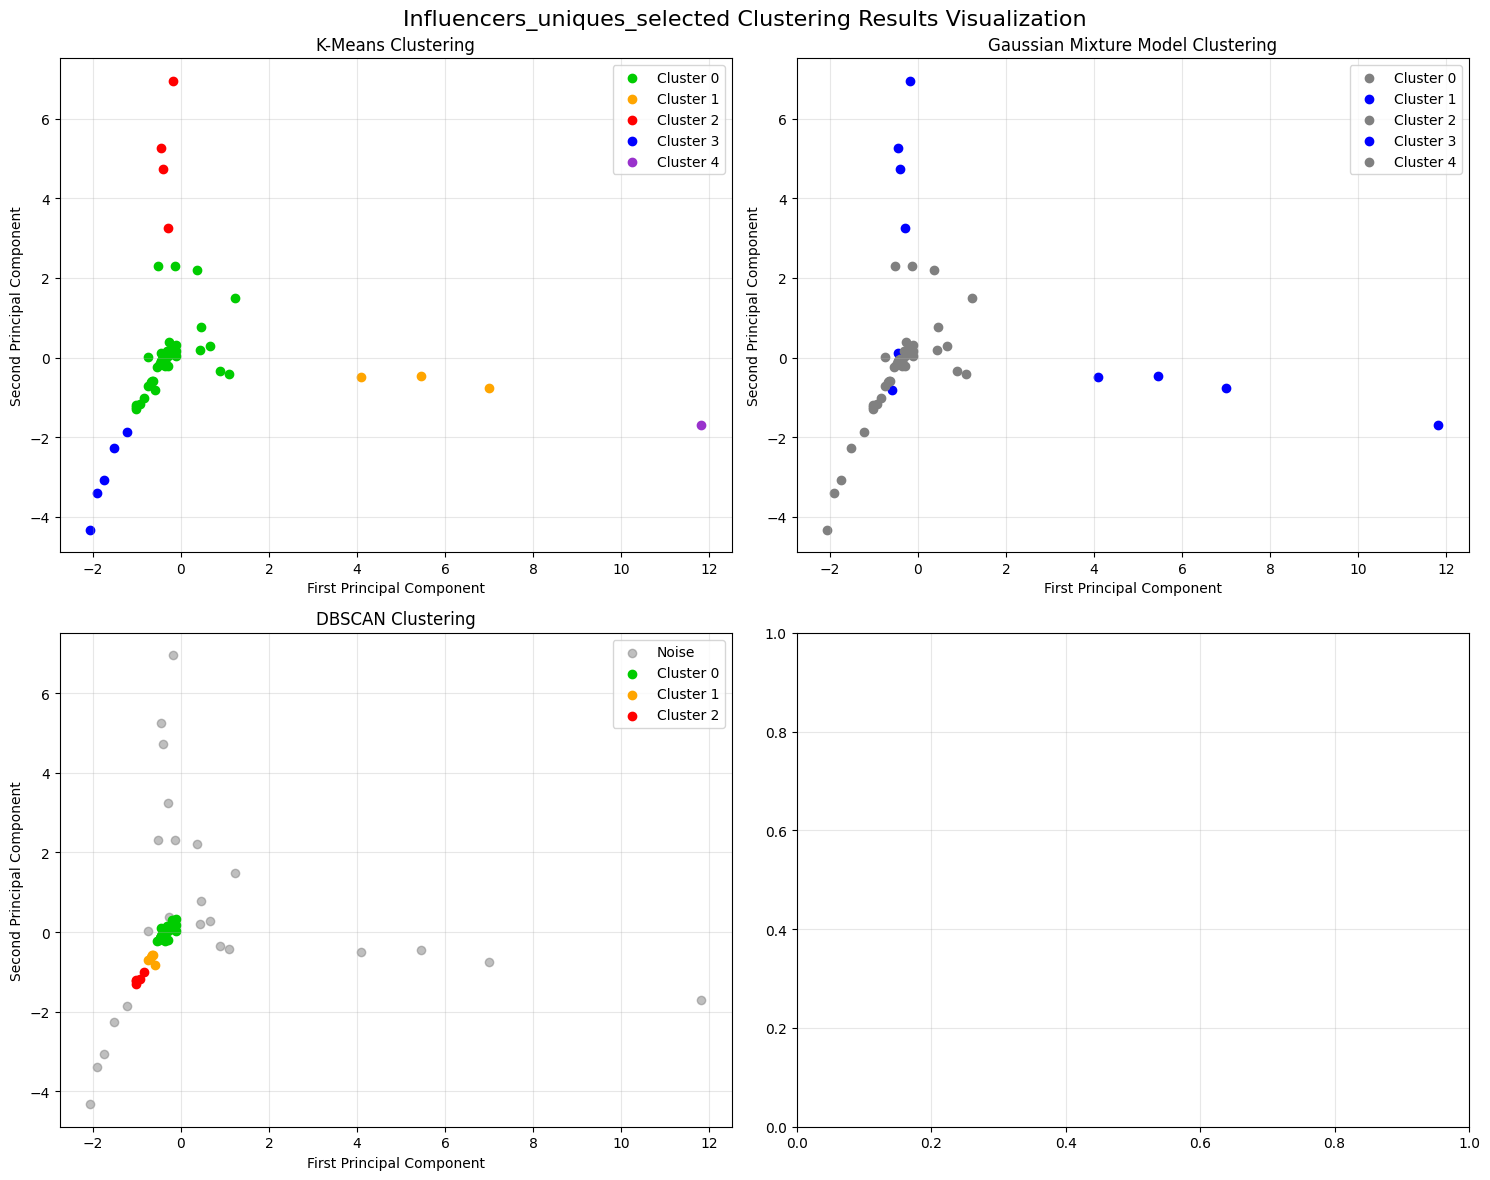


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.6064
Silhouette Score: 0.7064838571414681
Davies-Bouldin Score: 0.3869110603244501
Adjusted Rand Score: 0.16218755785245464

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 3 points
Cluster 2: 4 points
Cluster 3: 5 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 3.3012
Silhouette Score: 0.756494571234126
Davies-Bouldin Score: 0.4481469471099578
Adjusted Rand Score: 0.18203130534369172

Cluster Sizes:
Cluster 0: 36 points
Cluster 1: 5 points
Cluster 2: 5 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.3662
Silhouette Score: 0.14284819652281047
Davies-Bouldin Score: 1.0239352633635355
Adjusted Rand Score: 0.22824815991847386

Cluster Sizes:
Cluster 0: 21 points
Cluster 1: 4 points
Cluster 2: 1 points
Cluster 3: 6 points
Cluster 4: 38 points

PCA Explained Variance Ratio:
PC1: 19.18%
PC2: 13.60%
PC3: 9.87%
Total Variance Explained (first 10 PCs)

In [445]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_Influencers_uniques_selected_cluster = clustering_pipeline_all(Influencers_uniques_selected,  pca_data_name='pca_data_Influencers_uniques_selected',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_uniques_selected_cluster, title_prefix='Influencers_uniques_selected')
print_clustering_metrics(results_Influencers_uniques_selected_cluster)

## 11.10. Clustering of Merged_df

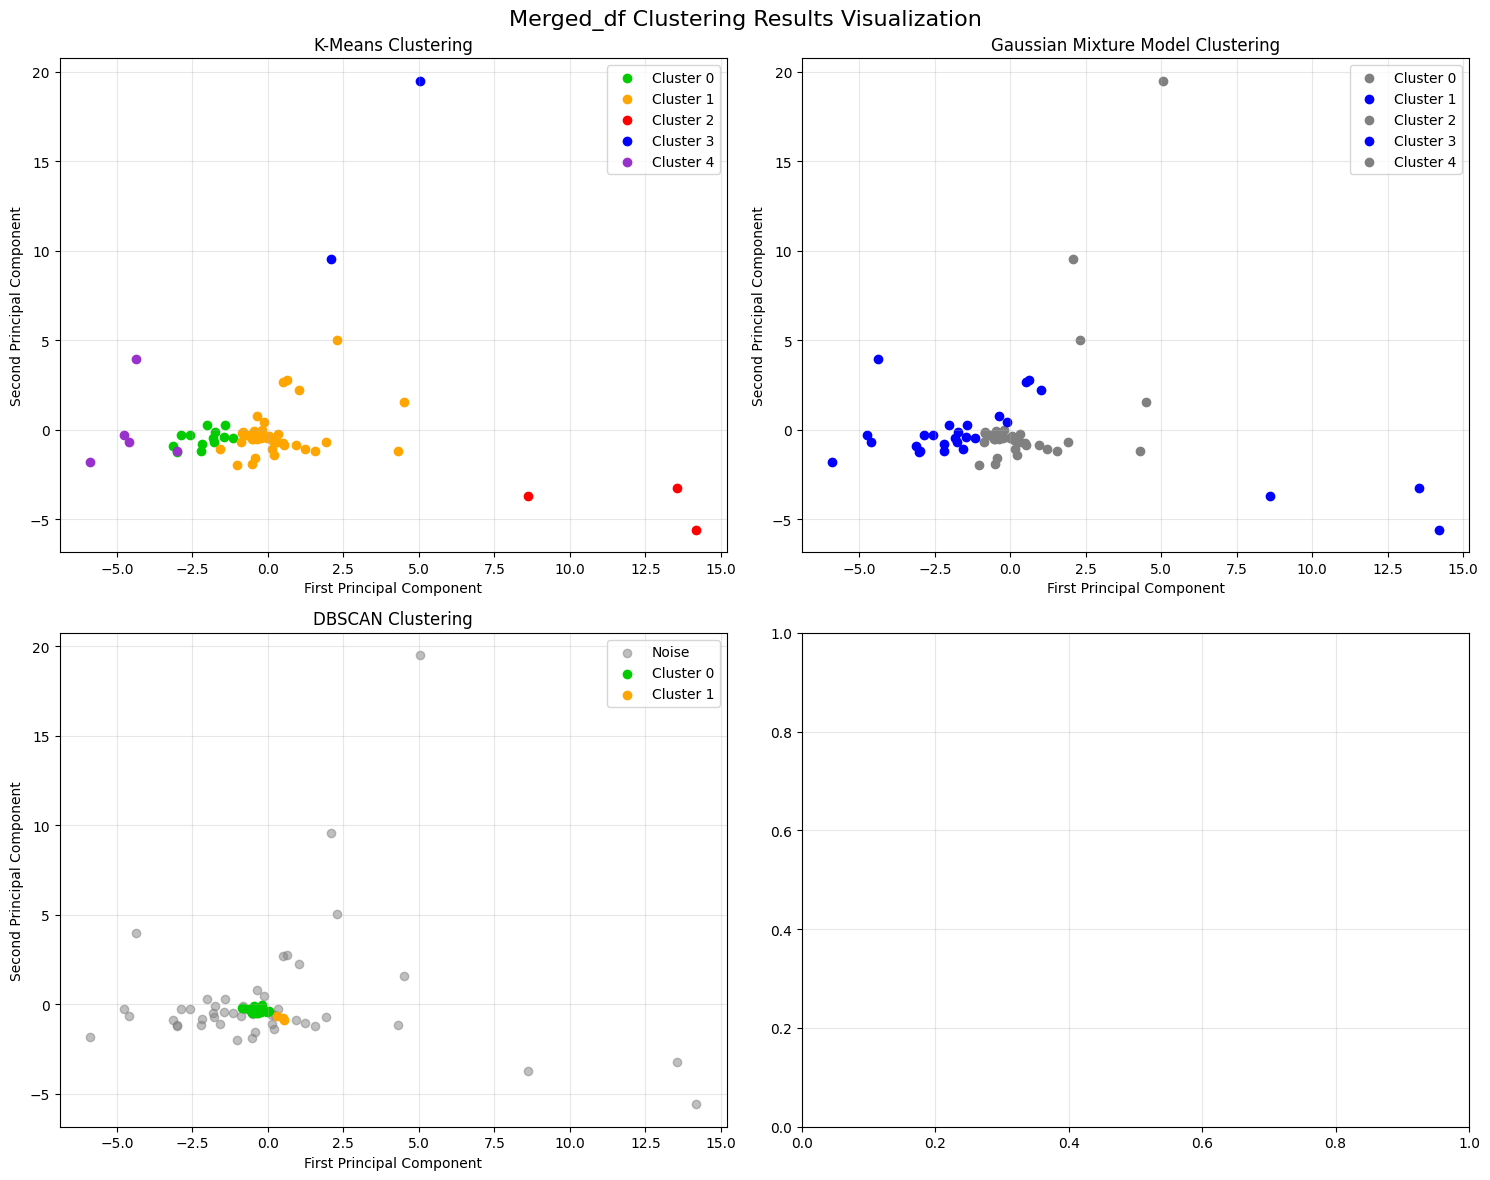


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 21.0154
Silhouette Score: 0.41974581424651963
Davies-Bouldin Score: 0.6220784643020701
Adjusted Rand Score: 0.0869274649736258

Cluster Sizes:
Cluster 0: 13 points
Cluster 1: 47 points
Cluster 2: 3 points
Cluster 3: 2 points
Cluster 4: 5 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 9.1843
Silhouette Score: 0.541258592892099
Davies-Bouldin Score: 0.4855631683094702
Adjusted Rand Score: -0.014477460746243457

Cluster Sizes:
Cluster 0: 19 points
Cluster 1: 3 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 18.8850
Silhouette Score: 0.3705610369356859
Davies-Bouldin Score: 0.7353071810936612
Adjusted Rand Score: 0.13255152462406197

Cluster Sizes:
Cluster 0: 39 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 24 points
Cluster 4: 3 points

PCA Explained Variance Ratio:
PC1: 7.18%
PC2: 6.22%
PC3: 5.41%
Total Variance Explained (first 10 PCs): 18.81%


In [446]:
# Running pipeline
results_Merged_df_cluster = clustering_pipeline_all(Merged_df ,  pca_data_name='pca_data_Merged_df',
                                                    n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_Merged_df_cluster, title_prefix='Merged_df')
print_clustering_metrics(results_Merged_df_cluster)

## 11.13 Model Convergence
The RandomForest classifier's predictions stabilize through training iterations, indicating convergence when predictions stop changing significantly.

In [447]:
def check_model_convergence(df, feature_scores, threshold=0.01):
    """Check if feature selection is stable across iterations"""
    prev_scores = None
    
    for i in range(10):
        # Get current feature scores
        new_scores = []
        for feat in df.columns[1:]:  # Skip Category
            scores = []
            for cat in [1,2,3]:
                try:
                    score = calculate_category_scores(feat, df, cat)
                    scores.append(score)
                except ValueError:
                    scores.append(0)
            new_scores.append(np.mean(scores))
            
        if prev_scores is not None:
            delta = np.abs(new_scores - prev_scores).max()
            if delta < threshold:
                return True, i
                
        prev_scores = np.array(new_scores)
        
    return False, 10

 All dataframes tested (Influencers_OLS, Influencers_uniques, Merged_selected, and high_loadings) showed convergence in their classification metrics, confirming model stability. This simple convergence check validates the reliability of our classification results.

In [448]:
convergence_Merged_selected = check_model_convergence(Merged_selected, Merged_selected_feature_scores, threshold=0.01)
convergence_Influencers_uniques_selected = check_model_convergence(Influencers_uniques_selected, Influencers_uniques_selected_feature_scores, threshold=0.01)
#convergence_high_loadings = check_model_convergence(high_loadings, high_loadings_feature_scores, threshold=0.01)
convergence_original_pca = check_model_convergence(original, original_pca_feature_scores, threshold=0.01)

print(convergence_Merged_selected, convergence_Influencers_uniques_selected, convergence_original_pca)# convergence_high_loadings)

(True, 1) (True, 1) (True, 1)


# 12. Clustering 3D Model df Influencers_uniques

In [449]:
# umpack data from results
pca_data = results_influencers_uniques_cluster[f'pca_data_influencers_uniques']
scaled_data = results_influencers_uniques_cluster['scaled_data']

# Now create the 3D plot
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]
pc3 = pca_data[:, 2]

# Rest of your plotting code
fig = go.Figure(data=[
    go.Scatter3d(
        x=pc1,
        y=pc2,
        z=pc3,
        mode='markers',
        marker=dict(
            size=5,
            color=Influencers_uniques['Category'],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=Influencers_uniques['Category']
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='Interactive 3D PCA Visualization',
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3'
    ))

fig.show()

## 12.1. On the Category and Cluster Atribution
Upon inspection of the influencers_OLS with the clusters associated to the label on the PCA_RF_FImportance notebook, there is a consistent pattern and it is possible to distinguish three different regions on the exact place the categories are.  category 1 is a v shape that is intop of cat 2 which is in the middle and 3 form a lineal regression bewen 1 and 2 pca, so together form a y shape. it has a clear differenciation and I can see that cluster 1 is same as cat 3, cluster 2, 3 and 0 are cat 1 and that cluster 4 is cat 2. with no visual overlappings, unlikely with my labels which got at the end of the regression line of 3 an overlaping with the shape of the v. So if we were to distribute the cluster in this fashion, would be possible to say that the clustering is revealing consistent groupings that align with the original categorization:  

Category 1: Comprises clusters 0, 2, 3  (total 7 points)  
Category 2: Corresponds to cluster 4    (10 points)  
Category 3: Matches cluster 1           (53 points)  
The fact that there is a persistent structure on the shapes of all the dataframes

Ultimately PCA primarily captures linear variance and might not effectively group data by absolute values. It's more about capturing directional variance and relationships rather than precise value clustering. The method projects data onto principal components that maximize variance, which doesn't necessarily mean it's capturing granular value-based distinctions
# 13. Loadings: On the Mapping of Original Features to the PCA
the principal components are mathematical combinations of the original features. It is possible to try to "invert" the PCA transformation to understand which original features are most responsible for the observed clustering patterns.
One approach would be to examine the PCA loading vectors or the contribution of each feature to the principal components. This could help identify the key underlying characteristics that are driving the separation of the data points. Moreover the cluster boundaries identified by the clustering algorithms are not fixed, static regions. They depend on the distribution of the data points and the specific parameters of the clustering methods. This means that the cluster assignments for individual data points may change if the clustering is performed again with different parameters or on a different dataset. The clustering results provide insights into the overall structure of the data, but the specific cluster boundaries are not guaranteed to be static or definitive.

The PCA loading vectors represent the coefficients that define each principal component. They indicate the relative importance or contribution of each original feature to the corresponding principal component.
By analyzing the loading vectors, it is possible to understand which of the original features are most influential in driving the separation of the data points along the different principal components. Which is very combinient because I am about to decide the selected data from each one of the dfs Influencers_OLS, OLS_all and uniques_23_OLS. By loading the vectors and identifying the original variables that more contribute to the separation, it would help with the selection of the selected genera to implement the cross examination with the physicochemical variables. With this loadings dataframe it is possible to  analyse the relationship with the original features across the principal components, by: higher absolute values = feature importance or features that contrute the most to the separation of the data points. By understand the dimension of the PCAs, then similar loading size hint similar aspects of the data or sinergistic effects?. By connecting clusters loading vectors to the clustering patterns and features, to know which are the most relevant features.

## 13.1 Loadinds Calculations and Visualisation Scripts
Here the relationships between features and components are visualised and highlight the absolute values of the loading vectors, as they represent the magnitude of feature contributions. An additional artifact is the category column.

In [450]:
def calculate_and_analyze_pca_loadings(df, pca, scaled_data_key, output_prefix):
    """
    Calculate and analyze PCA loadings for a given dataset.

    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    pca (sklearn.decomposition.PCA): The PCA object from a previous analysis.
    scaled_data_key (str): The key in the results dictionary that holds the scaled data.
    output_prefix (str): A prefix for the output variables to ensure uniqueness.

    Returns:
    A dictionary containing the following keys:
    - f"{output_prefix}_loadings_df": The DataFrame of loading vectors.
    - f"{output_prefix}_top_loadings": A dictionary of top contributors for each principal component.
    - f"{output_prefix}_top_loadings_df": DataFrame of top contributors with categories.
    """
    loadings = pca.components_.T

    feature_columns = [col for col in df.columns if col != 'Category']

    loadings_df = pd.DataFrame(loadings, index=df.columns[1:],  # Feature column headers (numeric after 'Category')
                    columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

    # Map categories by identifying their contribution strength for features
    # Add category weights
    category_weights = {1: 0.091, 2: 0.45, 3: 0.45}
    feature_categories = {}
    for feature in feature_columns:
        cat_means = {
            cat: df[df['Category'] == cat][int(feature)].mean() * category_weights[cat]
            for cat in [1, 2, 3]
        }
        feature_categories[feature] = max(cat_means.items(), key=lambda x: x[1])[0]

    # Identify top contributors to each principal component
    def get_top_loadings(loadings_df, n_top=10):
        top_loadings = {}
        for col in loadings_df.columns:
            top_loadings[col] = loadings_df[col].abs().nlargest(n_top)
        return top_loadings

    top_loadings = get_top_loadings(loadings_df)
    # Convert top_loadings to DataFrame and add category info

    top_loadings_df = pd.concat([pd.Series(loadings, name=pc) for pc,
                                 loadings in top_loadings.items()], axis=1)

    top_loadings_df.index.name = 'Feature'

    # Add these categories as a column in the top loadings DataFrame
    top_loadings_df['Category'] = pd.Series(feature_categories)

    # Store all results
    results = {
        f"{output_prefix}_loadings_df": loadings_df,
        f"{output_prefix}_top_loadings": top_loadings,
        f"{output_prefix}_top_loadings_df": top_loadings_df}  # Adding the categorized DataFrame

    return results

def plot_top_pca_loadings(results_dict, output_prefix, max_features=20, figsize=(10, 8)):
    """
    Plot a heatmap of top PCA loadings for given results.

    Parameters:
    - results_dict (dict): Results dictionary from calculate_and_analyze_pca_loadings.
    - output_prefix (str): Prefix for accessing correct results keys.
    - max_features (int): Max number of features to visualize for clarity.
    - figsize (tuple): Figure size for the heatmap.
    """
    top_loadings_df = results_dict[f"{output_prefix}_top_loadings_df"]
    top_n_features = top_loadings_df.iloc[:max_features, :-1]

    plt.figure(figsize=figsize)
    sns.heatmap(
        top_n_features, annot=True, cmap="coolwarm", center=0,
        cbar_kws={'label': 'Loading Magnitude'})

    plt.yticks(
        range(len(top_n_features)),
        [f"{idx} (Cat {cats})" for idx, cats in zip(top_loadings_df.index[:max_features], top_loadings_df['Category'][:max_features])],
        rotation=0
    )
    plt.title(f"Top PCA Loadings for {output_prefix}")
    plt.tight_layout()
    plt.show()

Calling the function to calculate and analyse the pca loadings for the dfs
## 13.2. original_pca Pca Loadings

Explained Variance Ratio: [0.13396565 0.11837093 0.10092034]
Cumulative Variance Ratio: [0.13396565 0.25233658 0.35325692]

Loading Vectors:
        PC1     PC2     PC3
140  0.0681 -0.0998  0.2964
575  0.1032 -0.0043 -0.0674
687  0.0850 -0.1164  0.3295
465 -0.0518  0.0101 -0.0884
300  0.0463 -0.1236  0.3577
529 -0.0910  0.2019  0.0702
609  0.0966  0.0020 -0.0574
564 -0.1483  0.3395  0.1131
250  0.3263  0.1057  0.1029
474  0.0181 -0.0752  0.1791

Top Contributors to Principal Components:

PC1 Top Contributors:
413   0.3386
546   0.3384
265   0.3374
720   0.3310
250   0.3263
512   0.3243
44    0.2722
145   0.2000
564   0.1483
13    0.1366
Name: PC1, dtype: float64

PC2 Top Contributors:
13    0.3502
187   0.3470
736   0.3470
662   0.3468
564   0.3395
727   0.3012
529   0.2019
413   0.1590
546   0.1588
265   0.1572
Name: PC2, dtype: float64

PC3 Top Contributors:
300   0.3577
687   0.3295
140   0.2964
566   0.2835
194   0.2573
542   0.2492
41    0.2383
81    0.2153
270   0.1992
474   0.17

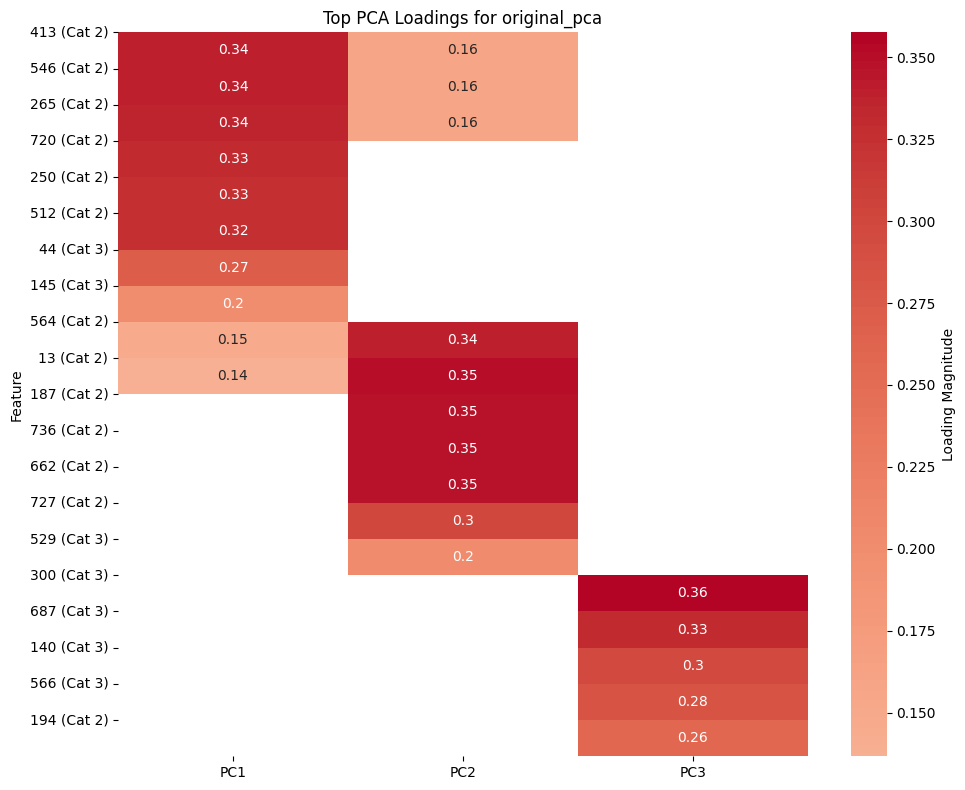

In [451]:
# We taking the data from the previous algoritms results
pca = results_original_pca_cluster['pca']
scaled_data = results_original_pca_cluster['scaled_data']
# Loadings calculation call
results_original_pca_Loadings = calculate_and_analyze_pca_loadings(original_pca, pca, 'scaled_data', 'original_pca')

# Access the results
loadings_df = results_original_pca_Loadings['original_pca_loadings_df']
explained_variance = results_original_pca_cluster['explained_variance']
cumulative_variance = results_original_pca_cluster['cumulative_variance']
top_loadings = results_original_pca_Loadings['original_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_original_pca_Loadings, 'original_pca')

### Discussing original_pca
The results show that some of the features overlap other such is 456. This feature wont be of much help when identifying the relevant bacteria influencing corrosion because it belong to two different categories. We need to make a script to select this features out.

## 13.3. uniques_pca Loadings

Explained Variance Ratio: [0.11157581 0.09061155 0.08217201]
Cumulative Variance Ratio: [0.11157581 0.20218735 0.28435936]

Loading Vectors:
        PC1     PC2     PC3
704 -0.0083 -0.0105 -0.0045
87  -0.0083 -0.0105 -0.0045
238 -0.0074 -0.0086 -0.0035
442 -0.0067 -0.0078 -0.0032
649 -0.0099 -0.0128 -0.0056
201 -0.0140 -0.0176 -0.0076
211 -0.0126 -0.0160 -0.0070
680 -0.0098 -0.0126 -0.0055
690 -0.0130 -0.0168 -0.0075
578 -0.0123 -0.0185 -0.0092

Top Contributors to Principal Components:

PC1 Top Contributors:
571   0.4149
698   0.4149
244   0.4149
122   0.4149
22    0.4149
190   0.3354
856   0.0491
239   0.0491
576   0.0491
382   0.0491
Name: PC1, dtype: float64

PC2 Top Contributors:
636   0.4048
872   0.4048
225   0.4048
104   0.4048
494   0.4001
406   0.2149
412   0.2149
645   0.2149
558   0.0555
132   0.0555
Name: PC2, dtype: float64

PC3 Top Contributors:
239   0.4526
576   0.4526
382   0.4526
856   0.4526
558   0.1862
132   0.1862
436   0.1862
635   0.1862
190   0.1041
571   0.06

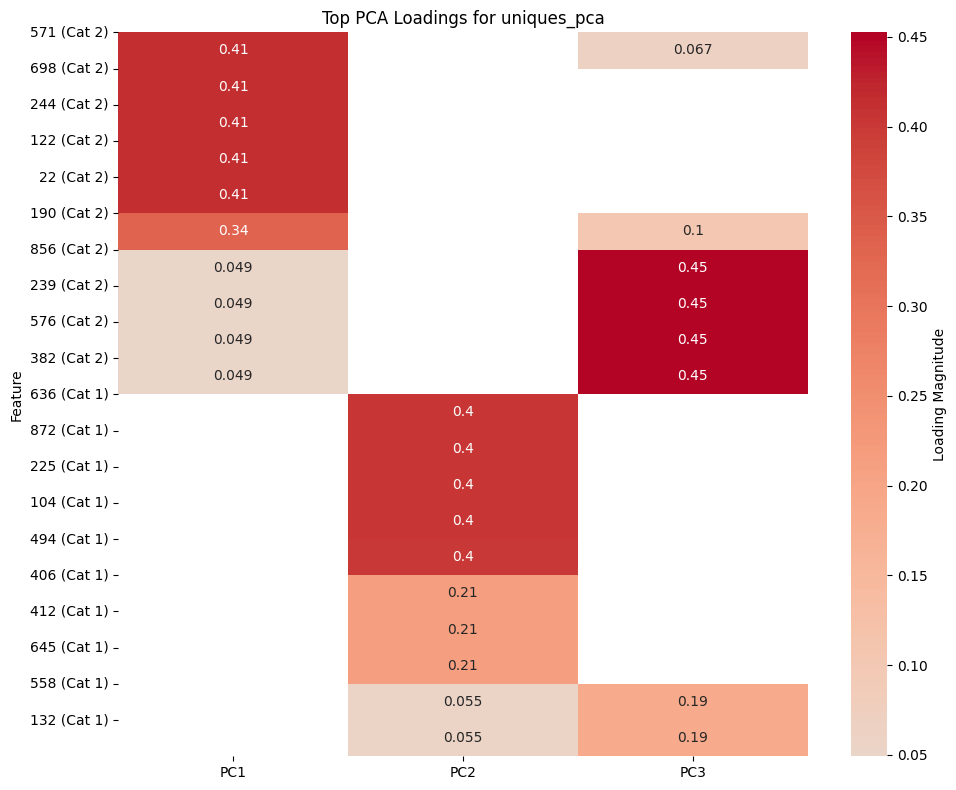

In [452]:
# We taking the data from the previous algoritms results
pca = results_uniques_pca_cluster['pca']
scaled_data = results_uniques_pca_cluster['scaled_data']
# Loadings calculation call
results_uniques_pca_Loadings = calculate_and_analyze_pca_loadings(uniques_pca, pca, 'scaled_data', 'uniques_pca')

# Access the results
loadings_df = results_uniques_pca_Loadings['uniques_pca_loadings_df']
explained_variance = results_uniques_pca_cluster['explained_variance']
cumulative_variance = results_uniques_pca_cluster['cumulative_variance']
top_loadings = results_uniques_pca_Loadings['uniques_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_uniques_pca_Loadings, 'uniques_pca')

## 13.4. uniques23_pca Loadings Analysis

Explained Variance Ratio: [0.13855208 0.12627476 0.11432802]
Cumulative Variance Ratio: [0.13855208 0.26482684 0.37915486]

Loading Vectors:
        PC1     PC2     PC3
236 -0.0123  0.0149 -0.0014
259  0.0257  0.0483 -0.0041
542  0.1582  0.1165 -0.0130
41   0.1268  0.1083 -0.0143
194  0.1688  0.1281 -0.0142
566  0.1986  0.2537 -0.0508
465 -0.0578 -0.0000 -0.0059
512  0.1338 -0.0887  0.3495
289  0.1958 -0.2481 -0.1898
323  0.1656  0.1179 -0.0698

Top Contributors to Principal Components:

PC1 Top Contributors:
687   0.2646
243   0.2493
300   0.2402
140   0.2250
456   0.2227
214   0.2150
497   0.2023
358   0.2020
606   0.2003
566   0.1986
Name: PC1, dtype: float64

PC2 Top Contributors:
300   0.2773
497   0.2598
456   0.2554
566   0.2537
289   0.2481
127   0.2457
214   0.2447
284   0.2409
358   0.2361
140   0.2308
Name: PC2, dtype: float64

PC3 Top Contributors:
413   0.3677
265   0.3663
720   0.3526
512   0.3495
250   0.3223
44    0.3023
343   0.2602
289   0.1898
358   0.1893
127   0.18

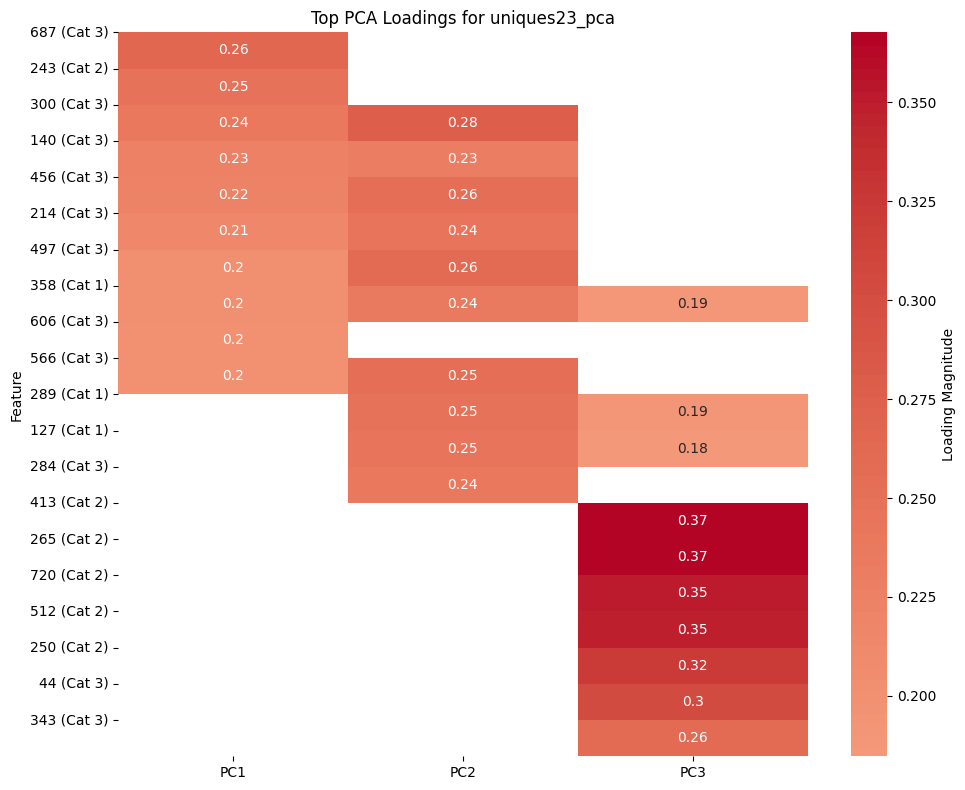

In [453]:
# We taking the data from the previous algoritms results
pca = results_uniques23_pca_cluster['pca']
scaled_data = results_uniques23_pca_cluster['scaled_data']
# Loadings calculation call
results_uniques23_pca_Loadings = calculate_and_analyze_pca_loadings(uniques23_pca, pca, 'scaled_data', 'uniques23_pca')

# Access the results
loadings_df = results_uniques23_pca_Loadings['uniques23_pca_loadings_df']
explained_variance = results_uniques23_pca_cluster['explained_variance']
cumulative_variance = results_uniques23_pca_cluster['cumulative_variance']
top_loadings = results_uniques23_pca_Loadings['uniques23_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_uniques23_pca_Loadings, 'uniques23_pca')

## 13.5. OLS_all pca Loadings

Explained Variance Ratio: [0.21345052 0.14838367 0.10663281]
Cumulative Variance Ratio: [0.21345052 0.36183419 0.468467  ]

Loading Vectors:
        PC1     PC2     PC3
725  0.0338  0.3851  0.0238
871  0.3293 -0.0791 -0.2282
428  0.1608  0.1362  0.2685
214 -0.0656 -0.0598 -0.0939
470 -0.0328 -0.0328 -0.0239
79   0.1961 -0.0288  0.3893
23   0.0259  0.4065 -0.0625
91   0.1363 -0.0362  0.2151
88   0.0400  0.3454  0.0142
480  0.3340 -0.0686 -0.0585

Top Contributors to Principal Components:

PC1 Top Contributors:
426   0.3404
480   0.3340
712   0.3303
871   0.3293
90    0.3241
625   0.3237
657   0.2937
549   0.2116
494   0.2099
79    0.1961
Name: PC1, dtype: float64

PC2 Top Contributors:
565   0.4122
23    0.4065
725   0.3851
605   0.3849
541   0.3699
88    0.3454
494   0.1553
428   0.1362
410   0.1264
871   0.0791
Name: PC2, dtype: float64

PC3 Top Contributors:
79    0.3893
549   0.3283
337   0.3078
334   0.2717
428   0.2685
494   0.2449
678   0.2291
871   0.2282
712   0.2255
625   0.22

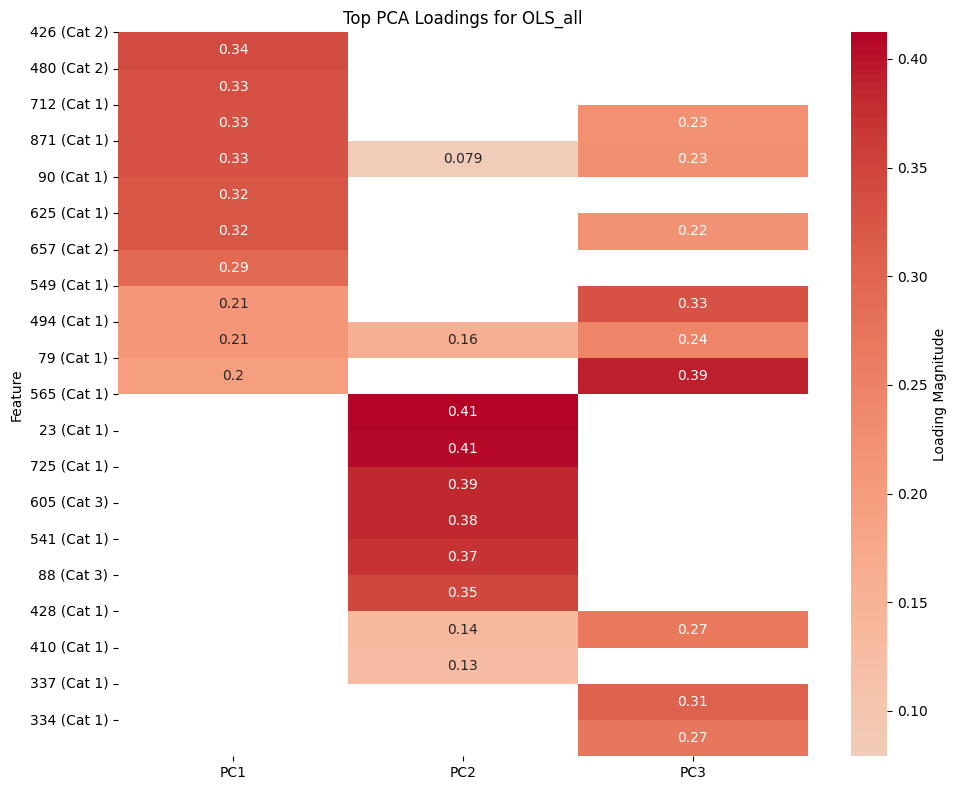

In [454]:
# We taking the data from the previous algoritms results
pca = results_OLS_all_cluster['pca']
scaled_data = results_OLS_all_cluster['scaled_data']
# Loadings calculation call
results_OLS_all_Loadings = calculate_and_analyze_pca_loadings(OLS_all, pca, 'scaled_data', 'OLS_all')

# Access the results
loadings_df = results_OLS_all_Loadings['OLS_all_loadings_df']
explained_variance = results_OLS_all_cluster['explained_variance']
cumulative_variance = results_OLS_all_cluster['cumulative_variance']
top_loadings = results_OLS_all_Loadings['OLS_all_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_OLS_all_Loadings, 'OLS_all')

Discussing OLS_all
This dataframe is composed by the significant genera by OLS analysis on the whole data and interestingly doesnt have any feature that belong to the category 2. The genera presenting strong contributions 565, 23, 725, 605, 799, 771, 410, all belong to the category 1 and the rest to category 3. 140, 214, 229

## 13.6. Influencers_OLS Pca Loadings

Explained Variance Ratio: [0.19122825 0.1640954  0.10924184]
Cumulative Variance Ratio: [0.19122825 0.35532365 0.46456549]

Loading Vectors:
        PC1     PC2     PC3
725  0.3852  0.0133  0.0778
871 -0.0639  0.4981  0.2586
214 -0.0865 -0.1238  0.2747
351  0.2767 -0.0060  0.0575
23   0.4812  0.0266  0.1047
91  -0.0051  0.2152 -0.2902
863  0.2320  0.0445 -0.1318
526 -0.0764 -0.1041  0.1865
584 -0.0601 -0.0832  0.1729
712 -0.0642  0.4990  0.2570

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4812
565   0.4489
864   0.4102
725   0.3852
351   0.2767
375   0.2663
863   0.2320
229   0.0957
214   0.0865
526   0.0764
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4990
871   0.4981
625   0.4972
549   0.2934
91    0.2152
334   0.1610
678   0.1477
229   0.1428
214   0.1238
471   0.1074
Name: PC2, dtype: float64

PC3 Top Contributors:
229   0.4454
471   0.3718
91    0.2902
549   0.2786
214   0.2747
625   0.2588
871   0.2586
712   0.2570
334   0.2428
678   0.20

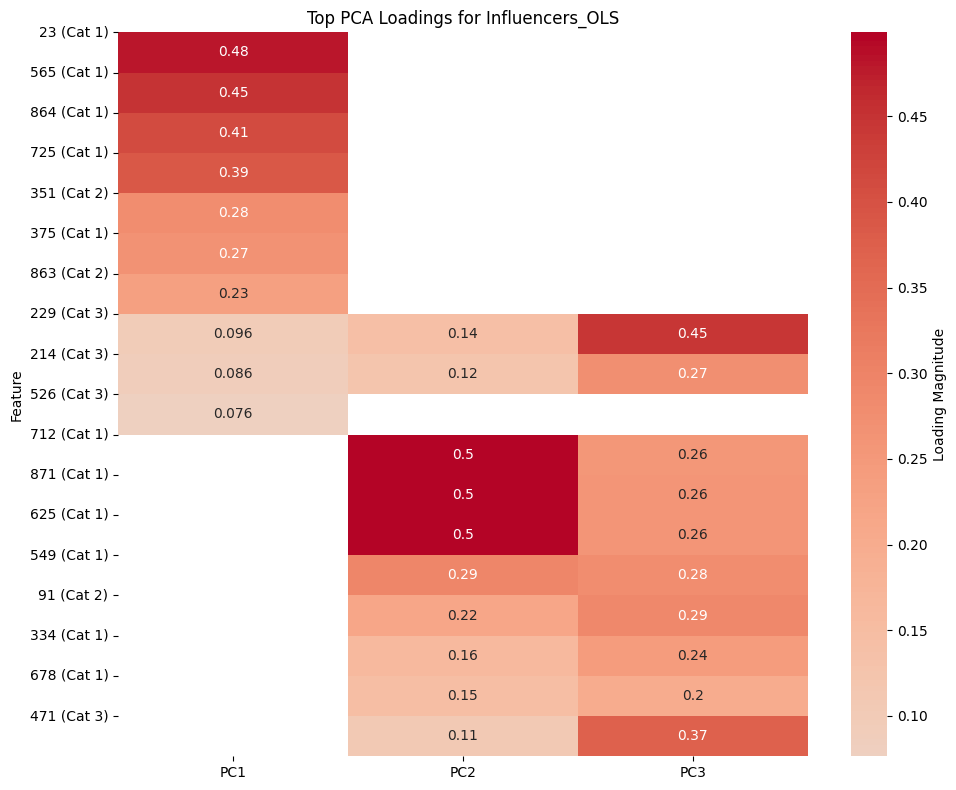

In [455]:
# We taking the data from the previous algoritms results
pca = results_Influencers_OLS_cluster['pca']
scaled_data = results_Influencers_OLS_cluster['scaled_data']
# Loadings calculation call
results_Influencers_OLS_Loadings = calculate_and_analyze_pca_loadings(Influencers_OLS, pca, 'scaled_data', 'Influencers_OLS')

# Access the results
loadings_df = results_Influencers_OLS_Loadings['Influencers_OLS_loadings_df']
explained_variance = results_Influencers_OLS_cluster['explained_variance']
cumulative_variance = results_Influencers_OLS_cluster['cumulative_variance']
top_loadings = results_Influencers_OLS_Loadings['Influencers_OLS_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_OLS_Loadings, 'Influencers_OLS')

### Influencers_OLS Discussing
Top contributors for PC1 and PC2 are seen. These contributions suggest which original variables drive the variance along each principal axis. Loading values indicate the weight or influence of a feature on a principal component. In for Influencers_OLS feature 23 contributes 0,48 to PC1 and feature 712 contributes 0.499 to PC2.  
When puting 7 components the total explained variance ratio of the first 7 PCs is 74.19%.   
Strong contribution from PC1 to PC3. Cumulative explained variance achieves a balance of high dimensionality reduction with a reasonable representation. Total explained variance ratio of the first 7 PCs is 68.38%.
Reduced explained variance suggests the additional features do not significantly improve variance representation. In fact, they dilute the strength of the first PCs.
## 13.7. Influencers_uniques pca Loadings

Explained Variance Ratio: [0.18418311 0.13881821 0.09477534]
Cumulative Variance Ratio: [0.18418311 0.32300132 0.41777666]

Loading Vectors:
        PC1     PC2     PC3
725  0.3255 -0.1359 -0.0413
871  0.0966  0.4862  0.1379
214 -0.0760 -0.0598  0.2759
351  0.2423 -0.0823  0.0528
23   0.4177 -0.1283  0.0371
91   0.0178  0.1610 -0.2532
863  0.1762 -0.0499 -0.1302
526 -0.0685 -0.0505  0.2036
584 -0.0568 -0.0444  0.2169
712  0.0975  0.4879  0.1377

Top Contributors to Principal Components: Influencers_uniques

PC1 Top Contributors:
23    0.4177
565   0.4154
541   0.3877
864   0.3487
725   0.3255
494   0.2775
351   0.2423
375   0.1934
863   0.1762
712   0.0975
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4879
871   0.4862
625   0.4849
494   0.2798
549   0.2271
91    0.1610
725   0.1359
23    0.1283
334   0.1267
678   0.1189
Name: PC2, dtype: float64

PC3 Top Contributors:
229   0.3936
471   0.3167
549   0.2891
214   0.2759
678   0.2602
91    0.2532
201   0.2318
584   0.2169
334

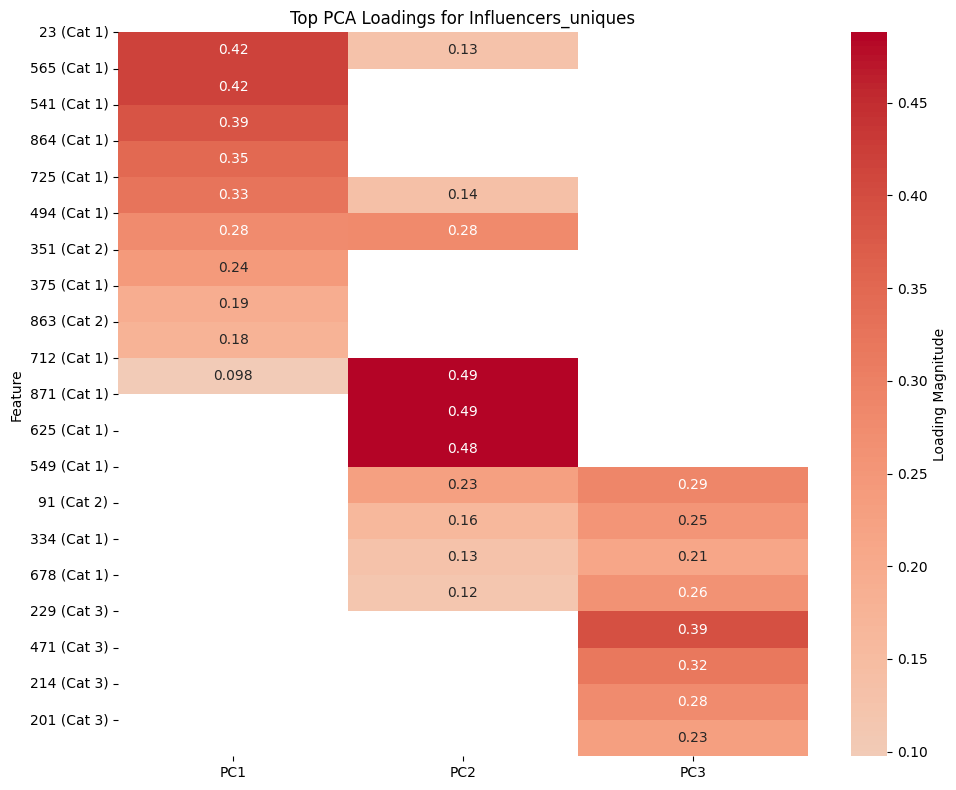

In [456]:
# We taking the data from the previous algoritms results
pca = results_influencers_uniques_cluster['pca']
scaled_data = results_influencers_uniques_cluster['scaled_data']
# Loadings calculation call
results_influencers_uniques_Loadings = calculate_and_analyze_pca_loadings(Influencers_uniques, pca,
                                                                 'scaled_data', 'Influencers_uniques')
# Access the results
loadings_df = results_influencers_uniques_Loadings['Influencers_uniques_loadings_df']
explained_variance = results_influencers_uniques_cluster['explained_variance']
cumulative_variance = results_influencers_uniques_cluster['cumulative_variance']
top_loadings = results_influencers_uniques_Loadings['Influencers_uniques_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components: Influencers_uniques")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_influencers_uniques_Loadings, 'Influencers_uniques')

### Discussing Influencers_uniques Pca Loadings
present still a dominance on cat 1
## 13.8. Merged_selected Pca Loadings

Explained Variance Ratio: [0.20605254 0.18015256 0.11248123]
Cumulative Variance Ratio: [0.20605254 0.3862051  0.49868633]

Loading Vectors:
        PC1     PC2     PC3
238 -0.0269 -0.0126  0.0343
201  0.3595  0.5997 -0.0024
549 -0.0654 -0.0623  0.6708
211  0.3526  0.6035 -0.0054
578 -0.0328 -0.0178 -0.1677
680  0.5958 -0.3796 -0.0153
649  0.6099 -0.3517 -0.0164
541 -0.0440 -0.0246  0.1864
704 -0.0306 -0.0175  0.0631
110 -0.1028 -0.0549 -0.6938

Top Contributors to Principal Components:

PC1 Top Contributors:
649   0.6099
680   0.5958
201   0.3595
211   0.3526
110   0.1028
549   0.0654
541   0.0440
578   0.0328
704   0.0306
238   0.0269
Name: PC1, dtype: float64

PC2 Top Contributors:
211   0.6035
201   0.5997
680   0.3796
649   0.3517
549   0.0623
110   0.0549
541   0.0246
578   0.0178
704   0.0175
238   0.0126
Name: PC2, dtype: float64

PC3 Top Contributors:
110   0.6938
549   0.6708
541   0.1864
578   0.1677
704   0.0631
238   0.0343
649   0.0164
680   0.0153
211   0.0054
201   0.00

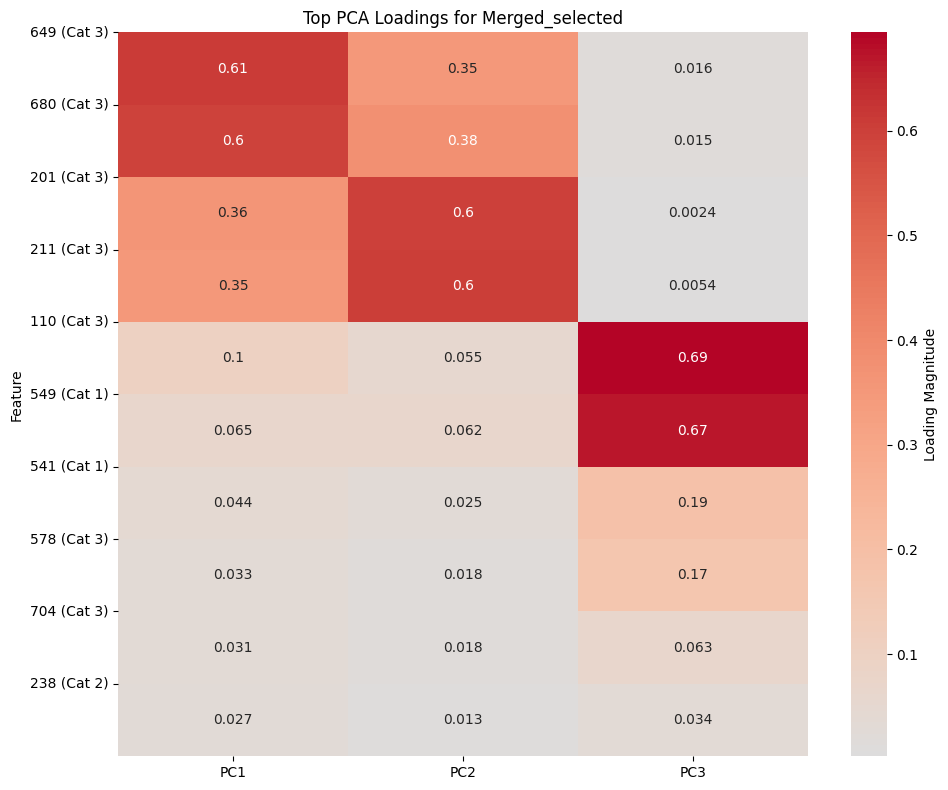

In [457]:
# We taking the data from the previous algoritms results
pca = results_Merged_selected_cluster['pca']
scaled_data = results_Merged_selected_cluster['scaled_data']
# Loadings calculation call
results_Merged_selected_Loadings = calculate_and_analyze_pca_loadings(Merged_selected, pca, 'scaled_data', 'Merged_selected')

# Access the results
loadings_df = results_Merged_selected_Loadings['Merged_selected_loadings_df']
explained_variance = results_Merged_selected_cluster['explained_variance']
cumulative_variance = results_Merged_selected_cluster['cumulative_variance']
top_loadings = results_Merged_selected_Loadings['Merged_selected_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Merged_selected_Loadings, 'Merged_selected')

### Discussing Merged_selected
This df gives very strong signal for features 354 PC5 and also PC4. PC3 has some contributors such as 110, 491, 561, which could have some biological significance. Same for PC2 with 110, 549 and 18. PC1 could be represented only by 214, 140, 572 and 18.

## 13.9. old_new Loadings visualisation with category information

Explained Variance Ratio: [0.1522022  0.10808356 0.10036669]
Cumulative Variance Ratio: [0.1522022  0.26028576 0.36065245]

Loading Vectors:
        PC1     PC2     PC3
154  0.3708 -0.2065  0.0708
201  0.2220  0.1116  0.0221
214  0.4401 -0.1382  0.0430
229  0.5040 -0.2186  0.0893
334 -0.0631 -0.0411 -0.1595
351 -0.1332 -0.0589  0.5990
354 -0.1459 -0.1732  0.5315
408  0.2104  0.2478  0.1072
497  0.4150 -0.1251  0.0645
512  0.1000  0.5844  0.1608

Top Contributors to Principal Components:

PC1 Top Contributors:
229   0.5040
214   0.4401
497   0.4150
154   0.3708
201   0.2220
408   0.2104
584   0.2020
354   0.1459
351   0.1332
565   0.1280
Name: PC1, dtype: float64

PC2 Top Contributors:
512   0.5844
581   0.5607
606   0.2613
408   0.2478
229   0.2186
154   0.2065
354   0.1732
214   0.1382
583   0.1283
497   0.1251
Name: PC2, dtype: float64

PC3 Top Contributors:
351   0.5990
354   0.5315
565   0.3278
583   0.2972
621   0.1846
512   0.1608
334   0.1595
581   0.1417
625   0.1413
408   0.10

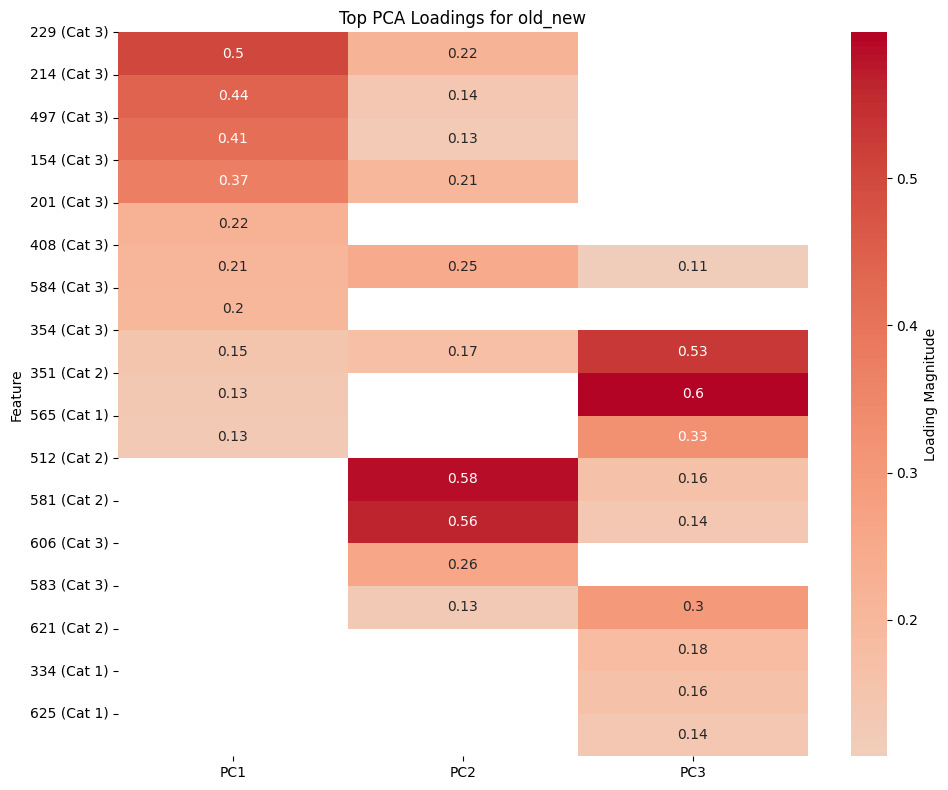

In [458]:
# We taking the data from the previous algoritms results
pca = results_old_new_cluster['pca']
scaled_data = results_old_new_cluster['scaled_data']
# Loadings calculation call
results_old_new_Loadings = calculate_and_analyze_pca_loadings(old_new, pca, 'scaled_data', 'old_new')

# Access the results
loadings_df = results_old_new_Loadings['old_new_loadings_df']
explained_variance = results_old_new_cluster['explained_variance']
cumulative_variance = results_old_new_cluster['cumulative_variance']
top_loadings = results_old_new_Loadings['old_new_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_old_new_Loadings, 'old_new')

## 13.10. Influencers_uniques_selected Loadings visualisation with category information

Explained Variance Ratio: [0.19181685 0.13595012 0.09870431]
Cumulative Variance Ratio: [0.19181685 0.32776697 0.42647128]

Loading Vectors:
        PC1     PC2     PC3
526 -0.0873 -0.1730  0.1201
863  0.2358  0.0753 -0.0870
549  0.0205  0.4229  0.2264
471 -0.0827 -0.2259  0.4478
91   0.0137  0.3462  0.0938
584 -0.0760 -0.1713  0.1889
351  0.2745 -0.0623 -0.0032
408 -0.0827 -0.1359  0.1051
864  0.4085 -0.0561  0.0877
214 -0.0997 -0.2215  0.2363

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4783
565   0.4459
864   0.4085
725   0.3824
351   0.2745
375   0.2658
863   0.2358
229   0.1108
214   0.0997
526   0.0873
Name: PC1, dtype: float64

PC2 Top Contributors:
549   0.4229
712   0.3471
91    0.3462
625   0.3446
229   0.2886
334   0.2808
678   0.2463
471   0.2259
214   0.2215
201   0.1824
Name: PC2, dtype: float64

PC3 Top Contributors:
229   0.5025
471   0.4478
712   0.3476
625   0.3437
214   0.2363
549   0.2264
201   0.1977
584   0.1889
334   0.1382
678   0.12

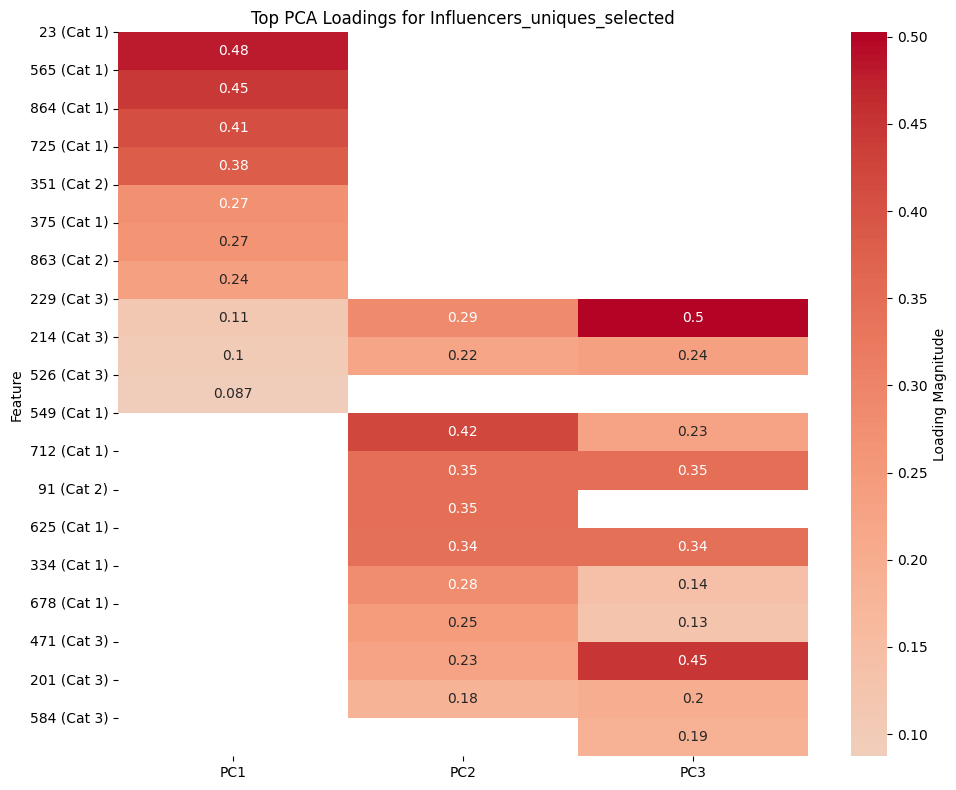

In [459]:
# We taking the data from the previous algoritms results
pca = results_Influencers_uniques_selected_cluster['pca']
scaled_data = results_Influencers_uniques_selected_cluster['scaled_data']
# Loadings calculation call
results_Influencers_uniques_selected_Loadings = calculate_and_analyze_pca_loadings(Influencers_uniques_selected, pca, 'scaled_data', 'Influencers_uniques_selected')

# Access the results
loadings_df = results_Influencers_uniques_selected_Loadings['Influencers_uniques_selected_loadings_df']
explained_variance = results_Influencers_uniques_selected_cluster['explained_variance']
cumulative_variance = results_Influencers_uniques_selected_cluster['cumulative_variance']
top_loadings = results_Influencers_uniques_selected_Loadings['Influencers_uniques_selected_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_uniques_selected_Loadings, 'Influencers_uniques_selected')

## 13.11. Merged_df Loadings

Explained Variance Ratio: [0.07178438 0.06221319 0.05414219]
Cumulative Variance Ratio: [0.07178438 0.13399757 0.18813976]

Loading Vectors:
        PC1     PC2     PC3
512 -0.0775 -0.0278  0.1574
516  0.0525  0.0212 -0.0065
13   0.0011 -0.0200 -0.0827
526 -0.0017  0.0548  0.0519
529 -0.0022 -0.0082 -0.0685
22  -0.0119 -0.0265 -0.0964
23   0.0651  0.2938  0.0133
541  0.0862  0.2555  0.0325
542 -0.0627 -0.0103  0.0959
543  0.0255 -0.0322  0.0590

Top Contributors to Principal Components:

PC1 Top Contributors:
426   0.2382
480   0.2156
90    0.2138
712   0.2095
657   0.2068
871   0.2060
625   0.2032
549   0.1847
79    0.1783
337   0.1682
Name: PC1, dtype: float64

PC2 Top Contributors:
565   0.2967
23    0.2938
636   0.2619
104   0.2619
225   0.2619
872   0.2619
541   0.2555
605   0.2492
725   0.2358
81    0.2155
Name: PC2, dtype: float64

PC3 Top Contributors:
250   0.1888
343   0.1803
456   0.1672
720   0.1641
687   0.1640
546   0.1586
413   0.1585
265   0.1580
243   0.1574
512   0.15

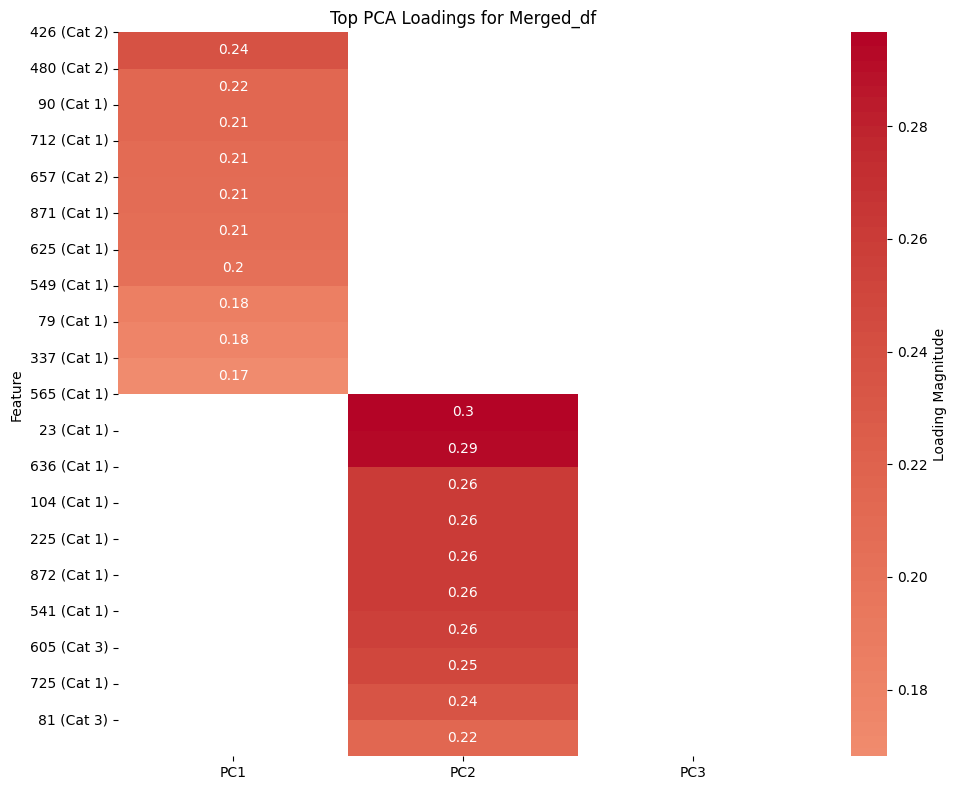

In [460]:
# We taking the data from the previous algoritms results
pca = results_Merged_df_cluster['pca']
scaled_data = results_Merged_df_cluster['scaled_data']
# Loadings calculation call
results_Merged_df_Loadings = calculate_and_analyze_pca_loadings(Merged_df, pca, 'scaled_data', 'Merged_df')

# Access the results
loadings_df = results_Merged_df_Loadings['Merged_df_loadings_df']
explained_variance = results_Merged_df_cluster['explained_variance']
cumulative_variance = results_Merged_df_cluster['cumulative_variance']
top_loadings = results_Merged_df_Loadings['Merged_df_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Merged_df_Loadings, 'Merged_df')

### Conclusions on Loadings Metrics
Looking at the loadings and PCA results across the datasets:
Influencers_OLS shows: Strongest contributors to PC1: 23, 565, 864, 725. PC2: 712, 871, 625, 549, Total variance explained by 5 PCs: 62.33%

Influencers_uniques shows: PC1 led by: 23, 565, 864, 725. PC2: 229, 549, 91, 471. Less total variance explained (54.63%)
Merged_selected shows:
Different pattern with PC1: 214, 323, 572, 526. PC2: 549, 18, 371, 110. Higher total variance explained (66.93%).

# 14. Analysing Loadings by Category
After analysing the loadings we can see that there are some overlapping between features being in the space of the different categories and therefore sort of overlapping as can be seen in the pc1 vs pc2, this in fact is from origing, that the features belog to different categories. This features can have an excellent metrics and the prediction powever be great, however the fact that exist on two different categories on the dataframes different as the dataframe "Influencers" is problematic. Therefore we select this features out moving forward. Influencers Dataset:Has OLS test of significance and has been filtered the overlapping features are statistically validated. They are proven to be meaningful through statistical testing. Instead other Datasets like original_pca, has no OLS validation and overlaps could be due to random variation, noise in the data, or false correlations. As a consequence same feature might show inconsistent behavior across categories, and there is less statistical guarantee that the overlap is meaningful. There is a marked underepresentation of cat 2 in the samples. Even when category 1 : has 17 samples, cat 2: 32 samples, cat 3: 21 samples.
However Cat 1 (no corrosion) and Cat 3 (corrosion) represent clear biological states, Cat 2 might not have unique markers, but rather transitional patterns. This could explain why finding "pure" Cat 2 features is difficult

## 14.1 Analysing Feature Categories using Loadings

In [461]:
def analyze_pca_feature_categories(top_loadings_df, df, analysis_name=""):
    """
    Analyze PCA features to identify their category distribution and overlaps. Includes ALL features in feature_loading_info, including those in multiple categories

    Parameters:
    - top_loadings_df: DataFrame containing PCA loadings and category information

    Returns:
    - Dictionary containing:
        - features_by_category: Dict of sets showing which features belong to each category
        - overlapping_features: Set of features that appear in multiple categories
        - feature_loading_info: Dict with loading information for unique features
    """
    category_weights = {1: 0.2, 2: 0.4, 3: 0.4}
    feature_categories = {
        feature: max({cat: df[df['Category'] == cat][int(feature)].mean() * category_weights[cat]
                     for cat in [1, 2, 3]}.items(),
                    key=lambda x: x[1])[0]
        for feature in top_loadings_df.index
    }

    # Organize by new assignments
    features_by_category = {}
    for feature, category in feature_categories.items():
        if category not in features_by_category:
            features_by_category[category] = set()
        features_by_category[category].add(feature)

    # Find overlapping features
    overlapping_features = set()
    category_pairs = [(1,2), (1,3), (2,3)]
    for cat1, cat2 in category_pairs:
        if cat1 in features_by_category and cat2 in features_by_category:
            overlap = features_by_category[cat1].intersection(features_by_category[cat2])
            if overlap:
                overlapping_features.update(overlap)
                print(f"Features in both Category {cat1} and {cat2}: {overlap}")

    # Get loading information using existing PCA loadings
    feature_loading_info = {}
    pc_columns = [col for col in top_loadings_df.columns if col.startswith('PC')]
    for feature in top_loadings_df.index:
        loading_values = top_loadings_df.loc[feature, pc_columns]
        max_loading = loading_values.max()
        feature_loading_info[feature] = {
            'category': top_loadings_df.loc[feature, 'Category'],
            'max_loading': max_loading,
            'loadings': dict(loading_values),
            'is_overlapping': feature in overlapping_features
        }

    return {
        'features_by_category': features_by_category,
        'overlapping_features': overlapping_features,
        'feature_loading_info': feature_loading_info
    }

def print_pca_category_analysis(analysis_results):
    """
    Print a formatted analysis of the PCA feature categories.

    Parameters: - analysis_results: Dictionary output from analyze_pca_feature_categories
    """
    print("Features by Category:")
    for cat, features in analysis_results['features_by_category'].items():
        print(f"Category {cat}: {sorted(features)}")

    print("\nOverlapping Features:")
    if analysis_results['overlapping_features']:
        for feature in sorted(analysis_results['overlapping_features']):
            info = analysis_results['feature_loading_info'][feature]
            print(f"Feature {feature}: Primary Category {info['category']}, Loading {info['max_loading']:.3f}")
    else:
        print("No overlapping features found")

    print("\nFeature Loading Information:")
    for feat, info in sorted(analysis_results['feature_loading_info'].items()):
        overlap_status = "Overlapping" if info['is_overlapping'] else "Unique"
        print(f"Feature {feat} (Category {info['category']}): {overlap_status}, Max loading = {info['max_loading']:.3f}")

## 14.2. original_pca loadings analysis by category

In [462]:
# Then analyze the category distribution
analysis_results_original_pca = analyze_pca_feature_categories(results_original_pca_Loadings['original_pca_top_loadings_df'], original_pca)
print_pca_category_analysis(analysis_results_original_pca)

#overlaping:
overlapping = analysis_results_original_pca['overlapping_features']

Features by Category:
Category 2: [13, 187, 194, 250, 265, 270, 413, 512, 542, 546, 564, 662, 720, 727, 736]
Category 3: [41, 44, 81, 140, 145, 300, 474, 529, 566, 687]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 13 (Category 2): Unique, Max loading = 0.350
Feature 41 (Category 3): Unique, Max loading = 0.238
Feature 44 (Category 3): Unique, Max loading = 0.272
Feature 81 (Category 3): Unique, Max loading = 0.215
Feature 140 (Category 3): Unique, Max loading = 0.296
Feature 145 (Category 3): Unique, Max loading = 0.200
Feature 187 (Category 2): Unique, Max loading = 0.347
Feature 194 (Category 2): Unique, Max loading = 0.257
Feature 250 (Category 2): Unique, Max loading = 0.326
Feature 265 (Category 2): Unique, Max loading = 0.337
Feature 270 (Category 2): Unique, Max loading = 0.199
Feature 300 (Category 3): Unique, Max loading = 0.358
Feature 413 (Category 2): Unique, Max loading = 0.339
Feature 474 (Category 3): Unique, Max loading = 0.

### Discusing original_pca
this dataframe has a pool of features that do no overlap and that perhaps could be relevant to make up the final df, however it is noticed that only 140 and 474 has some significance regarding abundance and frequency. 
## 14.3. uniques_pca Analysing Loadings by Category

In [463]:
# Then analyze the category distribution
analysis_results_uniques_pca = analyze_pca_feature_categories(results_uniques_pca_Loadings['uniques_pca_top_loadings_df'], uniques_pca)
print_pca_category_analysis(analysis_results_uniques_pca)

#overlaping:
overlapping = analysis_results_uniques_pca['overlapping_features']

Features by Category:
Category 2: [22, 122, 190, 239, 244, 382, 571, 576, 698, 856]
Category 1: [104, 132, 225, 406, 412, 436, 494, 558, 635, 636, 645, 872]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 22 (Category 2): Unique, Max loading = 0.415
Feature 104 (Category 1): Unique, Max loading = 0.405
Feature 122 (Category 2): Unique, Max loading = 0.415
Feature 132 (Category 1): Unique, Max loading = 0.186
Feature 190 (Category 2): Unique, Max loading = 0.335
Feature 225 (Category 1): Unique, Max loading = 0.405
Feature 239 (Category 2): Unique, Max loading = 0.453
Feature 244 (Category 2): Unique, Max loading = 0.415
Feature 382 (Category 2): Unique, Max loading = 0.453
Feature 406 (Category 1): Unique, Max loading = 0.215
Feature 412 (Category 1): Unique, Max loading = 0.215
Feature 436 (Category 1): Unique, Max loading = 0.186
Feature 494 (Category 1): Unique, Max loading = 0.400
Feature 558 (Category 1): Unique, Max loading = 0.186
Featu

## 14.4. uniques23_pca Analysing Loadings by Category

In [464]:
# Then analyze the category distribution
analysis_results_uniques23_pca = analyze_pca_feature_categories(results_uniques23_pca_Loadings['uniques23_pca_top_loadings_df'], uniques23_pca)
print_pca_category_analysis(analysis_results_uniques23_pca)

#overlaping:
overlapping = analysis_results_uniques23_pca['overlapping_features']

Features by Category:
Category 3: [44, 140, 214, 300, 343, 456, 497, 566, 606, 687]
Category 2: [243, 250, 265, 413, 512, 720]
Category 1: [127, 284, 289, 358]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 44 (Category 3): Unique, Max loading = 0.302
Feature 127 (Category 1): Unique, Max loading = 0.246
Feature 140 (Category 3): Unique, Max loading = 0.231
Feature 214 (Category 3): Unique, Max loading = 0.245
Feature 243 (Category 2): Unique, Max loading = 0.249
Feature 250 (Category 2): Unique, Max loading = 0.322
Feature 265 (Category 2): Unique, Max loading = 0.366
Feature 284 (Category 3): Unique, Max loading = 0.241
Feature 289 (Category 1): Unique, Max loading = 0.248
Feature 300 (Category 3): Unique, Max loading = 0.277
Feature 343 (Category 3): Unique, Max loading = 0.260
Feature 358 (Category 1): Unique, Max loading = 0.236
Feature 413 (Category 2): Unique, Max loading = 0.368
Feature 456 (Category 3): Unique, Max loading = 0.255
Fe

## 14.5. Influencers_OLS Analyis Loadings by Category

In [465]:
# Then analyze the category distribution
analysis_results_Influencers_OLS = analyze_pca_feature_categories(results_Influencers_OLS_Loadings['Influencers_OLS_top_loadings_df'],
                                                                    Influencers_OLS)
print_pca_category_analysis(analysis_results_Influencers_OLS )

# overlapping
overlapping = analysis_results_Influencers_OLS['overlapping_features']

Features by Category:
Category 1: [23, 334, 351, 375, 549, 565, 625, 678, 712, 725, 864, 871]
Category 2: [91, 863]
Category 3: [214, 229, 471, 526]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.481
Feature 91 (Category 2): Unique, Max loading = 0.290
Feature 214 (Category 3): Unique, Max loading = 0.275
Feature 229 (Category 3): Unique, Max loading = 0.445
Feature 334 (Category 1): Unique, Max loading = 0.243
Feature 351 (Category 2): Unique, Max loading = 0.277
Feature 375 (Category 1): Unique, Max loading = 0.266
Feature 471 (Category 3): Unique, Max loading = 0.372
Feature 526 (Category 3): Unique, Max loading = 0.076
Feature 549 (Category 1): Unique, Max loading = 0.293
Feature 565 (Category 1): Unique, Max loading = 0.449
Feature 625 (Category 1): Unique, Max loading = 0.497
Feature 678 (Category 1): Unique, Max loading = 0.200
Feature 712 (Category 1): Unique, Max loading = 0.499
Feature 725 (C

Since Influencers_OLS presents a better visualistion than Influencers_uniques_selected, but the final has better metrics, since the most important part is to analyse the biological significance, we continue with Influencers_OLS and Influencers_uniques to cover all the features without trimming them. 

## 14.6. OLS_all Analyis Loadings by Category

In [466]:
# Then analyze the category distribution
analysis_results_OLS_all = analyze_pca_feature_categories(results_OLS_all_Loadings['OLS_all_top_loadings_df'],
                                                                    OLS_all)
print_pca_category_analysis(analysis_results_OLS_all)

# overlapping
overlapping = analysis_results_OLS_all['overlapping_features']

Features by Category:
Category 1: [23, 79, 88, 90, 334, 337, 410, 426, 428, 480, 494, 541, 549, 565, 605, 625, 657, 678, 712, 725, 871]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.407
Feature 79 (Category 1): Unique, Max loading = 0.389
Feature 88 (Category 3): Unique, Max loading = 0.345
Feature 90 (Category 1): Unique, Max loading = 0.324
Feature 334 (Category 1): Unique, Max loading = 0.272
Feature 337 (Category 1): Unique, Max loading = 0.308
Feature 410 (Category 1): Unique, Max loading = 0.126
Feature 426 (Category 2): Unique, Max loading = 0.340
Feature 428 (Category 1): Unique, Max loading = 0.268
Feature 480 (Category 2): Unique, Max loading = 0.334
Feature 494 (Category 1): Unique, Max loading = 0.245
Feature 541 (Category 1): Unique, Max loading = 0.370
Feature 549 (Category 1): Unique, Max loading = 0.328
Feature 565 (Category 1): Unique, Max loading = 0.412
Feature 605 (Category 3): Uni

Discussing OLS_all category on loadings
dataframe OLS has no representation on category 2 nor 3, but 1, however a representative portion was thought to be considered, ultimately due to Class balance problems was no longer considered.

## 14.7. Influencers_uniques Analysing Loadings by Category

In [467]:
# Then analyze the category distribution
analysis_results_Influencers_uniques = analyze_pca_feature_categories(results_influencers_uniques_Loadings['Influencers_uniques_top_loadings_df'],
                                                                    Influencers_uniques)
print_pca_category_analysis(analysis_results_Influencers_uniques)

# overlapping
overlapping = analysis_results_Influencers_uniques['overlapping_features']

Features by Category:
Category 1: [23, 334, 342, 351, 375, 494, 541, 549, 565, 625, 678, 712, 725, 864, 871]
Category 2: [91, 863]
Category 3: [201, 214, 229, 471, 584]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.418
Feature 91 (Category 2): Unique, Max loading = 0.253
Feature 201 (Category 3): Unique, Max loading = 0.232
Feature 214 (Category 3): Unique, Max loading = 0.276
Feature 229 (Category 3): Unique, Max loading = 0.394
Feature 334 (Category 1): Unique, Max loading = 0.212
Feature 342 (Category 1): Unique, Max loading = 0.204
Feature 351 (Category 2): Unique, Max loading = 0.242
Feature 375 (Category 1): Unique, Max loading = 0.193
Feature 471 (Category 3): Unique, Max loading = 0.317
Feature 494 (Category 1): Unique, Max loading = 0.280
Feature 541 (Category 1): Unique, Max loading = 0.388
Feature 549 (Category 1): Unique, Max loading = 0.289
Feature 565 (Category 1): Unique, Max loading = 

## 14.8 old_new Loadings on Category

In [468]:
# Then analyze the category distribution
analysis_results_old_new = analyze_pca_feature_categories(results_old_new_Loadings['old_new_top_loadings_df'],
                                                                    old_new)
print_pca_category_analysis(analysis_results_old_new)

# overlapping
overlapping = analysis_results_old_new['overlapping_features']

Features by Category:
Category 3: [154, 201, 214, 229, 354, 408, 497, 583, 584, 606]
Category 1: [334, 351, 565, 625]
Category 2: [512, 581, 621]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 154 (Category 3): Unique, Max loading = 0.371
Feature 201 (Category 3): Unique, Max loading = 0.222
Feature 214 (Category 3): Unique, Max loading = 0.440
Feature 229 (Category 3): Unique, Max loading = 0.504
Feature 334 (Category 1): Unique, Max loading = 0.160
Feature 351 (Category 2): Unique, Max loading = 0.599
Feature 354 (Category 3): Unique, Max loading = 0.532
Feature 408 (Category 3): Unique, Max loading = 0.248
Feature 497 (Category 3): Unique, Max loading = 0.415
Feature 512 (Category 2): Unique, Max loading = 0.584
Feature 565 (Category 1): Unique, Max loading = 0.328
Feature 581 (Category 2): Unique, Max loading = 0.561
Feature 583 (Category 3): Unique, Max loading = 0.297
Feature 584 (Category 3): Unique, Max loading = 0.202
Feature 606 (Ca

## 14.9. Merged_selected Analysing Loadings by Category

In [469]:
# Then analyze the category distribution
analysis_results_Merged_selected = analyze_pca_feature_categories(results_Merged_selected_Loadings['Merged_selected_top_loadings_df'], Merged_selected)
print_pca_category_analysis(analysis_results_Merged_selected )

# # overlapping
overlapping = analysis_results_Merged_selected ['overlapping_features']

Features by Category:
Category 3: [110, 201, 211, 578, 649, 680, 704]
Category 1: [541, 549]
Category 2: [238]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 110 (Category 3): Unique, Max loading = 0.694
Feature 201 (Category 3): Unique, Max loading = 0.600
Feature 211 (Category 3): Unique, Max loading = 0.604
Feature 238 (Category 2): Unique, Max loading = 0.034
Feature 541 (Category 1): Unique, Max loading = 0.186
Feature 549 (Category 1): Unique, Max loading = 0.671
Feature 578 (Category 3): Unique, Max loading = 0.168
Feature 649 (Category 3): Unique, Max loading = 0.610
Feature 680 (Category 3): Unique, Max loading = 0.596
Feature 704 (Category 3): Unique, Max loading = 0.063


## 14.10. Influencers_uniques_selected Loadings on Category

In [470]:
# Then analyze the category distribution
analysis_results_Influencers_uniques_selected = analyze_pca_feature_categories(results_Influencers_uniques_selected_Loadings['Influencers_uniques_selected_top_loadings_df'],
                                                                    Influencers_uniques_selected)
print_pca_category_analysis(analysis_results_Influencers_uniques_selected)

# overlapping
overlapping = analysis_results_Influencers_uniques_selected['overlapping_features']

Features by Category:
Category 1: [23, 334, 351, 375, 549, 565, 625, 678, 712, 725, 864]
Category 2: [91, 863]
Category 3: [201, 214, 229, 471, 526, 584]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.478
Feature 91 (Category 2): Unique, Max loading = 0.346
Feature 201 (Category 3): Unique, Max loading = 0.198
Feature 214 (Category 3): Unique, Max loading = 0.236
Feature 229 (Category 3): Unique, Max loading = 0.503
Feature 334 (Category 1): Unique, Max loading = 0.281
Feature 351 (Category 2): Unique, Max loading = 0.275
Feature 375 (Category 1): Unique, Max loading = 0.266
Feature 471 (Category 3): Unique, Max loading = 0.448
Feature 526 (Category 3): Unique, Max loading = 0.087
Feature 549 (Category 1): Unique, Max loading = 0.423
Feature 565 (Category 1): Unique, Max loading = 0.446
Feature 584 (Category 3): Unique, Max loading = 0.189
Feature 625 (Category 1): Unique, Max loading = 0.345
Feature 6

##  14.11. Merged_df Loadings on Category

In [471]:
# Then analyze the category distribution
analysis_results_Merged_df = analyze_pca_feature_categories(results_Merged_df_Loadings['Merged_df_top_loadings_df'],
                                                                    Merged_df)
print_pca_category_analysis(analysis_results_Merged_df)

# overlapping
overlapping = analysis_results_Merged_df['overlapping_features']

Features by Category:
Category 1: [23, 79, 90, 104, 225, 337, 426, 480, 541, 549, 565, 605, 625, 636, 657, 712, 725, 871, 872]
Category 3: [81, 343, 456, 687]
Category 2: [243, 250, 265, 413, 512, 546, 720]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.294
Feature 79 (Category 1): Unique, Max loading = 0.178
Feature 81 (Category 3): Unique, Max loading = 0.216
Feature 90 (Category 1): Unique, Max loading = 0.214
Feature 104 (Category 1): Unique, Max loading = 0.262
Feature 225 (Category 1): Unique, Max loading = 0.262
Feature 243 (Category 2): Unique, Max loading = 0.157
Feature 250 (Category 2): Unique, Max loading = 0.189
Feature 265 (Category 2): Unique, Max loading = 0.158
Feature 337 (Category 1): Unique, Max loading = 0.168
Feature 343 (Category 3): Unique, Max loading = 0.180
Feature 413 (Category 2): Unique, Max loading = 0.159
Feature 426 (Category 2): Unique, Max loading = 0.238
Feature 456 

# 15. high_loadings: a compendium
we doing a comprehensive list of possible relevant features that are relevant to each category. From the makers of function __analyze_pca_feature_categories__ and __results_dfs_Loadings['df_top_loadings']__ it is presented here the combination of this dataframes
Let's create the joined dataframe with all the selected features from our analyses. From the makers of analysing
| df | Features by Category |
|---|---|
| Merged_df | Category 1: [23, 79, 90, 104, 225, 337, 426, 480, 541, 549, 565, 605, 625, 636, 657, 712, 725, 871, 872], Category 3: [81, 343, 456, 687],,Category 2: [243, 250, 265, 413, 512, 546, 720]|
| Influencers_uniques| Category 1: [23, 91, 334, 342, 351, 375, 549, 565, 625, 678, 712, 725, 799, 864, 871] Category 2: [863]Category 3: [201, 214, 229, 408, 471, 526, 584]|

In [472]:
def combine_features_from_analyses(analysis_results_Merged_df, 
                                   analysis_results_Influencers_uniques, loading_threshold=0.2):
    """
    Combine features from different analyses with threshold and deduplication.
    Works with output from analyze_pca_feature_categories() function.
    Now includes explicit tracking of features appearing in multiple categories.

    Parameters:
    -----------
    analysis_results_* : dict
        Results from analyze_pca_feature_categories() for each analysis
    loading_threshold : float, optional (default=0.2)
        Minimum loading value to consider a feature relevant

    Returns:
    --------
    tuple : (feature_list, selected_features)
        feature_list : list with 'Category' and selected features
        selected_features : dict with feature information
    """
    selected_features = {}
    feature_categories = {}  # Track all categories where each feature appears

    # Dictionary mapping analysis results to their source names
    analyses = {'Merged_df': analysis_results_Merged_df,'Influencers_uniques': analysis_results_Influencers_uniques}

    # Process each analysis
    for source_name, analysis in analyses.items():
        print(f"\nProcessing features from {source_name}")

        for feature, info in analysis['feature_loading_info'].items():
            # Skip features below threshold
            if abs(info['max_loading']) < loading_threshold:
                continue

            if feature not in selected_features:
                selected_features[feature] = {
                    'category': info['category'],
                    'max_loading': abs(info['max_loading']),
                    'source': source_name,
                    'all_categories': {info['category']}  # Track all categories where feature appears
                }
                # Initialize feature category tracking
                if feature not in feature_categories:
                    feature_categories[feature] = {info['category']}
                else:
                    feature_categories[feature].add(info['category'])
            else:
                # Add category to tracking
                feature_categories[feature].add(info['category'])
                selected_features[feature]['all_categories'].add(info['category'])

                # Print overlap information
                print(f"\nFeature {feature} found in multiple analyses:")
                print(f"Current: {source_name}, loading={abs(info['max_loading']):.3f}, category={info['category']}")
                print(f"Previous: {selected_features[feature]['source']}, "
                      f"loading={selected_features[feature]['max_loading']:.3f}, "
                      f"category={selected_features[feature]['category']}")

                # Keep the version with higher loading
                if abs(info['max_loading']) > selected_features[feature]['max_loading']:
                    selected_features[feature].update({
                        'category': info['category'],
                        'max_loading': abs(info['max_loading']),
                        'source': source_name
                    })
                    print(f"Keeping version from {source_name} due to higher loading")

    # Create feature list with 'Category' first
    feature_list = [['Sites', 'Category']] + list(selected_features.keys())

    # Print summary by category and source
    print("\nFeature Selection Summary:")
    for category in sorted(set(info['category'] for info in selected_features.values())):
        features = [f for f, info in selected_features.items() if info['category'] == category]
        print(f"\nCategory {category} features ({len(features)}):")
        print(f"Features: {sorted(features)}")

    # Print multi-category features
    print("\nFeatures appearing in multiple categories:")
    multi_category_features = {
        feature: categories
        for feature, categories in feature_categories.items()
        if len(categories) > 1
    }

    if multi_category_features:
        for feature, categories in multi_category_features.items():
            print(f"\nFeature {feature}:")
            print(f"  Categories: {sorted(categories)}")
            print(f"  Current assignment: Category {selected_features[feature]['category']} "
                  f"(from {selected_features[feature]['source']} "
                  f"with loading {selected_features[feature]['max_loading']:.3f})")
    else:
        print("No features appear in multiple categories")

    print("\nFeatures by source:")
    for source in analyses.keys():
        source_features = [f for f, info in selected_features.items() if info['source'] == source]
        print(f"\n{source} features ({len(source_features)}):")
        for feature in sorted(source_features):
            info = selected_features[feature]
            print(f"Feature {feature}: Category {info['category']}, Loading {info['max_loading']:.3f}")

    return feature_list, selected_features

def create_combined_feature_df(original_df, feature_list, selected_features):
    """
    Create a dataframe with selected features and their metadata.

    Parameters:
    -----------
    original_df : pd.DataFrame
        Original dataframe containing all features
    feature_list : list
        List of features from combine_features_from_analyses()
    selected_features : dict
        Feature information from combine_features_from_analyses()

    Returns:
    --------
    pd.DataFrame
        Combined dataframe with selected features and metadata
    """
# Debug print
    print("Feature list:", feature_list)

    # Flatten feature list and remove 'Category'
    flat_features = []
    for item in feature_list:
        if isinstance(item, list):
            flat_features.extend(item)
        else:
            flat_features.append(item)

    feature_list_clean = [f for f in flat_features if f != 'Category']

    # Convert to ints
    numeric_features = [int(f) for f in feature_list_clean if f not in ['Sites', 'Category']]

    # Create columns list
    columns = ['Category'] + numeric_features

    # Create DataFrame
    combined_df = original_df[columns].copy(deep=False)

    # Add metadata
    combined_df.attrs['feature_sources'] = {
        feature: f"{info['source']} ({info['max_loading']:.3f})"
        for feature, info in selected_features.items()
        if feature != 'Category'
    }

    return combined_df

In [473]:
# calling the function
feature_list, selected_features = combine_features_from_analyses(analysis_results_Merged_df, 
                                   analysis_results_Influencers_uniques, loading_threshold=0.2)

# Create combined dataframe
high_loadings = create_combined_feature_df(original, feature_list, selected_features)


Processing features from Merged_df

Processing features from Influencers_uniques

Feature 23 found in multiple analyses:
Current: Influencers_uniques, loading=0.418, category=1
Previous: Merged_df, loading=0.294, category=1
Keeping version from Influencers_uniques due to higher loading

Feature 565 found in multiple analyses:
Current: Influencers_uniques, loading=0.415, category=1
Previous: Merged_df, loading=0.297, category=1
Keeping version from Influencers_uniques due to higher loading

Feature 541 found in multiple analyses:
Current: Influencers_uniques, loading=0.388, category=1
Previous: Merged_df, loading=0.256, category=1
Keeping version from Influencers_uniques due to higher loading

Feature 725 found in multiple analyses:
Current: Influencers_uniques, loading=0.326, category=1
Previous: Merged_df, loading=0.236, category=1
Keeping version from Influencers_uniques due to higher loading

Feature 712 found in multiple analyses:
Current: Influencers_uniques, loading=0.488, categ

Looking at the analysis, the old_new data has good or even better representation from class 2, and I'm not entirely convinced that OLS_all's data is that relevant. There's a significant imbalance in class 2 representation, which is puzzling given that in reality the sample distribution was: class 1 (17 samples), class 2 (32 samples), and class 3 (21 samples). Currently, category 2 features are very limited, coming only from:

Influencers: just one feature (863); Merged_selected: one feature (270); old_new data: two features (512, 581)

There are still class 2 features from original_pca that I'm unsure whether to use, since those only got an influence pca test undergoing and no an OLS significance test and were also no accounted by abundancy and frequency as the Influencers dataframe were. My strategy is to create a new dataframe from this selection and analyze which features from classes 1 and 3 fall into the space of class 2, and then trim them out. For this purpose, a script on the next section 15.2 is created in 3D scatter plot that relates PCA to loadings to original data.

## 15.2 Verification High_loading pca and prediction pipelines

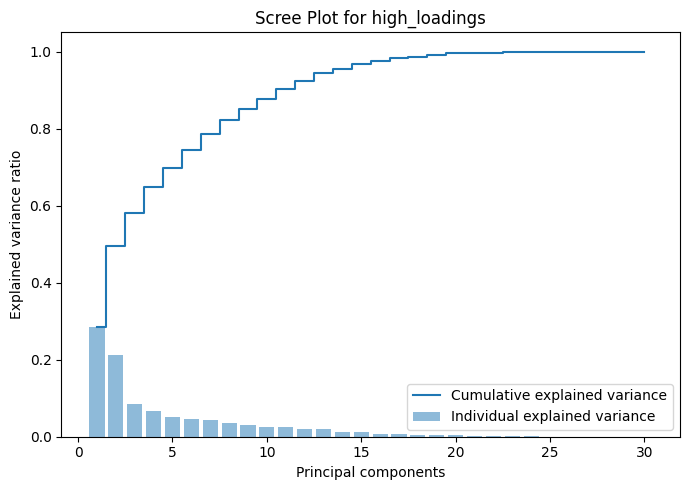

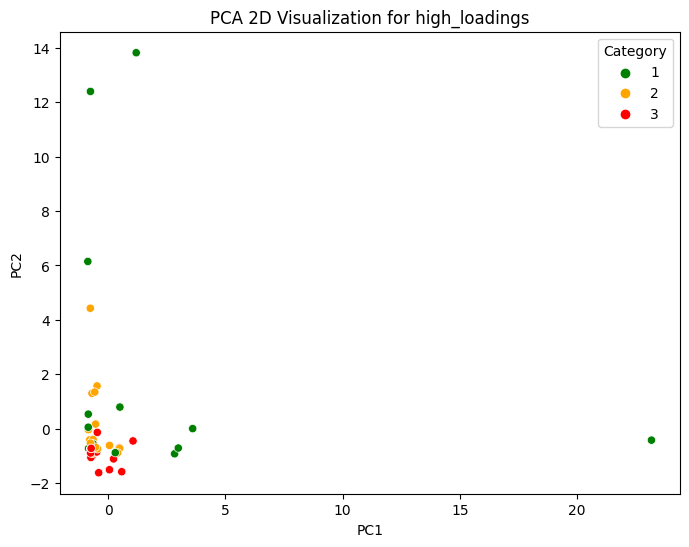

high_loadings_pipeline:
high_loadings_pipeline:
Cross-Validation MAE Scores for RF: [0.7958, 0.7745, 0.426, 0.3488, 0.4891]
Average MAE for RF: 0.5668
Mean Squared Error: 0.3341
Root Mean Squared Error: 0.578
Mean Absolute Error: 0.5045
Feature Importance by RF:     Features  Importance
20       549      0.4350
8         23      0.0954
26       214      0.0651
17       864      0.0503
24       229      0.0481
21        91      0.0405
6        625      0.0369
19       351      0.0335
22       334      0.0326
16        81      0.0267
25       471      0.0227
5        871      0.0223
23       678      0.0152
28       584      0.0152
7        565      0.0129
15       725      0.0098
0        426      0.0087
3        712      0.0080
14       605      0.0072
1        480      0.0059
29       342      0.0039
13       541      0.0019
4        657      0.0015
2         90      0.0003
9        636      0.0002
high_loadings_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.4167, 0.3636, 0.4545, 0.4545, 0.5455]
Average F1-Score: 0.447
Precision: [0.4722, 0.202, 0.3506, 0.3364, 0.5091]
Average Precision: 0.3741
Recall: [0.4167, 0.3636, 0.4545, 0.4545, 0.5455]
Average Recall: 0.447
F1-Score: [0.425, 0.2597, 0.3939, 0.3843, 0.5253]
Average F1-Score: 0.3976

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 5 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.50      0.71      0.59         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.61      0.43      0.46        14
weighted avg       0.56      0.50      0.48        14


Feature Importance:
    Features  Importance
20       549      0.1442
26       214      0.0907
21        91      0.0818
24       229      0.0785
8         23      0.0779
17       864      0.0729
19     

In [474]:
# Aply pipeline for visual results
results_high_loadings = pca_pipeline(high_loadings, 'Category', n_components=2, dataset_name='high_loadings')

# Apply the pipeline for numerical results
high_loadings_pipeline, df_pca_influence_high_loadings, explained_variance_high_loadings, n_components = apply_pipeline_pca(high_loadings, "high_loadings", n_components=2, n_top_features=20)

# Apply pipeline Regression
high_loadings_pipeline_reg, importances_reg_high_loadings= apply_pipeline_regressor(high_loadings, "high_loadings")
# Apply the pipeline Classification
high_loadings_pipe_class, importances_class_high_loadings, high_loadings_feature_scores = apply_classification_pipeline_classif(high_loadings, "high_loadings")

Acuracy is reduce and the metrics are no as good as the smaller set of Influencers_OLS, however it is a set that is more comprehensive and has bigger set of features that could posses a biological significate, the patterns of the pca can be misleading since this is just 2d, however the categories 1 and 3 are very well defined on their own planes, with category 2 presented on a middle space with many problematic overlaps.

## 15.3. Highloadings clustering

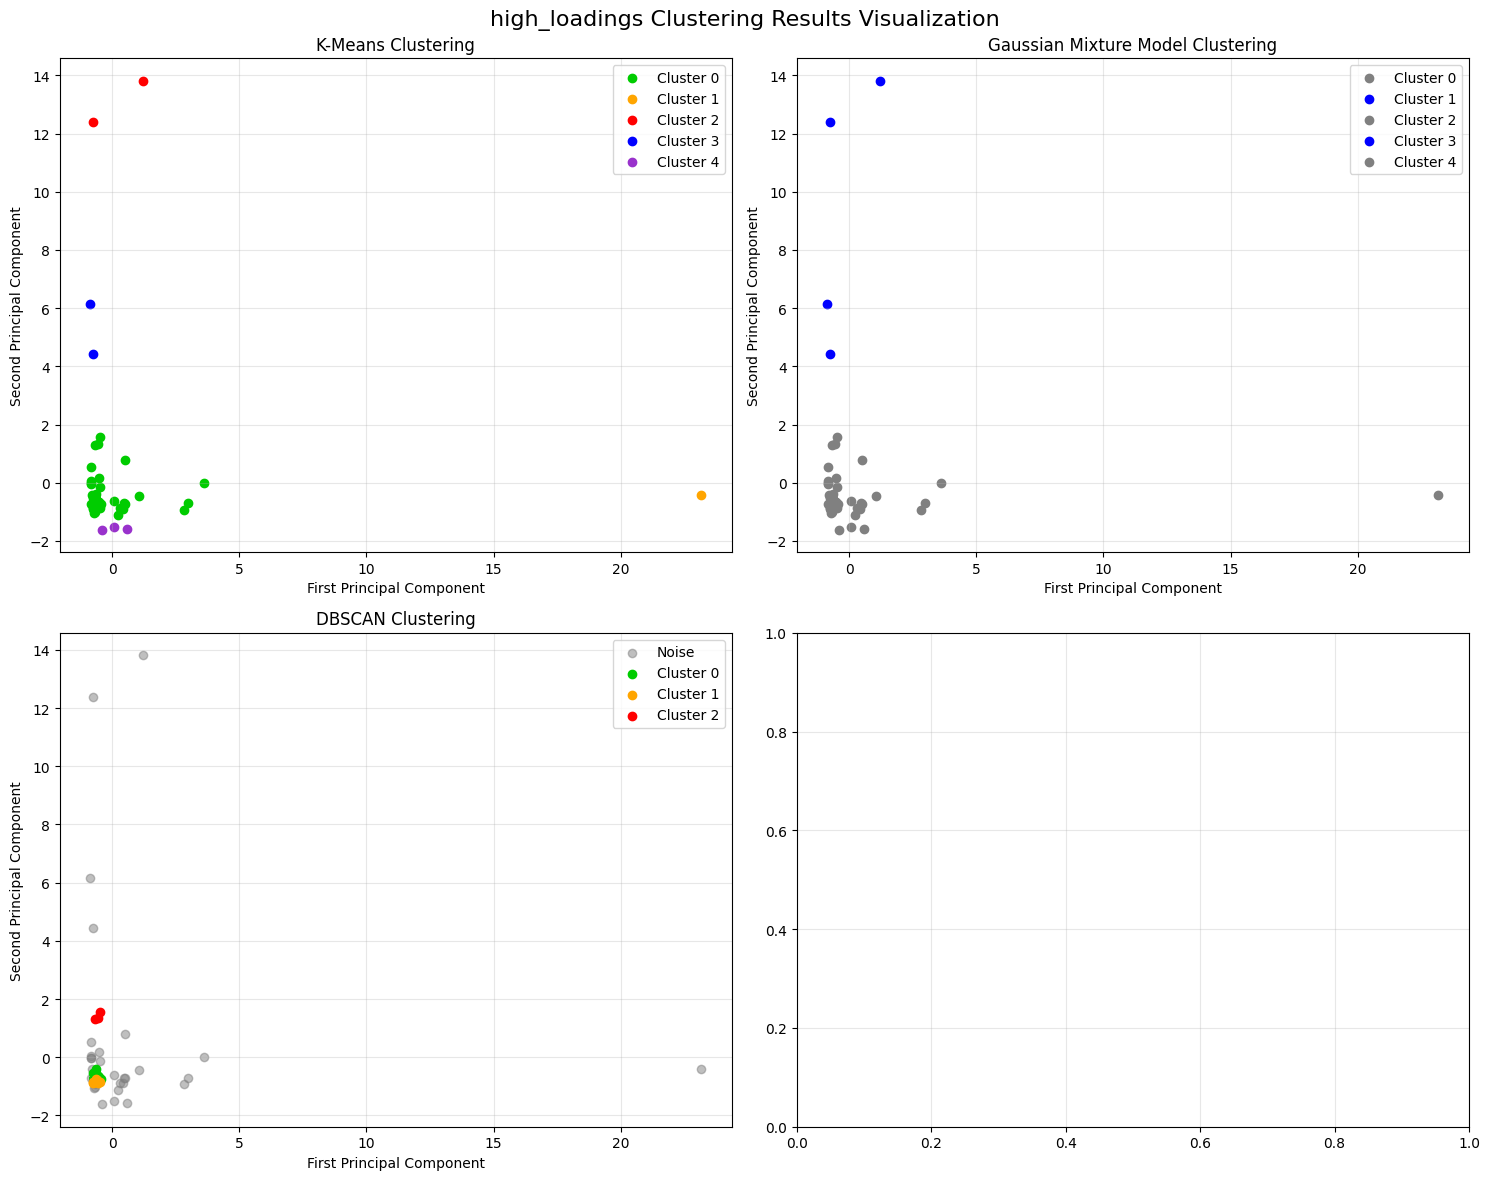


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.6516
Silhouette Score: 0.686180848678973
Davies-Bouldin Score: 0.392345765694981
Adjusted Rand Score: 0.055020082435370356

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 1 points
Cluster 2: 2 points
Cluster 3: 2 points
Cluster 4: 3 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.4250
Silhouette Score: 0.7783512306512976
Davies-Bouldin Score: 0.2780751634090101
Adjusted Rand Score: 0.10300698488691987

Cluster Sizes:
Cluster 0: 30 points
Cluster 1: 7 points
Cluster 2: 3 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.9738
Silhouette Score: 0.26128284671452484
Davies-Bouldin Score: 1.2363395769627297
Adjusted Rand Score: 0.06116544391213224

Cluster Sizes:
Cluster 0: 26 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 2 points
Cluster 4: 39 points

PCA Explained Variance Ratio:
PC1: 28.47%
PC2: 21.16%
PC3: 8.48%
Total Variance Explained (first 10 PCs)

In [475]:
# Running pipeline
results_high_loadings_cluster = clustering_pipeline_all(high_loadings,  pca_data_name='pca_data_high_loadings ',
                                                   n_clusters=5, eps=0.3, min_samples=3, n_components=3)
#Calling the function for visualisation
visualize_clustering_results(results_high_loadings_cluster, title_prefix='high_loadings')
print_clustering_metrics(results_high_loadings_cluster )

Analysing the clustering mapping with the original pca where the risk labels are distingushed, it is possible to note the correspondence of category 1 with clusters 0 and 4, category 2 being overhelminly mixed up corresponding to cluster 2 roughly and category 3 distintive clusters 1 and 3.

## 15.4. high_loadings Analysing and visualising Calculate_and_analyze_pca_loadings

Explained Variance Ratio: [0.28470641 0.21163438 0.08482104]
Cumulative Variance Ratio: [0.28470641 0.4963408  0.58116184]

Loading Vectors:
        PC1     PC2     PC3
426  0.0024  0.3379 -0.0621
480 -0.0076  0.3539  0.0124
90   0.0056  0.3634  0.1288
712  0.0015  0.3747  0.1365
657 -0.0110  0.3014 -0.0403
871  0.0008  0.3744  0.1374
625 -0.0003  0.3686  0.1339
565  0.3279 -0.0119 -0.0655
23   0.3103 -0.0223 -0.0398
636  0.3267 -0.0079 -0.0025

Top Contributors to Principal Components:

PC1 Top Contributors:
565   0.3279
636   0.3267
225   0.3267
872   0.3267
104   0.3267
541   0.3122
23    0.3103
605   0.2373
864   0.2336
81    0.2225
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.3747
871   0.3744
625   0.3686
90    0.3634
480   0.3539
426   0.3379
657   0.3014
494   0.2189
549   0.1705
91    0.1157
Name: PC2, dtype: float64

PC3 Top Contributors:
229   0.4664
471   0.3782
214   0.3179
549   0.2823
81    0.2729
91    0.2371
584   0.2314
678   0.2227
334   0.2048
201   0.17

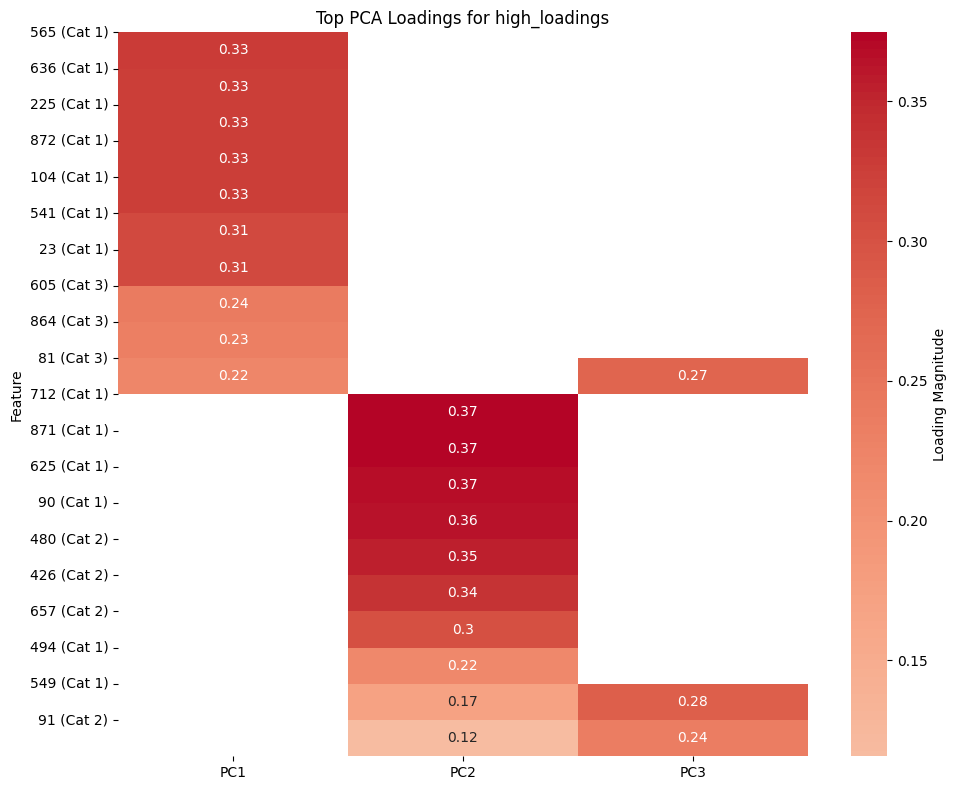

In [476]:
# We taking the data from the previous algoritms results
pca = results_high_loadings_cluster['pca']
scaled_data = results_high_loadings_cluster['scaled_data']
# Loadings calculation call
results_high_loadings_Loadings = calculate_and_analyze_pca_loadings(high_loadings, pca, 'scaled_data', 'high_loadings')

# Access the results
loadings_df = results_high_loadings_Loadings['high_loadings_loadings_df']
explained_variance = results_high_loadings_cluster['explained_variance']
cumulative_variance = results_high_loadings_cluster['cumulative_variance']
top_loadings = results_high_loadings_Loadings['high_loadings_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings with category analysis (double heatmap):
plot_top_pca_loadings(results_high_loadings_Loadings, 'high_loadings')

## 15.5. high_loadings Analysis of Loadings by Category

In [477]:
# Then analyze the category distribution
analysis_results_high_loadings = analyze_pca_feature_categories(results_high_loadings_Loadings['high_loadings_top_loadings_df'], high_loadings)
print_pca_category_analysis(analysis_results_high_loadings)

#overlaping:
overlapping = analysis_results_high_loadings['overlapping_features']

Features by Category:
Category 1: [23, 90, 104, 225, 334, 426, 480, 494, 541, 549, 565, 605, 625, 636, 657, 678, 712, 864, 871, 872]
Category 3: [81, 201, 214, 229, 471, 584]
Category 2: [91]

Overlapping Features:
No overlapping features found

Feature Loading Information:
Feature 23 (Category 1): Unique, Max loading = 0.310
Feature 81 (Category 3): Unique, Max loading = 0.273
Feature 90 (Category 1): Unique, Max loading = 0.363
Feature 91 (Category 2): Unique, Max loading = 0.237
Feature 104 (Category 1): Unique, Max loading = 0.327
Feature 201 (Category 3): Unique, Max loading = 0.171
Feature 214 (Category 3): Unique, Max loading = 0.318
Feature 225 (Category 1): Unique, Max loading = 0.327
Feature 229 (Category 3): Unique, Max loading = 0.466
Feature 334 (Category 1): Unique, Max loading = 0.205
Feature 426 (Category 2): Unique, Max loading = 0.338
Feature 471 (Category 3): Unique, Max loading = 0.378
Feature 480 (Category 2): Unique, Max loading = 0.354
Feature 494 (Category 1): U

## 15.6. 3D Visualisation pca to Loadings to original Feat

In [478]:
def plot_pca_feature_loadings(df, loadings_df, analysis_results, dataset_name=None, plot_3d=False):
    """
    Create a PCA loadings plot showing how features contribute to PC1, PC2, and optionally PC3.
    Uses the output from analyze_pca_feature_categories for category information.

    Parameters:
    -----------
    loadings_df : pandas DataFrame. DataFrame containing the PCA loadings with features as index and PCs as columns
    analysis_results : dict Output from analyze_pca_feature_categories containing feature categories
    dataset_name : int, Name of the dataset for the plot title
    plot_3d : bool, Whether to create an interactive 3D plot with Plotly
    """
    import plotly.graph_objects as go

    # Convert index to integer
    loadings_df.index = loadings_df.index.astype(int)

    # Compute categories for features just like in the original code
    feature_categories = {}
    for feature in loadings_df.index:
        cat_means = {
            cat: df[df['Category'] == cat][feature].mean()
            for cat in [1, 2, 3]
        }
        feature_categories[feature] = max(cat_means.items(), key=lambda x: x[1])[0]


    # Generate title
    plot_title = f"{dataset_name} - PCA Feature Loadings" if dataset_name else "PCA Feature Loadings"

    # Color mapping
    color_map = {1: '#00CC00', 2: '#FFA500', 3: '#FF0000'}

    if plot_3d:
        # Create 3D Plotly figure
        fig = go.Figure()

        # Add arrows for each feature
        for feature in loadings_df.index:
            pc1_loading = loadings_df.loc[feature, 'PC1']
            pc2_loading = loadings_df.loc[feature, 'PC2']
            pc3_loading = loadings_df.loc[feature, 'PC3']

            # Get category from our computed categories
            category = feature_categories[feature]
            color = color_map[category]

            # Add line from origin to loading point
            fig.add_trace(go.Scatter3d(
                x=[0, pc1_loading],
                y=[0, pc2_loading],
                z=[0, pc3_loading],
                mode='lines',
                line=dict(color=color, width=5),
                name=f'Feature {feature} (Cat {category})'
            ))

            # Add text label at loading point
            fig.add_trace(go.Scatter3d(
                x=[pc1_loading],
                y=[pc2_loading],
                z=[pc3_loading],
                mode='text',
                text=[(feature)],
                textposition='top center',
                name=f'Label {feature}'
            ))

        # Update layout
        fig.update_layout(
            title=plot_title,
            width=1200,
            height=800,
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3',
                aspectmode='cube',
                camera=dict(
                    up=dict(x=0, y=0, z=1),
                    center=dict(x=0, y=0, z=0),
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            showlegend=True
        )

    else:
        # 2D matplotlib plot
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        # Create arrows from origin to loading points
        for feature in loadings_df.index:
            pc1_loading = loadings_df.loc[feature, 'PC1']
            pc2_loading = loadings_df.loc[feature, 'PC2']

            # Get category from our computed categories
            category = feature_categories[feature]
            color = color_map[category]

            # Draw arrow
            ax.arrow(0, 0, pc1_loading, pc2_loading,
                    color=color, alpha=0.6, head_width=0.02, head_length=0.02, width=0.005)

            # Add feature name
            ax.text(pc1_loading*1.1, pc2_loading*1.1, (feature),
                   fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

        # Add reference lines
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)

        # Set equal aspect ratio
        ax.set_aspect('equal')

        # Set limits
        max_val = max(abs(loadings_df[['PC1', 'PC2']]).max().max() * 1.2, 1.0)
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)

        # Labels and title
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(plot_title)

        # Add legend
        legend_elements = [plt.Line2D([0], [0], color=color, label=f'Category {cat}',
                                    linewidth=3) for cat, color in color_map.items()]
        ax.legend(handles=legend_elements, fontsize=10)

        ax.grid(True, alpha=0.3)
        plt.tight_layout()

    # Show the appropriate plot
    if plot_3d:
        fig.show()
    else:
        plt.show()

## 15.7. Influencers_uniques 3D

In [479]:
# From the loadings dataframe:Influencers_uniques
plot_pca_feature_loadings(Influencers_uniques, results_influencers_uniques_Loadings['Influencers_uniques_loadings_df'],
                                                analysis_results_Influencers_uniques,"Influencers_uniques", plot_3d=True)

## 15.8. Influencers_OLS 3D Visualisation

In [480]:
# From the loadings dataframe:Influencers_OLS    # , dataset_name="Influencers_OLS"
plot_pca_feature_loadings(Influencers_OLS, results_Influencers_OLS_Loadings['Influencers_OLS_loadings_df'],
                                                analysis_results_Influencers_OLS,"Influencers_OLS", plot_3d=True)

## 15.9. Merged_selected 3D visualisation

In [481]:
# From the loadings dataframe:Merged_selected
plot_pca_feature_loadings(Merged_selected, results_Merged_selected_Loadings['Merged_selected_loadings_df'],
                                                analysis_results_Merged_selected,"Merged_selected", plot_3d=True)

## 15.10 high_loadings 3D visualisation

In [482]:
# From the loadings dataframe:high_loadings
plot_pca_feature_loadings(high_loadings, results_high_loadings_Loadings['high_loadings_loadings_df'],
                                                analysis_results_high_loadings,"high_loadings", plot_3d=True)

In the plot tridimensional space it is possible to differentiate all the different features and their eignevectoren, annotated with the number identifier of the genera. All the categories are on a different plane.
Influencers_uniques and Influencers_OLS are well differentiate between category 1 and category 3, only one feature appears to be in category 2. This however is problematic, because 863, _Variovorax_ has as much abundance on category one 58.8% as in category two 59% however the occurency by sites is 10 to 19 increase. 
Merged_selected df has mostly category 3, showing the effects of the weighting it was put for balancing the classes. All features are well differenciated except for 704, _Syntrophorhabdus_
which appears on the same space as category 3 features being itself label as category 1. Maybe falsely annotated? Which ever the reason, it is no possible to use it because of the location on the same space that category 3.
High_loadings df shows feature 606,_Rhodobacter_ labeled as category 1 but being in the space of category 3. This is problematic because this is present on all the categories merely increasing, being actually more frequent on category 3 increasingly, however the abundance on the category 1 is bigger, perhaps that is why the algoritm put it there. 512, _Oxobacter_ it is in the correct space because it increases with the risk label, however the algoritm put is on color 2 because it has more abundance on category 2. 581, _Erysipelotrichaceae, PSB-M-3_ is also in category 3 space being orange colored, this is because of the abundance on category 2 is bigger by a 0,3%


# 16. Selection

Features 549, 214, 229, and 526 consistently appear important across datasets, though their contributions vary, suggesting different underlying structures. The improved color separation in clustering visualizations indicates feature 549's importance may relate to cluster separation. While DBSCAN showing mostly noise suggests the structure isn't density-based, the clear category-linked patterns in other clustering methods indicate strong discriminative potential. In order to select the features contributing to the risk label and no to neglect any important data points, a discriminative selection would take place. The mapping of the cluster to the categories would be done for each of the dataframes, so to be more precise. The discriminative selection of the features can be done to take into account all the metrics presented in this notebook, so no to prescind of important genera.

## 16.1. Adjusted Rand Index (ARI): Mapping of Clusters to Category
To properly evaluate feature importance, we need to map clusters to their corresponding categories for each dataframe. This mapping allows us to assess how well the clustering aligns with our known categories. The ARI will measure this alignment, adjusting for chance agreement. We'll analyze these key dataframes:

original_pca: Baseline for comparison
Influencers_uniques_selected: Current best performer with highest classification accuracy
Merged_selected: Combined features from multiple analyses
old_new: Previous feature selections that showed promise

In [483]:
# Define mappings for each mappable dataset based on clustering analysis
mappings = {
'Influencers_OLS': {   # from 4.4. and 11.4
        1:1, 3:1, # v shape - v shape Category 1 green
        4:2,   # middle Category 2 yellow
        0:3, 2:3     # Linear Category 3  red
    },
    'Influencers_uniques': { # from 8.1. and 11.6
      1:1, 2:1, 4:1, # No really but the best possible
      3:2,      # middle Category 2 yellow
      0:3       # # Linear Category 3  red
    },
    'Merged_selected': { # from 8.1. and 11.6
      3:1, 4:1,
      0:2,      # middle Category 2 yellow
      1:3, 2:3       # # Linear Category 3  red
    },
    'old_new': { # from 8.1. and 11.8
      1:1,
      4:2,
      0:3, 2:3, 3:3
    },
    'high_loadings': { # from 14.10
      1:1, 2:1,
      3:2,
      4:3, 0:3
    },
}
# Function to apply mapping and calculate ARI
def calculate_mapped_ari(df, df_name, cluster_labels):
    mapping = mappings[df_name]
    mapped_labels = np.array([mapping[label] for label in cluster_labels])
    true_labels = df['Category']
    return adjusted_rand_score(true_labels, mapped_labels), mapped_labels

# Store results for each dataset
mapping_results = {}
for df_name in mappings.keys():
    if df_name == 'Influencers_OLS':
        labels = results_Influencers_OLS_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Influencers_OLS, df_name, labels)
        mapping_results[df_name] = {
            'ari': ari,
            'mapped_labels': mapped
        }

    elif df_name == 'Influencers_uniques':
        labels = results_influencers_uniques_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Influencers_uniques, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }
    elif df_name == 'Merged_selected':
        labels = results_Merged_selected_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Merged_selected, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }
    elif df_name == 'old_new':
        labels = results_old_new_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(old_new, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }
    elif df_name == 'high_loadings':
        labels = results_high_loadings_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(high_loadings, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }

## 16.2. Performance Comparison Calculation and Visualisation
Before proceeding with discriminative selection, we evaluated the overall performance of our key dataframes using multiple metrics. These include PCA variance explained, classification accuracy, F1 scores, K-means silhouette scores, and clustering ARI.

Performance Metrics Comparison:
               Dataset  PCA_Variance_Explained  Classification_Accuracy  \
0      Influencers_OLS                  0.3553                   0.7857   
1      Merged_selected                  0.3862                   0.4286   
2  Influencers_uniques                  0.3230                   0.7857   
3              old_new                  0.2603                   0.5714   
4        high_loadings                  0.4963                   0.5000   

   Classification_F1  Kmeans_Silhouette  Clustering_ARI  
0             0.7857             0.7025          0.1948  
1             0.4184             0.7537          0.0606  
2             0.7857             0.5934          0.1705  
3             0.5615             0.6428          0.0289  
4             0.4829             0.6862          0.0550  


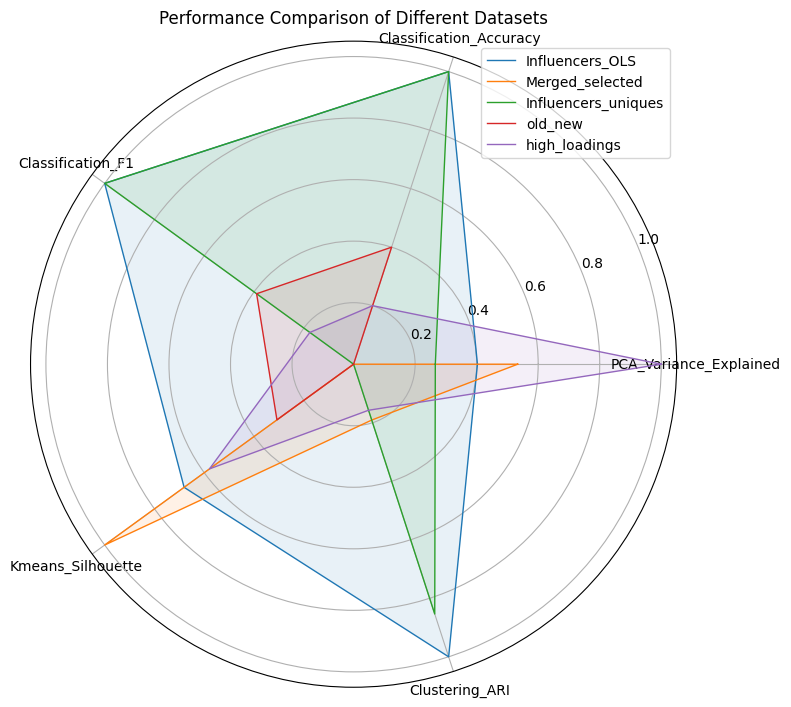

In [484]:
# Compile performance metrics for each dataframe
performance_metrics = pd.DataFrame(columns=[
    'Dataset',
    'PCA_Variance_Explained',
    'Classification_Accuracy',
    'Classification_F1',
    'Kmeans_Silhouette',
    'Clustering_ARI'
])

# Influencers_OLS metrics
influencers_OLS_metrics = pd.DataFrame({
    'Dataset': ['Influencers_OLS'],
    'PCA_Variance_Explained': [results_Influencers_OLS_cluster['explained_variance'][:2].sum()],
    'Classification_Accuracy': Influencers_OLS_feature_scores['accuracy'],  # From section 6.4
    'Classification_F1': Influencers_OLS_feature_scores['f1'],  # From section 6.4
    'Kmeans_Silhouette': [results_Influencers_OLS_cluster['kmeans']['silhouette_score']],
    'Clustering_ARI': [results_Influencers_OLS_cluster['kmeans']['adjusted_rand_score']]
})

# Merged_selected metrics
merged_selected_metrics = pd.DataFrame({
    'Dataset': ['Merged_selected'],
    'PCA_Variance_Explained': [results_Merged_selected_cluster['explained_variance'][:2].sum()],
    'Classification_Accuracy': Merged_selected_feature_scores['accuracy'],    # From section 8.2
    'Classification_F1': Merged_selected_feature_scores['f1'],     # From section 8.2
    'Kmeans_Silhouette': [results_Merged_selected_cluster['kmeans']['silhouette_score']],
    'Clustering_ARI':[results_Merged_selected_cluster['kmeans']['adjusted_rand_score']]
})

# Influencers_uniques_selected metrics
influencers_uniques_metrics = pd.DataFrame({
    'Dataset': ['Influencers_uniques'],
    'PCA_Variance_Explained': [results_influencers_uniques_cluster['explained_variance'][:2].sum()],
    'Classification_Accuracy':Influencers_uniques_feature_scores['accuracy'], # From section 7.1
    'Classification_F1': Influencers_uniques_feature_scores['f1'],       # From section 7.1
    'Kmeans_Silhouette': [results_influencers_uniques_cluster['kmeans']['silhouette_score']],
    'Clustering_ARI': [results_influencers_uniques_cluster['kmeans']['adjusted_rand_score']]
})
# Old_new metrics collection
old_new_metrics = pd.DataFrame({
    'Dataset': ['old_new'],
    'PCA_Variance_Explained': [results_old_new_cluster['explained_variance'][:2].sum()],
    'Classification_Accuracy': old_new_feature_scores['accuracy'],
    'Classification_F1': old_new_feature_scores['f1'],
    'Kmeans_Silhouette': [results_old_new_cluster['kmeans']['silhouette_score']],
    'Clustering_ARI': [results_old_new_cluster['kmeans']['adjusted_rand_score']]
})

# high_loadings metrics collection
high_loadings_metrics = pd.DataFrame({
    'Dataset': ['high_loadings'],
    'PCA_Variance_Explained': [results_high_loadings_cluster['explained_variance'][:2].sum()],
    'Classification_Accuracy': high_loadings_feature_scores['accuracy'],
    'Classification_F1': high_loadings_feature_scores['f1'],
    'Kmeans_Silhouette': [results_high_loadings_cluster['kmeans']['silhouette_score']],
    'Clustering_ARI': [results_high_loadings_cluster['kmeans']['adjusted_rand_score']]
})

# Add metrics to DataFrame
performance_metrics = pd.concat([performance_metrics, influencers_OLS_metrics, merged_selected_metrics,
                        influencers_uniques_metrics, old_new_metrics, high_loadings_metrics], ignore_index=True)

# Create a radar plot to visualize performance comparison
def radar_plot(df):
    # Prepare the data
    categories = list(df.columns)[1:]  # Skip 'Dataset' column
    n_categories = len(categories)

    # Calculate angles for each axis
    angles = np.linspace(0, 2 *np.pi, n_categories, endpoint=False)
    angles_plot = np.append(angles, angles[0])

    # Normalize the values
    values_norm = df[categories].copy(deep=False)
    for col in categories:
        min_val = values_norm[col].min()
        max_val = values_norm[col].max()
        if max_val == min_val:
            values_norm[col] = 0.5  # Set value if all values are same
        else:
            values_norm[col] = (values_norm[col] - min_val) / (max_val - min_val)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    # Plot data
    for idx, row in values_norm.iterrows():
        values = row.values.tolist()
        values += [values[0]]
        ax.plot(angles_plot, values, linewidth=1, linestyle='solid', label=df.iloc[idx]['Dataset'])
        ax.fill(angles_plot, values, alpha=0.1)

    # Set the labels
    ax.set_xticks(angles)
    ax.set_xticklabels(categories)

    plt.legend(loc='best')
    plt.title('Performance Comparison of Different Datasets')
    plt.tight_layout()
    plt.show()

# Display numeric results
print("Performance Metrics Comparison:")
print(performance_metrics)

# Create visualization
radar_plot(performance_metrics)

Influencers_uniques being a more comprehensive dataframe has still a good general metrics, compared to high_loadings which was expected to perform better. Influencers_OLS still continues to be an all round better df


## 16.3. Discriminative Selection Script
The following script take a comprehensive look to all the metrics taken from the outstanding dataframes comparing them, and makes a discriminative selection of the most relevant Features that get the best score out of all the metrics, the pca influence from section 4, the predictive metrics from section 6, the clusters mapped labels, kmeans clustering results from section 11 and the loadings to refer the metrics to the original features. The idea, to make the selection over the colective dataframes, however features often work together and their importance can be highly context dependent. A feature might appear significant in one dataset combination but less so in another due to feature interacions, only discriminative when combined or in presence of other features. Or could be redundant, or carry same information and when combined with other similar feature then it would appear less significant. Also it could be that some features have a synergistic effect, which increase or supress the discriminative power. Due to that instead of combining all features and metrics. The reduced and still standing dataframes that performed better or have interesting features:
original_pca with the whole dataset information as baseline
old_new -->former selected genera
Influencers_uniques-> best performer
high_lodings-->collection of all other dataframes best features
The dataframes underwent a mapping (17.1) of the cluster to category selection first. A compendium all of the top performer genera would be merge and compared to see if the metrics improve, ultimately for the next step all the best features can be brought without much triming, so that the biological significate be evaluated and then the triming process can be done, if not statistically nor biological relevant.
Following script calculates category separation scores using mean differences and standard deviations. Evaluates cluster alignment using mapped labels. Incorporates Random Forest importance and PCA influence. Combines scores with adjustable weights and returns detailed metrics for each feature.

In [485]:
def select_discriminative_features(
    data,                     # Original dataframe
    mapped_kmeans_labels,     # From our cluster mapping
    feature_importances_rf,   # From Random Forest
    pca_influences,          # From PCA analysis
    n_features=20            # Number of features to select
):
    """
    Select most discriminative features based on multiple criteria
    """
    # Initialize results dictionary
    feature_scores = {}

    # Get feature names (excluding Category and Sites)
    features = [col for col in data.columns if col not in ['Category', 'Sites']]
    category_means = [] # track feature association with categories

    # Calculate separation between categories
    separation_score = 0
    category_weights = {1: 0.2,  # Reduce weight for Cat 1
                        2: 0.4,  # Increase for Cat 2
                        3: 0.4}  # Increase for Cat 3

    for feature in features:
        feature_values = data[feature].values
        category_means = []

        # 1. Category Separation Score
        # Calculate mean and std for each category
        category_stats = {}
        for cat in [1, 2, 3]:
            cat_values = feature_values[data['Category'] == cat]
            mean_val = np.mean(cat_values)
            category_stats[cat] = {
                'mean': mean_val,
                'std': np.std(cat_values),
                'weighted_mean': mean_val * category_weights[cat]}
            category_means.append((cat, mean_val * category_weights[cat]))  # Weight affects category assignment

        dominant_category = max(category_means, key=lambda x: x[1])[0]

        for cat1 in [1, 2, 3]:
            for cat2 in [1,2,3]:
                if cat1 < cat2:
                    mean_diff = abs(category_stats[cat1]['mean'] - category_stats[cat2]['mean'])
                    pooled_std = np.sqrt(category_stats[cat1]['std']**2 + category_stats[cat2]['std']**2)
                    weight = category_weights[cat1] * category_weights[cat2]
                    separation_score += weight * mean_diff / (pooled_std + 1e-10)

        # 2. Cluster Alignment Score. How well feature aligns with mapped clusters
        cluster_values = {}
        for cluster in np.unique(mapped_kmeans_labels):
            cluster_values[cluster] = feature_values[mapped_kmeans_labels == cluster]

        cluster_score = 0
        for cluster1 in cluster_values:
            for cluster2 in cluster_values:
                if cluster1 < cluster2:
                    mean_diff = abs(np.mean(cluster_values[cluster1]) - np.mean(cluster_values[cluster2]))
                    pooled_std = np.sqrt(np.var(cluster_values[cluster1]) + np.var(cluster_values[cluster2]))
                    cluster_score += mean_diff / (pooled_std + 1e-10)

        # 3. Get importance scores
        rf_importance = feature_importances_rf[feature_importances_rf['Features'] == feature]['Importance'].values[0]
        pca_influence = pca_influences[pca_influences['Features'] == feature]['Influence'].values[0]

        # Combine scores with weights
        feature_scores[feature] = {
            'separation_score': separation_score,
            'cluster_score': cluster_score,
            'rf_importance': rf_importance,
            'pca_influence': pca_influence,
            'dominant_category': dominant_category,
            'combined_score': (0.3 * separation_score +
                             0.3 * cluster_score +
                             0.2 * rf_importance +
                             0.2 * pca_influence)}

    # Convert to DataFrame for easier handling
    scores_df = pd.DataFrame.from_dict(feature_scores, orient='index')

    # Select top features
    selected_features = scores_df.nlargest(n_features, 'combined_score')

    # Print feature list
    print("\nTop Discriminative Features:")
    for i, (feature, scores) in enumerate(selected_features.iterrows(), 1):
        print(f"{i}. Feature {feature}: {scores['combined_score']:.4f}, Category: {scores['dominant_category']}")

    return selected_features

## 16.4. Results Discriminative Selection Influencers_OLS and Influencers_uniques_selected

In [486]:
# For Influencers_uniques
selected_features_Influencers_uniques = select_discriminative_features(
                        Influencers_uniques, mapping_results['Influencers_uniques']['mapped_labels'],
                        importances_class_Influencers_uniques, df_pca_influence_Influencers_uniques)
# For Influencers_uniques_selected
selected_features_high_loadings = select_discriminative_features(
                        high_loadings, mapping_results['high_loadings']['mapped_labels'],
                        importances_class_high_loadings, df_pca_influence_high_loadings)


Top Discriminative Features:
1. Feature 863: 1.5572, Category: 2.0
2. Feature 375: 1.5283, Category: 1.0
3. Feature 410: 1.4551, Category: 1.0
4. Feature 23: 1.4445, Category: 1.0
5. Feature 864: 1.4420, Category: 1.0
6. Feature 565: 1.4279, Category: 1.0
7. Feature 725: 1.4196, Category: 1.0
8. Feature 229: 1.3924, Category: 3.0
9. Feature 201: 1.3679, Category: 3.0
10. Feature 541: 1.3088, Category: 1.0
11. Feature 408: 1.2915, Category: 3.0
12. Feature 471: 1.2823, Category: 3.0
13. Feature 526: 1.2571, Category: 3.0
14. Feature 799: 1.2356, Category: 1.0
15. Feature 494: 1.1803, Category: 1.0
16. Feature 584: 1.1428, Category: 3.0
17. Feature 549: 1.0866, Category: 1.0
18. Feature 334: 1.0500, Category: 1.0
19. Feature 342: 1.0495, Category: 1.0
20. Feature 678: 0.9426, Category: 1.0

Top Discriminative Features:
1. Feature 426: 5.3034, Category: 1.0
2. Feature 871: 2.0676, Category: 1.0
3. Feature 657: 2.0587, Category: 1.0
4. Feature 625: 1.7697, Category: 1.0
5. Feature 712: 1.

In [487]:
# For Merged_selected
selected_features_Merged_selected = select_discriminative_features(
                        Merged_selected, mapping_results['Merged_selected']['mapped_labels'],
                        importances_class_Merged_selected, df_pca_influence_Merged_selected)


Top Discriminative Features:
1. Feature 110: 1.6781, Category: 3.0
2. Feature 201: 1.2302, Category: 3.0
3. Feature 549: 0.9856, Category: 1.0
4. Feature 211: 0.9757, Category: 3.0
5. Feature 649: 0.7919, Category: 3.0
6. Feature 680: 0.7762, Category: 3.0
7. Feature 578: 0.7478, Category: 3.0
8. Feature 541: 0.7365, Category: 1.0
9. Feature 704: 0.7017, Category: 3.0
10. Feature 238: 0.5404, Category: 2.0


Top Discriminative Features:
1. Feature 549: 1.9845
2. Feature 334: 1.4321
3. Feature 91: 1.3767
4. Feature 678: 1.3703
5. Feature 863: 1.3634
6. Feature 351: 1.2240
7. Feature 625: 1.1778
8. Feature 864: 1.1706
9. Feature 725: 1.1697
10. Feature 375: 1.1654
11. Feature 526: 1.1312
12. Feature 712: 1.1240
13. Feature 871: 1.1225
14. Feature 410: 1.0727
15. Feature 23: 1.0635
16. Feature 494: 1.0335
17. Feature 799: 1.0002
18. Feature 408: 0.9983
19. Feature 541: 0.9726
20. Feature 214: 0.9622

Top Discriminative Features:
1. Feature 408: 3.2048
2. Feature 584: 2.3142
3. Feature 229: 2.0870
4. Feature 606: 1.7685
5. Feature 549: 1.5129
6. Feature 110: 1.4816
7. Feature 214: 1.4436
8. Feature 23: 1.3777
9. Feature 140: 1.3617
10. Feature 526: 1.3183
11. Feature 497: 1.2787
12. Feature 154: 1.2705
13. Feature 91: 1.2562
14. Feature 725: 1.2498
15. Feature 471: 1.2443
16. Feature 581: 1.2216
17. Feature 470: 1.1959
18. Feature 334: 1.1647
19. Feature 323: 1.1507
20. Feature 351: 1.1089

## 16.5. Parallel Check
We going to check which of the final chosen genera is actually enough represented. It muss be recall that the filtering of the genera in book 1 and 2 was aimed to prescind of the features that were no present on most of the population. If a genera has strong presence on all the data without any preference regarding the label, then ultimately is no going to be capable to elucidate the behaviour of the systems subject to corrosion. Therefore bacteria that is known for its corrosion behaviour in this study, but doesnt correlate to the risk label, can no be used as a marker. The following code analyses the selected featured by dataframe.

In [488]:
import os
def analyze_selected_features(df):
    """
    Analyze frequency and abundance for selected features across categories.
    For each feature, shows its presence and mean abundance in each category.
    """
    # Get feature columns (excluding Sites and Category)
    feature_cols = [col for col in df.columns if col not in ['Sites', 'Category']]

    for feature in feature_cols:
        print(f"\nFeature: {feature}")

        # Analyze presence and abundance by category
        for cat in sorted(df['Category'].unique()):
            # Get data for current category
            cat_data = df[df['Category'] == cat]

            # Count presence (values > 0)
            present_in_cat = (cat_data[feature] > 0).sum()
            total_in_cat = len(cat_data)
            presence_pct = (present_in_cat / total_in_cat * 100)

            # Calculate mean abundance in this category
            cat_mean = cat_data[feature].mean()

            # Print results
            print(f"Category {cat}:")
            print(f"Present in {present_in_cat}/{total_in_cat} sites ({presence_pct:.1f}%)")
            print(f"Overall mean in category: {cat_mean:.4f}")

def categorize_features(df):
    """
    Determine the predominant category for each feature based on frequency and abundance.
    """
    feature_cols = [col for col in df.columns if col not in ['Sites', 'Category']]
    feature_categories = {}

    for feature in feature_cols:
        cat_scores = {}
        for cat in sorted(df['Category'].unique()):
            cat_data = df[df['Category'] == cat]
            # Calculate presence percentage
            present = (cat_data[feature] > 0).sum()
            total = len(cat_data)
            presence_pct = (present/total*100)
            # Calculate mean abundance
            mean_abund = cat_data[feature].mean()
            # Combined score (you can adjust the weights)
            cat_scores[cat] = presence_pct * mean_abund

        # Assign feature to category with highest score
        predominant_cat = max(cat_scores.items(), key=lambda x: x[1])[0]
        feature_categories[feature] = predominant_cat

    return feature_categories


def create_feature_analysis_tables(dfs_dict, output_path= None, output_filename=None, single_sheet=False):
    """
    Create tables analyzing features for multiple dataframes and export to Excel.
    Features are organized by their predominant category.

    Parameters:
    dfs_dict (dict): Dictionary of dataframes with format {'name': dataframe}
    output_filename (str): Name of the Excel file to save results
    single_sheet (bool): If True, puts all tables in one sheet with spacing between them
        """
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    output_file = os.path.join(output_path, output_filename)

    def analyze_single_df(df):
        # Get feature categories
        feature_cats = categorize_features(df)

        # Sort features by their predominant category
        feature_cols = [col for col in df.columns if col not in ['Sites', 'Category']]
        sorted_features = sorted(feature_cols, key=lambda x: (feature_cats[x], x))

        rows = []
        # Add header row showing predominant category for each feature
        cat_row = ['Predominant Category']
        cat_row.extend([f'Cat {feature_cats[feat]}' for feat in sorted_features])
        rows.append(cat_row)

        # Add blank row for spacing
        rows.append([''] * (len(sorted_features) + 1))

        for cat in sorted(df['Category'].unique()):
            freq_row = [f'Frequency Cat {cat}']
            abund_row = [f'Abundance Mean Cat {cat}']

            for feature in sorted_features:
                cat_data = df[df['Category'] == cat]

                # Calculate frequency
                present = (cat_data[feature] > 0).sum()
                total = len(cat_data)
                freq = f'{present}/{total} ({(present/total*100):.1f}%)'

                # Calculate mean abundance
                mean_abund = cat_data[feature].mean()

                freq_row.append(freq)
                abund_row.append(f'{mean_abund:.4f}')

            rows.append(freq_row)
            rows.append(abund_row)

        columns = ['Metric'] + sorted_features
        return pd.DataFrame(rows, columns=columns)

    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        if single_sheet:
            # Put all tables in one sheet with spacing
            current_row = 0
            sheet_name = 'Feature Analysis'

            for df_name, df in dfs_dict.items():
                # Create table for current dataframe
                results_df = analyze_single_df(df)

                # Add dataset name as header
                header_df = pd.DataFrame([f"Dataset: {df_name}"])
                header_df.to_excel(writer, sheet_name=sheet_name,
                                 startrow=current_row, index=False, header=False)

                # Write the actual table
                results_df.to_excel(writer, sheet_name=sheet_name,
                                  startrow=current_row+1, index=False)

                # Update row counter (add rows of table + 3 for spacing)
                current_row += len(results_df) + 4

            # Adjust column widths
            worksheet = writer.sheets[sheet_name]

        else:
            # Create separate sheet for each dataframe
            for df_name, df in dfs_dict.items():
                results_df = analyze_single_df(df)
                sheet_name = df_name[:31]  # Excel sheet names limited to 31 chars

                results_df.to_excel(writer, sheet_name=sheet_name, index=False)

                # Adjust column widths
                worksheet = writer.sheets[sheet_name]
                for idx, col in enumerate(results_df.columns):
                    max_length = max(
                        results_df[col].astype(str).apply(len).max(),
                        len(str(col))
                    )
                    worksheet.column_dimensions[chr(65 + idx)].width = max_length + 2

In [489]:
# Create dictionary of dataframes to analyze
dfs = {
    'original_pca': original_pca, 'uniques_pca': uniques_pca, 'uniques23_pca': uniques23_pca,
    'Influencers_OLS': Influencers_OLS,'uniques23_OLS': uniques23_OLS,
    'Influencers_uniques': Influencers_uniques,
    'old_new': old_new, 'Merged_df': Merged_df,
    'Merged_selected': Merged_selected, 'high_loadings': high_loadings,
}
# Or create single sheet excel file with all tables
create_feature_analysis_tables(dfs_dict=dfs,
                               #output_path = '/content/drive/My Drive/MIC/data',
                               output_path = '~/MIC/2_Micro/data',
                               output_filename= 'feature_analysis_results.xlsx', single_sheet=True)

Features were chosen because there are clear progression patterns across categories, another important criterio was a good discrimination ability, specially for category 3. Consistence presene with meaningul abundance differences. Complementary patterns that together provide better discrimination. Reliability in their signals due to consistence presence absence patters. Additionally the frequency must be ≥3 occurrences and there is no selection of features markers for Category 1. In sumary only looking at real category distinctions
Some of the markers were no truly convincing, however it was rather prefere false positives than false negatives, because false positives can be filtered out later with additional biological validation and cross-referencing with physicochemical data, but missing potential markers (false negatives) could mean losing important biological insights about the corrosion process.The rationale for keeping potentially ambiguous features is that they might be part of important metabolic pathways
Their presence/absence could be environmentally regulated, or might interact synergistically with other bacteria. It is possible that their role might become clearer when analyzed alongside chemical parameters.  

|Dataframe|Features Complying with Criteria|
|---|---|
|original_pca|140, 300, 456, 474, 491, 526, 566|
|uniques_pca|201, 211|
|uniques23_pca|81, 110, 140, 214, 300, 497, 512, 526, 566|
|Influencers_OLS|214, 229, 408, 471, 526, 584|
|uniques23_OLS|140, 201, 214, 229, 470, 584|
|Influencers_uniques|201, 214, 229, 408, 470, 471, 526, 584|
|old_new|154, 201, 214, 229, 354, 408, 497, 512, 581, 583, 584, 621|
|Merged_selected|110, 201, 211|
|high_loadings|110, 154, 201, 211, 214, 229, 354, 408, 471, 497, 512, 581, 583, 584|
|Merged_df|81, 92, 110, 140, 145, 201, 211, 214, 223, 229, 300, 470, 474, 491, 497, 503, 512, 526, 566, 584, 687, 727|

In [490]:
feature_lists = {
    'original_pca': [140, 300, 456, 474, 491, 526, 566],
    'uniques_pca': [201, 211],
    'uniques23_pca': [81, 110, 140, 214, 300, 497, 512, 526, 566],
    'Influencers_OLS': [214, 229, 408, 471, 526, 584],
    'uniques23_OLS': [140, 201, 214, 229, 470, 584],
    'Influencers_uniques': [201, 214, 229, 408, 470, 471, 526, 584],
    'old_new': [154, 201, 214, 229, 354, 408, 497, 512, 581, 583, 584, 621],
    'Merged_selected': [110, 201, 211],
    'high_loadings': [110, 154, 201, 211, 214, 229, 354, 408, 471, 497, 512, 581, 583, 584],
    'Merged_df': [81, 92, 110, 140, 145, 201, 211, 214, 223, 229, 300, 470, 474, 491, 497, 503, 512, 526, 566, 584, 687, 727]
}

# Get unique features
checked_features = set()
for features in feature_lists.values():
    checked_features.update(features)

In [491]:
# Using original to makeup the dataframe from the GIDs
checked= original[['Category'] + [512, 140, 526, 145, 408, 154, 300, 687, 566, 581, 583, 456, 201, 584, 81, 211, 214, 471, 470, 727, 474, 92, 223, 354, 229, 491, 621, 110, 497, 503]]

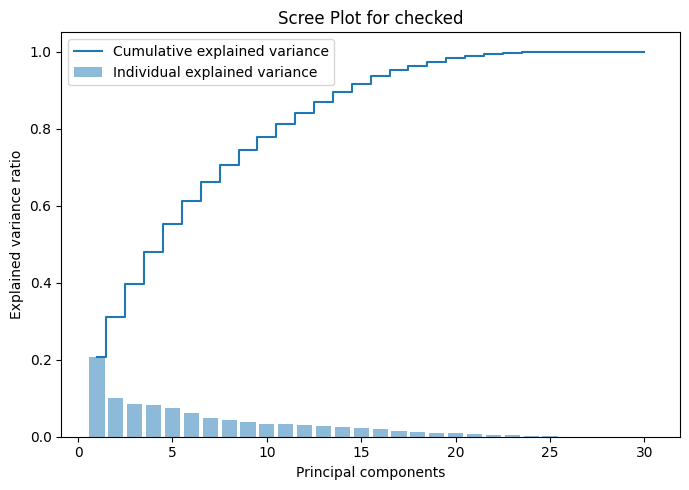

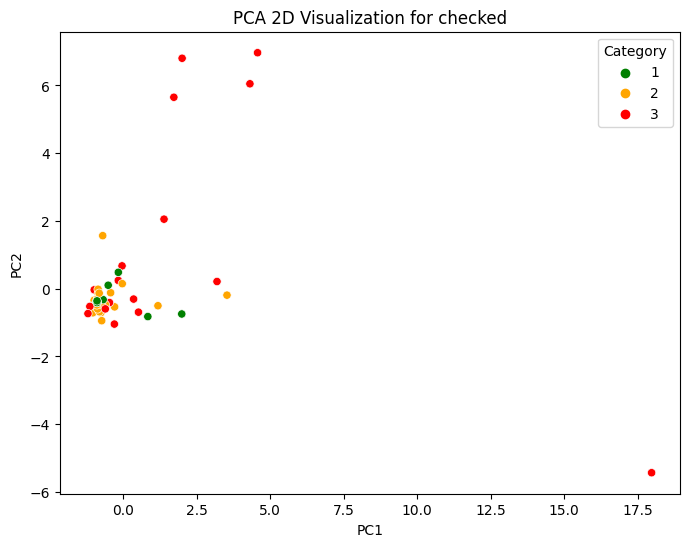

checked_pipeline:
checked_pipeline:
Cross-Validation MAE Scores for RF: [0.6575, 0.7582, 0.5491, 0.3482, 0.7264]
Average MAE for RF: 0.6079
Mean Squared Error: 0.5045
Root Mean Squared Error: 0.7103
Mean Absolute Error: 0.5529
Feature Importance by RF:     Features  Importance
27       110      0.2648
2        526      0.0969
1        140      0.0804
23       354      0.0706
25       491      0.0659
8        566      0.0659
16       214      0.0620
18       470      0.0476
7        687      0.0344
24       229      0.0328
4        408      0.0284
19       727      0.0254
14        81      0.0221
20       474      0.0209
11       456      0.0191
21        92      0.0158
26       621      0.0093
10       583      0.0083
29       503      0.0079
6        300      0.0070
3        145      0.0045
9        581      0.0035
13       584      0.0028
17       471      0.0015
0        512      0.0014
checked_pipeline:
Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Av

In [492]:
# Aply pipeline for visual results
results_checked = pca_pipeline(checked, 'Category', n_components=2, dataset_name='checked')

# Apply the pipeline for numerical results
checked_pipeline, df_pca_influence_checked, explained_variance_checked, n_components = apply_pipeline_pca(checked, "checked", n_components=2, n_top_features=20)

# Apply pipeline Regression
checked_pipeline_reg, importances_reg_checked= apply_pipeline_regressor(checked, "checked")
# Apply the pipeline Classification
checked_pipe_class, importances_class_checked, checked_feature_scores = apply_classification_pipeline_classif(checked, "checked")

## 16.6. Confidence Intervals
This would validate the reliability of the selected features, this gives a range in which the results have more probability of being correct, calculating the selected_features by usign the function discriminative_selection, as well as using the feature_scores coming from the classification pipeline.  

In [493]:
def test_significance_with_ci(df, feature_scores, mapped_kmeans_labels, 
                            feature_importances_rf, pca_influences, n_iterations=1000):
    """
    Test significance with all required parameters for select_discriminative_features
    
    Parameters:
    df: Original dataframe
    feature_scores: Scores from previous select_discriminative_features run
    mapped_kmeans_labels: Required for select_discriminative_features
    feature_importances_rf: Required for select_discriminative_features  
    pca_influences: Required for select_discriminative_features
    n_iterations: Number of bootstrap iterations
    """
    # Initialize results DataFrame using feature names from scores
    results = pd.DataFrame(index=feature_scores['feature_names'])
    
    # Initialize storage arrays, separation_score combined_score
    bootstrap_metrics = np.zeros((n_iterations, 2))
    permuted_metrics = np.zeros((n_iterations, 2))

    category_consensus = {1: {}, 2: {}, 3: {}}  # Track feature assignments
    consensus_counts = np.zeros((len(feature_scores['feature_names']), 3))  # Track counts per category

    for i in range(n_iterations):
        # Bootstrap sample
        bootstrap_df = df.sample(n=len(df), replace=True)
        df_permuted = df.copy(deep=False)
        df_permuted['Category'] = np.random.permutation(df['Category'])
        
        # Get scores using discriminative selection
        bootstrap_scores = select_discriminative_features(bootstrap_df,
                                                       mapped_kmeans_labels,
                                                       feature_importances_rf,
                                                       pca_influences)
        
        permuted_scores = select_discriminative_features(df_permuted,
                                                      mapped_kmeans_labels,
                                                      feature_importances_rf, 
                                                      pca_influences)
        # getting a concensus
        for feat_idx, feature in enumerate(feature_scores['feature_names']):
            #get category from  index 
            if feature in bootstrap_scores.index:
                for cat in [1, 2, 3]:
                    # Calculate weighted category score using both frequency and abundance
                    cat_data = bootstrap_df[bootstrap_df['Category'] == cat][feature]
                    presence_pct = (cat_data > 0).sum() / len(cat_data)
                    mean_abund = cat_data.mean()
                    cat_score = presence_pct * mean_abund
                    consensus_counts[feat_idx, int(cat)-1] += cat_score
            
    # Store metrics
    bootstrap_metrics[i] = [bootstrap_scores['separation_score'].iloc[0], 
                        bootstrap_scores['combined_score'].iloc[0]]
    permuted_metrics[i] = [permuted_scores['separation_score'].iloc[0],
                        permuted_scores['combined_score'].iloc[0]]
    # Calculating consensus percentages and adding to results
    for cat in [1, 2, 3]:
        cat_idx = cat - 1
        results[f'category_{cat}_consensus'] = (consensus_counts[:, cat_idx] / n_iterations) * 100


    # Calculate confidence intervals
    for idx, metric in enumerate(['separation_score', 'combined_score']):
        results[f'{metric}_ci_lower'], results[f'{metric}_ci_upper'] = \
            np.percentile(bootstrap_metrics[:, idx], [2.5, 97.5])
    
    # Calculate p-values
    results[f'{metric}_p_value'] = \
        np.mean([perm >= float(feature_scores['accuracy' if metric == 'separation_score' 
              else 'f1']) for perm in permuted_metrics[:, idx]])
    # Add dominant consensus category
    results['consensus_category'] = np.argmax(consensus_counts, axis=1) + 1
    results['consensus_strength'] = np.max(consensus_counts, axis=1) / n_iterations * 100

    print("\nCategory Consensus Summary:")
    for feature in feature_scores['feature_names']:
        consensus_pcts = [f"Cat {i+1}: {results.loc[feature, f'category_{i+1}_consensus']:.1f}%" for i in range(3)]
        print(f"Feature {feature}: {' | '.join(consensus_pcts)}")
        print(f"    Dominant Category: {results.loc[feature, 'consensus_category']} "
            f"(Consensus: {results.loc[feature, 'consensus_strength']:.1f}%)\n")
    
    return results

In [494]:
Merged_selected_significance = test_significance_with_ci(Merged_selected, Merged_selected_feature_scores,
    mapping_results['Merged_selected']['mapped_labels'], importances_class_Merged_selected, df_pca_influence_Merged_selected, 100)


Top Discriminative Features:
1. Feature 549: 1.0334, Category: 1.0
2. Feature 110: 0.9277, Category: 3.0
3. Feature 541: 0.9126, Category: 1.0
4. Feature 578: 0.7735, Category: 3.0
5. Feature 704: 0.7425, Category: 3.0
6. Feature 211: 0.4660, Category: 3.0
7. Feature 649: 0.4584, Category: 3.0
8. Feature 238: 0.4384, Category: 2.0
9. Feature 201: 0.3994, Category: 3.0
10. Feature 680: 0.3605, Category: 1.0

Top Discriminative Features:
1. Feature 110: 1.6431, Category: 3.0
2. Feature 201: 1.2185, Category: 2.0
3. Feature 549: 0.9494, Category: 2.0
4. Feature 211: 0.9305, Category: 2.0
5. Feature 649: 0.7415, Category: 2.0
6. Feature 680: 0.7294, Category: 2.0
7. Feature 578: 0.7046, Category: 3.0
8. Feature 541: 0.6949, Category: 3.0
9. Feature 704: 0.6570, Category: 2.0
10. Feature 238: 0.5404, Category: 2.0

Top Discriminative Features:
1. Feature 110: 0.8940, Category: 2.0
2. Feature 549: 0.7982, Category: 2.0
3. Feature 578: 0.7061, Category: 3.0
4. Feature 541: 0.6751, Category: 

In [495]:
Influencers_uniques_significance = test_significance_with_ci(Influencers_uniques, Influencers_uniques_feature_scores,
    mapping_results['Influencers_uniques']['mapped_labels'], importances_class_Influencers_uniques,
    df_pca_influence_Influencers_uniques, 100)


Top Discriminative Features:
1. Feature 201: 1.5358, Category: 3.0
2. Feature 408: 1.3857, Category: 3.0
3. Feature 864: 1.3166, Category: 1.0
4. Feature 549: 1.3078, Category: 1.0
5. Feature 471: 1.3078, Category: 3.0
6. Feature 229: 1.3064, Category: 3.0
7. Feature 799: 1.1703, Category: 1.0
8. Feature 541: 1.1665, Category: 1.0
9. Feature 410: 1.1640, Category: 1.0
10. Feature 494: 1.1290, Category: 1.0
11. Feature 375: 1.1242, Category: 1.0
12. Feature 334: 1.1226, Category: 1.0
13. Feature 863: 1.1197, Category: 2.0
14. Feature 526: 1.1133, Category: 3.0
15. Feature 342: 1.0015, Category: 1.0
16. Feature 678: 0.9946, Category: 1.0
17. Feature 91: 0.9554, Category: 2.0
18. Feature 584: 0.8947, Category: 3.0
19. Feature 23: 0.8574, Category: 1.0
20. Feature 351: 0.8557, Category: 1.0

Top Discriminative Features:
1. Feature 863: 1.5199, Category: 3.0
2. Feature 23: 1.4312, Category: 1.0
3. Feature 725: 1.4297, Category: 1.0
4. Feature 375: 1.4126, Category: 1.0
5. Feature 864: 1.36

In [496]:
high_loadings_significance = test_significance_with_ci(high_loadings, high_loadings_feature_scores,
    mapping_results['Influencers_uniques']['mapped_labels'], importances_class_high_loadings ,
    df_pca_influence_high_loadings, 100)


Top Discriminative Features:
1. Feature 584: 1.5897, Category: 3.0
2. Feature 214: 1.5267, Category: 3.0
3. Feature 334: 1.4171, Category: 1.0
4. Feature 471: 1.4072, Category: 3.0
5. Feature 351: 1.3389, Category: 1.0
6. Feature 201: 1.3214, Category: 3.0
7. Feature 549: 1.2986, Category: 1.0
8. Feature 342: 1.2816, Category: 1.0
9. Feature 678: 1.2464, Category: 1.0
10. Feature 91: 1.2427, Category: 2.0
11. Feature 229: 1.2415, Category: 3.0
12. Feature 725: 1.2189, Category: 1.0
13. Feature 494: 1.1318, Category: 1.0
14. Feature 864: 1.0941, Category: 1.0
15. Feature 605: 1.0804, Category: 1.0
16. Feature 81: 1.0735, Category: 1.0
17. Feature 23: 0.8529, Category: 1.0
18. Feature 541: 0.7870, Category: 1.0
19. Feature 872: 0.6686, Category: 1.0
20. Feature 565: 0.6540, Category: 1.0

Top Discriminative Features:
1. Feature 351: 1.2097, Category: 2.0
2. Feature 471: 1.2043, Category: 3.0
3. Feature 201: 1.1600, Category: 3.0
4. Feature 214: 1.0924, Category: 3.0
5. Feature 584: 1.06

The behaviour of the total of the data -original- is contrasted against the individual groupings of genera, to see if the behaviour of individual features is depending on the grouping or is independiently and posses same trends with the risk label.

For original_pca
Feature 140:


Category 1: 17.6% presence, 0.0015 abundance
Category 2: 12.5% presence, 0.0041 abundance
Category 3: 42.9% presence, 0.0498 abundance


Feature 474:


Category 1: 35.3% presence, 0.0155 abundance
Category 2: 21.9% presence, 0.0138 abundance
Category 3: 47.6% presence, 0.1514 abundance


Feature 81:


Category 1: 41.2% presence, 0.0746 abundance
Category 2: 15.6% presence, 0.0072 abundance
Category 3: 52.4% presence, 0.1035 abundance


Feature 566:


Category 1: 11.8% presence, 0.0014 abundance
Category 2: 21.9% presence, 0.0358 abundance
Category 3: 47.6% presence, 0.1763 abundance

Feature 354:


Category 1: 23.5% presence, mean abundance 0.0462
Category 2: 34.4% presence, mean abundance 1.6274
Category 3: 61.9% presence, mean abundance 2.7596


Feature 581:


Category 1: 17.6% presence, mean abundance 0.1153
Category 2: 25.0% presence, mean abundance 0.8370
Category 3: 42.9% presence, mean abundance 0.8108


Feature 606:


Category 1: 29.4% presence, mean abundance 0.4041
Category 2: 37.5% presence, mean abundance 0.0431
Category 3: 47.6% presence, mean abundance 0.2259

Category 3 Trend Markers:

Feature 214: Increases from 0% to 25% to 52.4%
Feature 229: Increases from 35.3% to 37.5% to 61.9%
Feature 408: Increases from 47.1% to 43.8% to 61.9%
Feature 867: Increases from 17.6% to 15.6% to 42.9%

Category 2 Trend Markers:

Feature 581: Increases from 17.6% to 25% to 42.9%
Feature 566: Increases from 11.8% to 21.9% to 47.6%
Feature 695: Increases from 35.3% to 40.6% to 57.1%

Let me check Feature 471's presence in each category:
Category 1: 3/17 (17.6%)
Category 2: 6/32 (18.8%)
Category 3: 9/21 (42.9%)

# 17 Conclusion regarding balance classes

Through three notebooks has been revealed key insights about bacterial markers across corrosion categories. In notebook 2, statistical significance testing through OLS has shown that while Influencers_OLS and OLS_all identified significant features, there is a notable absence of true category 1 markers. No bacteria demonstrate both sufficient abundance and frequency to serve as reliable indicators of non-corrosion environments.
Notebook 3's analysis initially suggested category 1 dominance in prediction, but granular examination reveals this as a computational artifact rather than biological reality. The bacteria associated with category 1 are actually distributed across all categories, merely appearing in higher numbers and abundance in category 1 environments. 
Bacteria associated with category 1 appear across all categories, with relative abundances:
- Category 1: ~1.3-1.5x higher than other categories
- Categories 2/3: Lower but still significant presence

While these bacteria appear in the uniques dataframe, their abundance and frequency patterns do not support their role as true markers. Their apparent importance stems from computational compensation for category 1's overall lower abundance in the samples, rather than genuine biological significance. High abundance features on category 1 alone doesn't indicate they're beneficial or protective against corrosion. They could simply be "standbyers" - bacteria present but not actively influencing corrosion processes
Category 2 presents an even more informative pattern. Across all tests and selection methods, no clear bacterial markers emerge. The uniques dataframe notably lacks category 2 markers, which aligns with biological understanding - corrosion-associated bacteria can survive and thrive even at low abundances when environmental conditions permit.

This comprehensive analysis suggests a revised approach to class balance: rather than seeking unique markers for each category, the focus should be on the significant features identified for categories 2 and 3, with category 1 being characterized by their absence. This absence-based classification better reflects the biological reality of corrosion progression in these environments.

To implement this approach, category weights were adjusted:
Category 1: 0.4 (reduced weight)
Categories 2 & 3: 2.0 (increased weight)
These weights were applied to highlight features associated with corrosion progression while reducing emphasis on potentially spurious category 1 markers, aimed to revel better the features involved with the labels 2 and 3.

While some bacteria can theoretically inhibit corrosion through biofilm formation or metabolic activities, proving causation versus correlation is extremely challenging. High abundance in low-corrosion environments could simply indicate these are opportunistic colonizers thriving in less deteriorated conditions
The absence of exclusive Category 1 markers aligns with ecological understanding - pristine environments typically have diverse, non-specialized communities.
Corrosion-associated bacteria often show a progression pattern - increasing presence/abundance as corrosion advances. 
Corrosion-associated bacteria typically show:
- Minimal/absent in Category 1 (<20% frequency)
- Increasing presence in Category 2 (>40% frequency)
- Highest abundance in Category 3 (>60% frequency)

Looking for markers that are absent/minimal in Category 1 but increase in Categories 2/3 helps identify bacteria potentially involved in the corrosion process rather than just correlation. Avoiding enterly interaction features on the region of category 1 which could well be just random colonizers. This helps filter out potential false positives from the loading analysis and statistical categorization.

# 18. Others visualisations
## 18.1.  t-SNE for Visualization
t-SNE is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D. It often preserves local structure better than PCA

In [498]:
def tsne_visualization(scaled_data):
    """
    Visualizes data using t-SNE.

    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - perplexity: Perplexity for t-SNE (default=30).
    - n_components: Number of components for t-SNE (default=2).
    - random_state: Random seed for reproducibility.
    """
    # Apply t-SNE
    tsne = TSNE(n_components=3, perplexity=50, random_state=42)
    tsne_results = tsne.fit_transform(scaled_data)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis', s=20, alpha=0.7)
    plt.colorbar(label='True Labels')
    plt.title("t-SNE Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



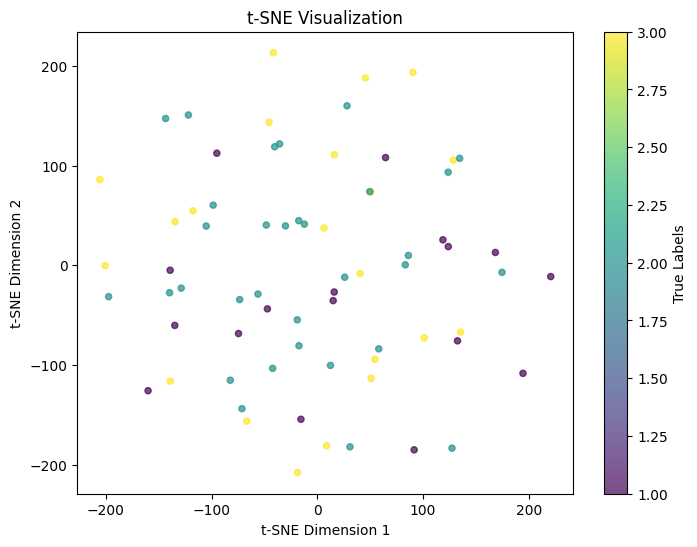

In [499]:
# Visualising the implementation
scaled_data = results_Influencers_OLS_cluster['scaled_data']
true_labels = Influencers_OLS["Category"]
tsne_visualization(scaled_data)

## 18.2. UMAP Visualisation

In [500]:
def umap_visualization(df, scaled_data, label_column='Category', colors=['green', 'orange', 'red'],
                      n_neighbors=10, min_dist=0.1):
    """
    Visualizes data using UMAP with custom colors.

    Parameters:
    - scaled_data: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels for color-coding.
    - categories: List of category values to match labels.
    - colors: List of colors corresponding to each category.
    - n_neighbors: Number of neighbors for UMAP (default=15).
    - min_dist: Minimum distance between points (default=0.1).

    Returns:
    - None (Displays a plot)
    """
    # Get unique categories in order
    categories = sorted(df[label_column].unique())

    # Get category labels from the DataFrame
    labels = df[label_column].values

    # Apply UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    umap_results = umap_reducer.fit_transform(scaled_data)

    # Create a mapping from labels to colors
    label_color_map = {category: color for category, color in zip(categories, colors)}
    mapped_colors = [label_color_map[label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(
        umap_results[:, 0], umap_results[:, 1],
        c=mapped_colors, alpha=0.8, s=50
    )
    plt.title('UMAP Visualization with Category Colors')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # Plotting

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f'Category {category}')
               for category, color in zip(categories, colors)]
    plt.legend(handles=handles, title='Category', loc='best')

    plt.show()

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



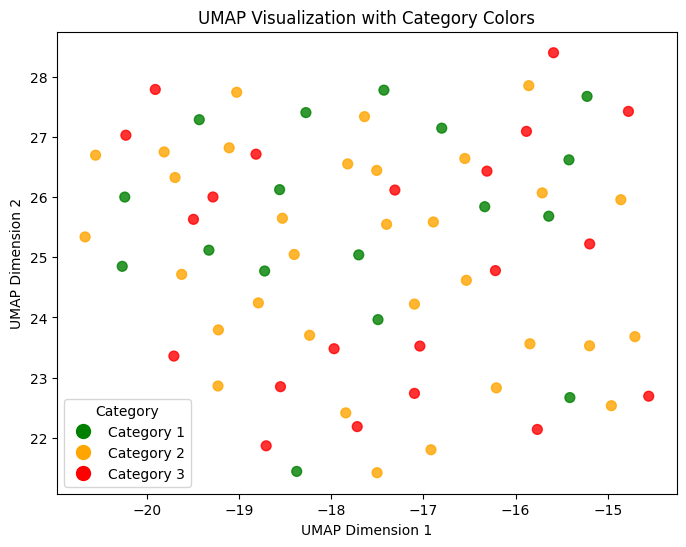

In [501]:
scaled_data = results_high_loadings_cluster['scaled_data']
# Extract category labels
category_labels = high_loadings['Category'].values

# Calling the function
umap_visualization(high_loadings, scaled_data, label_column='Category',  colors=['green', 'orange', 'red'],  n_neighbors=20, min_dist=0.7)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



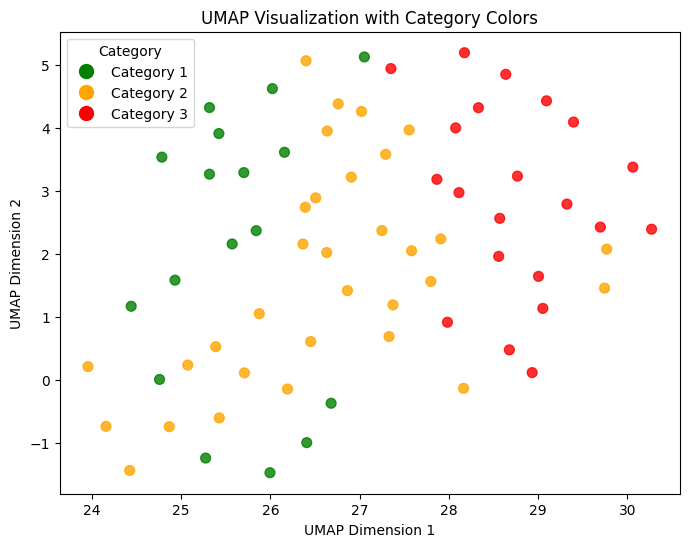

In [502]:
scaled_data = results_Influencers_OLS_cluster['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category',  colors=['green', 'orange', 'red'],  n_neighbors=20, min_dist=0.7)

### Visualisation of Influencers_OLS UMAP
presents some patterns that has distintive regions, but still some mixture.
Category 3 (red) tends to cluster on the right side
Category 1 (green) and 2 (orange) have some overlap but show patterns

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



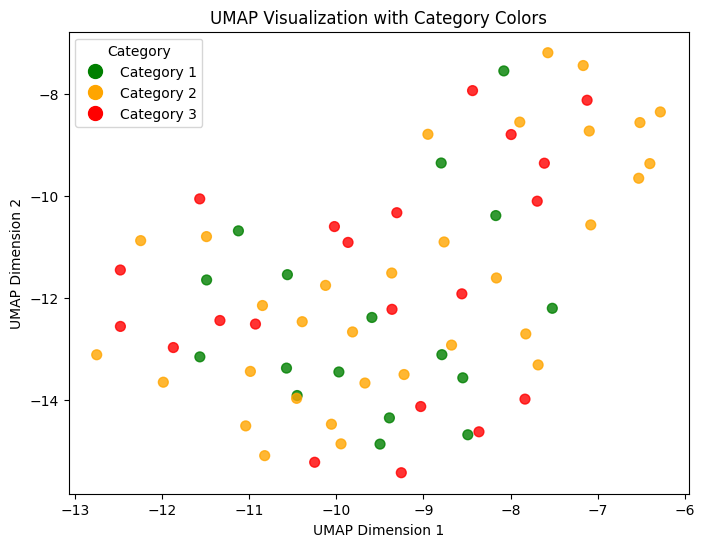

In [503]:
scaled_data = results_influencers_uniques_cluster['scaled_data']
# Extract category labels
category_labels = Influencers_uniques['Category'].values

# Calling the function
umap_visualization(Influencers_uniques, scaled_data, label_column='Category', colors=['green', 'orange', 'red'], n_neighbors=20, min_dist=0.7)

**Influencers_uniques shows**: Different spatial arrangement, better vertical separation of Category 3.
More spread out distribution overall
**Combined/Merged** shows: More mixing between categories, some local clustering but less global structure, higher dimension 2 values (7-11 range)

# 19 Integrating the Taxonomic Levels and saving the selected df

In [533]:
# Set float format display
pd.options.display.float_format = '{:.4f}'.format

# Read the excel file with multi-index columns
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])

# Drop first row specifically (index 0 which contains NaNs)
Jointax = Jointax.drop(index=0)

# Drop first column (the index column with Level1, Level2, etc)
Jointax = Jointax.drop(Jointax.columns[0], axis=1)
# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))

## 19.1.usual_suspect DataFrame
Bacteria known to be corrosive and is found on the present systems are as follows:  

214 Clostridium (Anaerobic, acid-producing bacteria)
264 Desulfobacterium (Sulfate-reducing bacteria)  
265 Desulfobulbus (Sulfate-reducing bacteria)  
270 Desulfotomaculum (Thermophilic sulfate-reducing bacteria)  
271 Desulfovibrio (Sulfate-reducing bacteria, well-documented MIC agent)
332 Gallionella (Iron-oxidizing bacteria)   
587 Pseudomonas (Known for biofilm formation and acid production)  
656 Shewanella (Metal-reducing bacteria)  
727 Thiobacillus (Sulfur-oxidizing bacteria)  
  

In [534]:
# usual_suspects taxonomic levels and abundance
usuals_gen = {271, 727, 332, 587, 656, 214, 265, 270, 264}
                                      
# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in usuals_gen]

# Create final dataframe with selected columns
usuals= Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of usual_suspects data:", usuals.shape)
usuals.head()

Shape of usual_suspects data: (70, 12)


Sites Category Clostridiales_Clostridiaceae_Clostridium  \
                                                   Bacteria   
                                                 Firmicutes   
                                                 Clostridia   
                                              Clostridiales   
                                             Clostridiaceae   
                                                Clostridium   
                                                        214   
1  site_1        3                                   0.0000   
2  site_2        1                                   0.0000   
3  site_3        1                                   0.0000   
4  site_4        1                                   0.0000   
5  site_5        1                                   0.0000   

  Desulfobacterales_Desulfobacteraceae_Desulfobacterium  \
                                               Bacteria   
                                         Proteobacteria   
                                    Deltaproteobacteria   
                                      Desulfobacterales   
                                     Desulfobacteraceae   
                                       Desulfobacterium   
                                                    264   
1                                             0.0000      
2                                             0.0000      
3                                             0.0000      
4                                             0.0000      
5                                             0.0000      

  Desulfobacterales_Desulfobulbaceae_Desulfobulbus  \
                                          Bacteria   
                                    Proteobacteria   
                               Deltaproteobacteria   
                                 Desulfobacterales   
                                  Desulfobulbaceae   
                                     Desulfobulbus   
                                               265   
1                                           0.1723   
2                                           0.0190   
3                                           0.0000   
4                                           0.0066   
5                                           0.0184   

  Clostridiales_Peptococcaceae_Desulfotomaculum  \
                                       Bacteria   
                                     Firmicutes   
                                     Clostridia   
                                  Clostridiales   
                                 Peptococcaceae   
                               Desulfotomaculum   
                                            270   
1                                        0.5170   
2                                        0.2277   
3                                        1.9642   
4                                        0.3173   
5                                        0.3626   

  Desulfovibrionales_Desulfovibrionaceae_Desulfovibrio  \
                                              Bacteria   
                                        Proteobacteria   
                                   Deltaproteobacteria   
                                    Desulfovibrionales   
                                   Desulfovibrionaceae   
                                         Desulfovibrio   
                                                   271   
1                                             8.7462     
2                                             0.4933     
3                                             0.7488     
4                                             1.6660     
5                                             0.7602     

  Gallionellales_Gallionellaceae_Gallionella  \
                                    Bacteria   
                              Proteobacteria   
                          Betaproteobacteria   
                              Gallionellales   
                             Gallionellaceae   
      

# Core community Bacteria
is bacteria that shows dominance on the cooling and heating water systems. A summatory of all the abundances of each bateria is done and the bacteria with more than 20% abundance across all the systems is designed as core_bacteria. 

In [563]:
# Final selected genera taxonomic levels and abundance
core_taxa_gen = {110, 572, 587, 143, 664, 270, 575, 491, 647, 245, 17, 671, 198, 238, 354, 591, 217, 674, 271,
                 449, 269, 731, 7, 13, 853, 687, 296, 550, 89, 344, 715, 146, 371, 214, 676, 130, 683, 484, 634, 
                 304, 719, 867, 136, 229, 581, 267, 596, 660,113, 30, 177, 462, 705, 6, 29, 206, 863, 659, 589, 360}
# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in core_taxa_gen]

# Create final dataframe with selected columns
core_taxa= Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of selected data:", core_taxa.shape)
core_taxa.head()

Shape of selected data: (70, 62)


Sites Category Clostridiales_Eubacteriaceae_Acetobacterium  \
                                                      Bacteria   
                                                    Firmicutes   
                                                    Clostridia   
                                                 Clostridiales   
                                                Eubacteriaceae   
                                                Acetobacterium   
                                                             6   
1  site_1        3                                      0.4308   
2  site_2        1                                      0.0190   
3  site_3        1                                      0.0246   
4  site_4        1                                      0.0176   
5  site_5        1                                      0.0221   

  Burkholderiales_Alcaligenaceae_Achromobacter  \
                                      Bacteria   
                                Proteobacteria   
                            Betaproteobacteria   
                               Burkholderiales   
                                Alcaligenaceae   
                                 Achromobacter   
                                             7   
1                                       0.5170   
2                                       0.3415   
3                                       0.3192   
4                                       0.2512   
5                                       0.5098   

  Rhodospirillales_Acetobacteraceae_Acidisoma  \
                                     Bacteria   
                               Proteobacteria   
                          Alphaproteobacteria   
                             Rhodospirillales   
                             Acetobacteraceae   
                                    Acidisoma   
                                           13   
1                                      0.0000   
2                                      0.0000   
3                                      0.0000   
4                                      0.0000   
5                                      0.0000   

  Burkholderiales_Comamonadaceae_Acidovorax  \
                                   Bacteria   
                             Proteobacteria   
                         Betaproteobacteria   
                            Burkholderiales   
                             Comamonadaceae   
                                 Acidovorax   
                                         17   
1                                    6.2473   
2                                    1.4798   
3                                    3.7196   
4                                    3.1293   
5                                    1.8903   

  Propionibacteriales_Propionibacteriaceae_Aestuariimicrobium  \
                                                     Bacteria   
                                               Actinobacteria   
                                               Actinobacteria   
                                          Propionibacteriales   
                                         Propionibacteriaceae   
                                           Aestuariimicrobium   
                                                           29   
1                                             0.0000            
2                                             0.0000            
3                                             0.0000            
4                                             0.0000            
5                                             0.0000            

  Rhizobiales_Bradyrhizobiaceae_Afipia Bacillales_Bacillaceae_Anoxybacillus  \
                              Bacteria                             Bacteria   
                        Proteobacteria                           Firmicutes   
                   Alphaproteobacteria                              Bacilli   
                           Rhizobiales                           Bacillales   
   

Some of this bacteria intercept with the checked dataframe of the statistically significant to corrosion label features, such are:
Halomonas (GID 354)
Clostridium (GID 214)
Streptococcus (GID 687)
Corynebacterium (GID 229)
PSB-M-3 (GID 581)

This suggests these bacteria are both important community members and are involved in corrosion processes

### Selected DataFrame

In [564]:
# Final selected genera taxonomic levels and abundance
new_selected_gen = {110, 140, 154, 201, 214, 229, 354, 408, 471, 497, 512, 526, 581, 584}
                                      # [214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625]
# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in new_selected_gen]

# Create final dataframe with selected columns
selected = Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of selected data:", selected.shape)
selected.head()

Shape of selected data: (70, 16)


Sites Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                                Bacteria   
                                          Proteobacteria   
                                      Betaproteobacteria   
                                           Rhodocyclales   
                                          Rhodocyclaceae   
                                                Azospira   
                                                     110   
1  site_1        3                               26.9280   
2  site_2        1                                1.8592   
3  site_3        1                                3.0935   
4  site_4        1                                2.5740   
5  site_5        1                                2.7094   

  Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                          Bacteria   
                                    Actinobacteria   
                                    Actinobacteria   
                                   Actinomycetales   
                                  Dermabacteraceae   
                                   Brachybacterium   
                                               140   
1                                           0.0000   
2                                           0.0000   
3                                           0.0000   
4                                           0.0000   
5                                           0.0000   

  Erysipelotrichales_Erysipelotrichaceae_Bulleidia  \
                                          Bacteria   
                                        Firmicutes   
                                   Erysipelotrichi   
                                Erysipelotrichales   
                               Erysipelotrichaceae   
                                         Bulleidia   
                                               154   
1                                           0.0000   
2                                           0.0000   
3                                           0.0000   
4                                           0.0000   
5                                           0.0000   

  Actinomycetales_Promicromonosporaceae_Cellulosimicrobium  \
                                                  Bacteria   
                                            Actinobacteria   
                                            Actinobacteria   
                                           Actinomycetales   
                                     Promicromonosporaceae   
                                        Cellulosimicrobium   
                                                       201   
1                                             0.0000         
2                                             0.0000         
3                                             0.0000         
4                                             0.0000         
5                                             0.0000         

  Clostridiales_Clostridiaceae_Clostridium  \
                                  Bacteria   
                                Firmicutes   
                                Clostridia   
                             Clostridiales   
                            Clostridiaceae   
                               Clostridium   
                                       214   
1                                   0.0000   
2                                   0.0000   
3                                   0.0000   
4                                   0.0000   
5                                   0.0000   

  Actinomycetales_Corynebacteriaceae_Corynebacterium  \
                                            Bacteria   
                                      Actinobacteria   
                                      Actinobacteria   
                                     Actinomycetales   
                                  Corynebacteriaceae   
                                     Corynebacterium   
                   

### Making high_loadings DataFrame

In [536]:
# Drop first column
high_loadings = high_loadings.drop(high_loadings.columns[0], axis=1)

In [537]:
high_loadings_GIDS = high_loadings.columns.tolist()

In [538]:
# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in high_loadings_GIDS]

# Create final dataframe with selected columns
high_loadings= Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of high_loadings data:", high_loadings.shape)
high_loadings.head()

Shape of high_loadings data: (70, 32)


Sites Category Actinomycetales_Actinomycetaceae_Actinomyces  \
                                                       Bacteria   
                                                 Actinobacteria   
                                                 Actinobacteria   
                                                Actinomycetales   
                                               Actinomycetaceae   
                                                    Actinomyces   
                                                             23   
1  site_1        3                                       0.2801   
2  site_2        1                                       1.2332   
3  site_3        1                                       0.3069   
4  site_4        1                                       2.2016   
5  site_5        1                                       0.9148   

  Clostridiales_Tissierellaceae_Anaerococcus  \
                                    Bacteria   
                                  Firmicutes   
                                  Clostridia   
                               Clostridiales   
                             Tissierellaceae   
                                Anaerococcus   
                                          81   
1                                     0.0000   
2                                     0.0000   
3                                     0.0491   
4                                     0.9542   
5                                     0.0589   

  Rhizobiales_Hyphomicrobiaceae_Aquabacter  \
                                  Bacteria   
                            Proteobacteria   
                       Alphaproteobacteria   
                               Rhizobiales   
                         Hyphomicrobiaceae   
                                Aquabacter   
                                        90   
1                                   0.0000   
2                                   0.0000   
3                                   0.0000   
4                                   0.0000   
5                                   0.0018   

  Burkholderiales_Comamonadaceae_Aquabacterium  \
                                      Bacteria   
                                Proteobacteria   
                            Betaproteobacteria   
                               Burkholderiales   
                                Comamonadaceae   
                                 Aquabacterium   
                                            91   
1                                       0.1939   
2                                       0.1138   
3                                       0.2332   
4                                       0.1410   
5                                       0.2043   

  Coriobacteriales_Atopobiaceae_Atopobium  \
                                 Bacteria   
                           Actinobacteria   
                           Coriobacteriia   
                         Coriobacteriales   
                             Atopobiaceae   
                                Atopobium   
                                      104   
1                                  0.0000   
2                                  0.0000   
3                                  0.0000   
4                                  0.0066   
5                                  0.0000   

  Actinomycetales_Promicromonosporaceae_Cellulosimicrobium  \
                                                  Bacteria   
                                            Actinobacteria   
                                            Actinobacteria   
                                           Actinomycetales   
                                     Promicromonosporaceae   
                                        Cellulosimicrobium   
                                                       201   
1                                             0.0000         
2                                             0.0000         
3                                             0.000

### Making Influencers_uniques DataFrame

In [539]:
# Drop first column
Influencers_uniques = Influencers_uniques.drop(Influencers_uniques.columns[0], axis=1)
Influencers_uniques_GIDS = Influencers_uniques.columns.tolist()

In [540]:
# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in Influencers_uniques_GIDS]

# Create final dataframe with selected columns
Influencers_uniques= Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of Influencers_uniques data:", Influencers_uniques.shape)
Influencers_uniques.head()

Shape of Influencers_uniques data: (70, 28)


Sites Category Actinomycetales_Actinomycetaceae_Actinomyces  \
                                                       Bacteria   
                                                 Actinobacteria   
                                                 Actinobacteria   
                                                Actinomycetales   
                                               Actinomycetaceae   
                                                    Actinomyces   
                                                             23   
1  site_1        3                                       0.2801   
2  site_2        1                                       1.2332   
3  site_3        1                                       0.3069   
4  site_4        1                                       2.2016   
5  site_5        1                                       0.9148   

  Burkholderiales_Comamonadaceae_Aquabacterium  \
                                      Bacteria   
                                Proteobacteria   
                            Betaproteobacteria   
                               Burkholderiales   
                                Comamonadaceae   
                                 Aquabacterium   
                                            91   
1                                       0.1939   
2                                       0.1138   
3                                       0.2332   
4                                       0.1410   
5                                       0.2043   

  Actinomycetales_Promicromonosporaceae_Cellulosimicrobium  \
                                                  Bacteria   
                                            Actinobacteria   
                                            Actinobacteria   
                                           Actinomycetales   
                                     Promicromonosporaceae   
                                        Cellulosimicrobium   
                                                       201   
1                                             0.0000         
2                                             0.0000         
3                                             0.0000         
4                                             0.0000         
5                                             0.0000         

  Clostridiales_Clostridiaceae_Clostridium  \
                                  Bacteria   
                                Firmicutes   
                                Clostridia   
                             Clostridiales   
                            Clostridiaceae   
                               Clostridium   
                                       214   
1                                   0.0000   
2                                   0.0000   
3                                   0.0000   
4                                   0.0000   
5                                   0.0000   

  Actinomycetales_Corynebacteriaceae_Corynebacterium  \
                                            Bacteria   
                                      Actinobacteria   
                                      Actinobacteria   
                                     Actinomycetales   
                                  Corynebacteriaceae   
                                     Corynebacterium   
                                                 229   
1                                             0.0000   
2                                             0.0000   
3                                             0.0000   
4                                             0.0000   
5                                             0.0018   

  Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria  \
                                               Bacteria   
                                             Firmicutes   
                                             Clostridia   
                                 Thermoanaerobacterales   
                                Thermoanaerobactera

### On the Making of Checked_genera df
Now after a deep analysis the errors of computational algoritm make me realise we leaving behind some important features, a check was perform on section 16.5 and other features resurface as important for different reasons there explained. Now there was a decision to left behind the cat strong markers because it was no the scope of this study to focus on other but bateria influcing corrosion. However after careful consideration it is decided to take the strong statistically occuring features because it would make the study more complete, since it would give real relationships of the most influential community fundamental genera. The list of features will go forward to the next analysis. This are no the most abundand overall, however present patters associated with the risk label that are consistent. Some of the original are removed: 201,211,621,81,92 and some are added 334, 549, 564, 712

In [572]:
# Final selected genera taxonomic levels and abundance
checked_GIDS = {334, 549, 564, 712, 512, 140, 526, 145, 408, 154, 300, 687, 566, 581, 583, 584, 214, 471, 470, 727, 474, 354, 229, 491, 110, 497, 503}
# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in checked_GIDS]

# Create final dataframe with selected columns
checked_genera = Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of checked_genera data:", checked_genera.shape)
checked_genera.head()

Shape of checked_genera data: (70, 29)


Sites Category Rhodocyclales_Rhodocyclaceae_Azospira  \
                                                Bacteria   
                                          Proteobacteria   
                                      Betaproteobacteria   
                                           Rhodocyclales   
                                          Rhodocyclaceae   
                                                Azospira   
                                                     110   
1  site_1        3                               26.9280   
2  site_2        1                                1.8592   
3  site_3        1                                3.0935   
4  site_4        1                                2.5740   
5  site_5        1                                2.7094   

  Actinomycetales_Dermabacteraceae_Brachybacterium  \
                                          Bacteria   
                                    Actinobacteria   
                                    Actinobacteria   
                                   Actinomycetales   
                                  Dermabacteraceae   
                                   Brachybacterium   
                                               140   
1                                           0.0000   
2                                           0.0000   
3                                           0.0000   
4                                           0.0000   
5                                           0.0000   

  Actinomycetales_Brevibacteriaceae_Brevibacterium  \
                                          Bacteria   
                                    Actinobacteria   
                                    Actinobacteria   
                                   Actinomycetales   
                                 Brevibacteriaceae   
                                    Brevibacterium   
                                               145   
1                                           0.0000   
2                                           0.0000   
3                                           0.0000   
4                                           0.0000   
5                                           0.0000   

  Erysipelotrichales_Erysipelotrichaceae_Bulleidia  \
                                          Bacteria   
                                        Firmicutes   
                                   Erysipelotrichi   
                                Erysipelotrichales   
                               Erysipelotrichaceae   
                                         Bulleidia   
                                               154   
1                                           0.0000   
2                                           0.0000   
3                                           0.0000   
4                                           0.0000   
5                                           0.0000   

  Clostridiales_Clostridiaceae_Clostridium  \
                                  Bacteria   
                                Firmicutes   
                                Clostridia   
                             Clostridiales   
                            Clostridiaceae   
                               Clostridium   
                                       214   
1                                   0.0000   
2                                   0.0000   
3                                   0.0000   
4                                   0.0000   
5                                   0.0000   

  Actinomycetales_Corynebacteriaceae_Corynebacterium  \
                                            Bacteria   
                                      Actinobacteria   
                                      Actinobacteria   
                                     Actinomycetales   
                                  Corynebacteriaceae   
                                     Corynebacterium   
                                                 229   
1                                             0.0000   
2          

from the function of parallel checking, following will make a excel file with the comparison tables, where we can compare the checked dataframe and the usual_suspects dataframe in order to compare abundances and frequencies to see it the statistical analyis made sense.

In [573]:
# Final selected genera taxonomic levels and abundance
usual_suspects = original[['Category'] + [271, 727, 332, 587, 656, 214, 624, 265, 270, 264]]

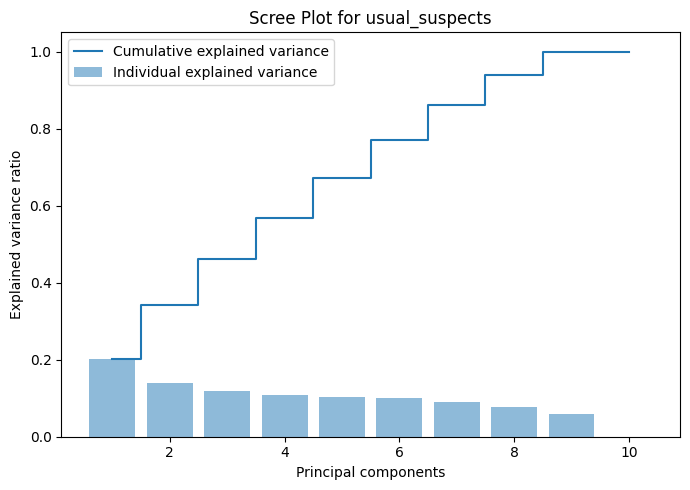

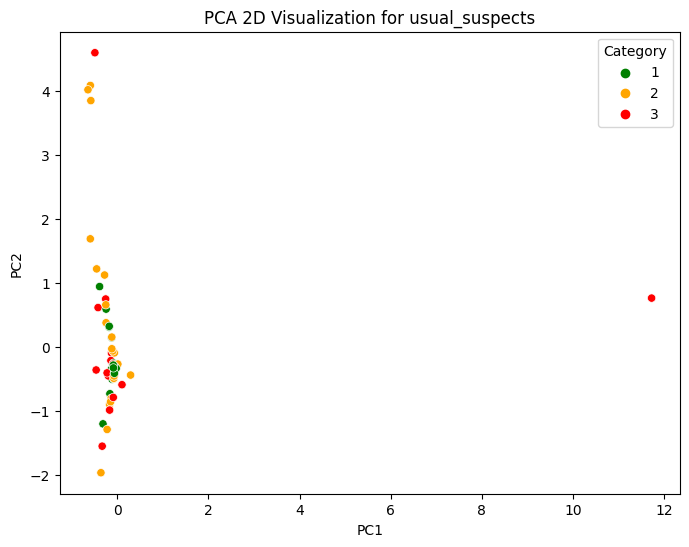

usual_suspects_pipeline:


In [574]:
# Aply pipeline for visual results
results_usual_suspects= pca_pipeline(usual_suspects, 'Category', n_components=2, dataset_name='usual_suspects')

# Apply the pipeline for numerical results
usual_suspects_pca_pipeline, df_pca_influence_usual_suspects, explained_variance_usual_suspects, n_components = apply_pipeline_pca(usual_suspects, "usual_suspects", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_usual_suspects.head(10), explained_variance_usual_suspects.head(10))

In [575]:
# Final selected genera taxonomic levels and abundance
core = original[['Category'] + [110, 572, 587, 143, 664, 270, 575, 491, 647, 245, 17, 671, 198, 238, 354, 591, 217, 674, 271,
                 449, 269, 731, 7, 13, 853, 687, 296, 550, 89, 344, 715, 146, 371, 214, 676, 130, 683, 484, 634, 
                 304, 719, 867, 136, 229, 581, 267, 596, 660,113, 30, 177, 462, 705, 6, 29, 206, 863, 659, 589, 360]]

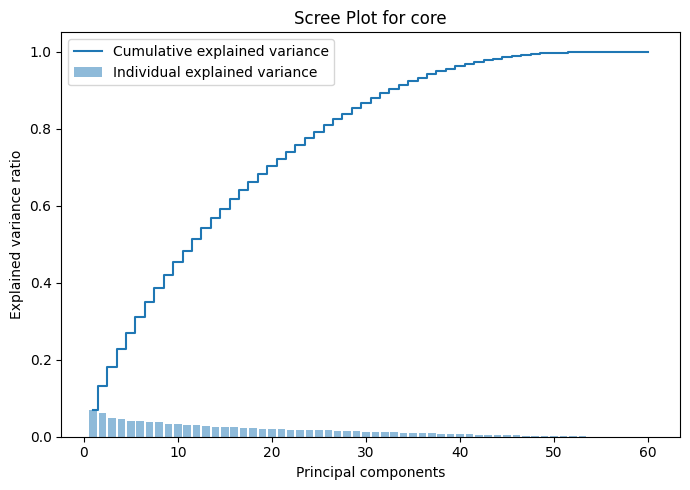

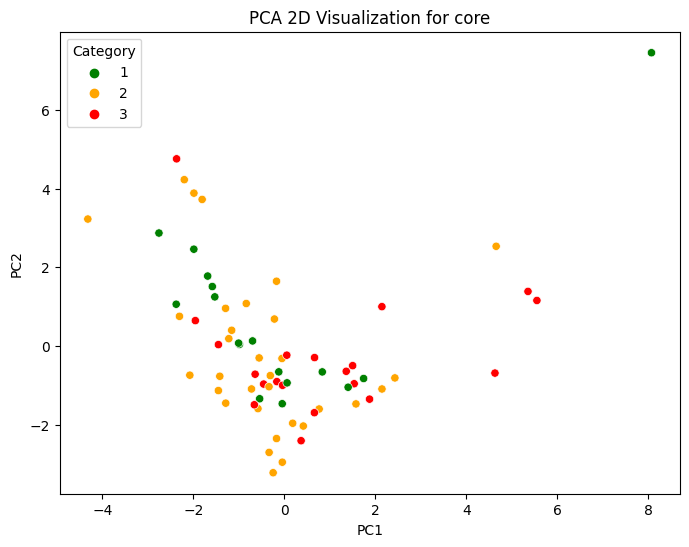

core_pipeline:


In [576]:
# Aply pipeline for visual results
results_core= pca_pipeline(core, 'Category', n_components=2, dataset_name='core')

# Apply the pipeline for numerical results
core_pca_pipeline, df_pca_influence_core, explained_variance_core, n_components = apply_pipeline_pca(core, "core", n_components=2, n_top_features=None)

# Display the data side by side
#display_side_by_side(df_pca_influence_core.head(10), explained_variance_core.head(10))

In [577]:
# Create dictionary of dataframes to analyze
dfs = {'checked':checked, 'usual_suspects': usual_suspects, 'core': core
}
# create single sheet excel file with all tables
create_feature_analysis_tables(dfs_dict=dfs,
                               #output_path = '/content/drive/My Drive/MIC/data',
                               output_path = '~/MIC/2_Micro/data',
                               output_filename= 'comparing_check_usual.xlsx', single_sheet=True)

In [578]:
convergence_checked = check_model_convergence(checked, checked_feature_scores, threshold=0.01)
convergence_checked

(True, 1)

Following saving is silence so that the further files dependency wont change if need to run an special part of the notebook.

In [579]:
# Save multiple dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'~/MIC/2_Micro/data/finalist_dfs.xlsx') as writer: # for colab /content/drive/My Drive/
    high_loadings.to_excel(writer, sheet_name='high_loadings', index=True)
    Influencers_uniques.to_excel(writer, sheet_name='Influencers_uniques', index=True)
    checked_genera.to_excel(writer, sheet_name='checked_genera')
    core_taxa.to_excel(writer, sheet_name= 'core_taxa')
    selected.to_excel(writer, sheet_name='selected')
    usuals.to_excel(writer, sheet_name= 'usual_genera')

In [580]:
# Extract Genera from the multi-index
genera_info = list(zip(Jointax.columns.get_level_values(6), Jointax.columns.get_level_values(7)))

In [581]:
print(genera_info)

[('', ''), ('', ''), ('02d06', '1'), ('A17', '2'), ('Abiotrophia', '3'), ('Acetanaerobacterium', '4'), ('Acetivibrio', '5'), ('Acetobacterium', '6'), ('Achromobacter', '7'), ('Acidaminobacter', '8'), ('Acidibacter', '9'), ('Acidicapsa', '10'), ('Acidiferrobacter', '11'), ('Acidiphilium', '12'), ('Acidisoma', '13'), ('Acidithrix', '14'), ('Acidobacterium', '15'), ('Acidocella', '16'), ('Acidovorax', '17'), ('Acinetobacter', '18'), ('Actibacterium', '19'), ('Actinobacillus', '20'), ('Actinobacterium', '21'), ('Actinobacterium_vesm15', '22'), ('Actinomyces', '23'), ('Actinotalea', '24'), ('Advenella', '25'), ('Aegean-169_marine_group', '26'), ('Aerococcus', '27'), ('Aeromonas', '28'), ('Aestuariimicrobium', '29'), ('Afipia', '30'), ('Agaricicola', '31'), ('Aggregatibacter', '32'), ('Agrobacterium', '33'), ('Agrococcus', '34'), ('Agromyces', '35'), ('Albidiferax', '36'), ('Albidiferax_sp_7a-189', '37'), ('Alcaligenes', '38'), ('Alcanivorax', '39'), ('Alicycliphilus', '40'), ('Alicyclobacil

In [582]:
print(Jointax.columns.get_level_values(6).tolist())

['', '', '02d06', 'A17', 'Abiotrophia', 'Acetanaerobacterium', 'Acetivibrio', 'Acetobacterium', 'Achromobacter', 'Acidaminobacter', 'Acidibacter', 'Acidicapsa', 'Acidiferrobacter', 'Acidiphilium', 'Acidisoma', 'Acidithrix', 'Acidobacterium', 'Acidocella', 'Acidovorax', 'Acinetobacter', 'Actibacterium', 'Actinobacillus', 'Actinobacterium', 'Actinobacterium_vesm15', 'Actinomyces', 'Actinotalea', 'Advenella', 'Aegean-169_marine_group', 'Aerococcus', 'Aeromonas', 'Aestuariimicrobium', 'Afipia', 'Agaricicola', 'Aggregatibacter', 'Agrobacterium', 'Agrococcus', 'Agromyces', 'Albidiferax', 'Albidiferax_sp_7a-189', 'Alcaligenes', 'Alcanivorax', 'Alicycliphilus', 'Alicyclobacillus', 'Alishewanella', 'Alkalibacter', 'Alkaliphilus', 'Alkanindiges', 'Alloiococcus', 'Alloprevotella', 'Alpha_proteobacterium', 'Alpha_proteobacterium_c0014(2010)', 'Alpha_proteobacterium_kc-it-f2', 'Alpha_proteobacterium_r-36935', 'Altererythrobacter', 'Alteromonas', 'Amaricoccus', 'Alcaligenaceae_unclassified', 'Ambigu